## Обработка графиков ЭКГ и преобразование в таблицу

In [283]:
import pywt
import scipy
import os
from pylab import *
from numpy import*
import pandas as pd

import matplotlib.pyplot as plt
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split

In [284]:
def get_ecg(key, directory): # получение закодированного графика экг из файла
    way = directory + key + '.npy'
    ecgsig = np.load(way).transpose().reshape((60000,))
    x = np.linspace(0,  1,  num = 2048)
    data = np.sin(250 * np.pi * x**2)
    coefs = pywt.downcoef('a', data, 'db20', mode='symmetric', level=1)
    st='sym5'
    coeffs = pywt.wavedec(ecgsig, st, level=5)
    row = coeffs[0]
    return row

In [285]:
def into_one_table(keys, directory): # преобразование графиков в таблицу
    row = get_ecg(keys[0], directory)
    row = np.insert(row, 0, int(keys[0].strip('_hr')))
    table = [row]
    for i in range(target.index.start + 1, target.index.stop):
        row = get_ecg(keys[i], directory)
        row = np.insert(row, 0, int(keys[i].strip('_hr')))
        table = np.vstack([table, row])
    table = pd.DataFrame(table)
    return table

In [286]:
%%time
target = pd.Series(list(map(lambda x: x[:-4], os.listdir('train')[:-3])))
ECG_data = into_one_table(target, 'train/') # таблица с графиками

CPU times: total: 1.92 s
Wall time: 53.8 s


In [287]:
ECG_data[0] = ECG_data[0].astype('int')
ECG_data = ECG_data.rename(columns={0: 'record_name'})

In [288]:
ECG_data = ECG_data.sort_values(by=['record_name'], ascending=True)

In [289]:
ECG_data

,record_name,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
0,9,-0.170442,-0.066933,-0.140079,-0.478502,-1.245167,-0.979738,-0.738943,-0.476043,-0.349288,...,0.558936,0.551860,0.551007,0.561618,0.556675,0.645774,0.744957,0.649421,0.667106,0.731759
1,34,0.399648,0.579593,0.460080,-0.077166,-1.270282,-1.040847,-1.689153,-2.481032,-2.205554,...,1.113606,1.088111,1.099680,1.132341,1.130250,1.788834,2.455783,1.818630,1.938019,2.363243
2,43,0.411589,0.365335,0.399006,0.554728,0.911140,0.774487,0.576258,0.404740,0.229235,...,0.341701,0.340029,0.342162,0.341734,0.340499,0.346990,0.366654,0.343959,0.348800,0.365320
3,52,-0.162251,-0.159025,-0.159327,-0.163111,-0.158814,-0.159398,-0.162262,-0.174764,-0.179583,...,-0.267047,-0.258175,-0.261318,-0.274144,-0.273755,-0.519687,-0.765086,-0.532849,-0.575938,-0.730437
4,57,-0.268330,-0.279812,-0.270770,-0.232069,-0.136626,-0.155710,-0.117283,-0.096148,-0.074360,...,-0.304742,-0.297821,-0.302716,-0.310384,-0.311176,-0.513279,-0.714933,-0.521431,-0.558040,-0.686983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,21784,-0.094946,-0.097736,-0.095932,-0.087848,-0.070772,-0.076037,-0.082161,-0.089443,-0.092388,...,0.005842,0.004748,0.005003,0.006885,0.006829,0.041791,0.079657,0.044349,0.050701,0.074361
2097,21795,-0.194416,-0.182553,-0.191956,-0.238293,-0.352612,-0.314071,-0.319038,-0.313175,-0.285890,...,0.120157,0.117738,0.121368,0.121892,0.122540,0.189928,0.260724,0.190226,0.204078,0.251573
2098,21825,-0.004072,-0.000198,-0.003268,-0.017719,-0.054790,-0.048271,-0.088630,-0.084493,-0.070101,...,-0.128999,-0.124998,-0.127924,-0.131497,-0.131004,-0.222249,-0.318699,-0.224482,-0.242503,-0.305902
2099,21831,-0.128454,-0.127641,-0.128944,-0.136319,-0.158699,-0.147968,-0.147763,-0.142817,-0.138197,...,-0.159457,-0.155589,-0.158779,-0.161389,-0.160510,-0.233738,-0.313892,-0.233884,-0.249503,-0.303710


## Объединение таблиц, разбиение на тренировочную и валидационную выборки

In [290]:
df = pd.read_csv('train/train_meta.csv')
df.record_name = list(map(lambda x: int(x.strip('_hr')), df.record_name))
df

,patient_id,age,sex,height,weight,record_name
0,18792.0,55.0,0,NaN,70.0,9
1,13619.0,56.0,0,NaN,NaN,34
2,11315.0,25.0,1,NaN,63.0,43
3,18153.0,35.0,0,NaN,82.0,52
4,16063.0,26.0,0,NaN,93.0,57
...,...,...,...,...,...,...
2096,12488.0,66.0,1,NaN,NaN,21784
2097,10162.0,68.0,0,NaN,NaN,21795
2098,11197.0,59.0,0,NaN,NaN,21825
2099,11905.0,55.0,1,NaN,NaN,21831


In [291]:
ECG_data = ECG_data.merge(df, on='record_name', how='left')

In [292]:
gts = pd.read_csv('train/train_gts_final.csv')
gts.record_name = list(map(lambda x: int(x.strip('_hr')), gts.record_name))
gts

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма,record_name
0,0,0,0,0,0,0,1,669
1,0,0,0,0,0,0,1,209
2,0,0,0,0,0,0,1,777
3,0,0,0,0,0,0,1,1394
4,0,0,0,0,0,0,1,1618
...,...,...,...,...,...,...,...,...
2096,0,0,0,0,0,0,1,20864
2097,0,0,0,0,0,0,1,20967
2098,0,0,0,0,0,0,1,21744
2099,0,0,0,0,0,0,1,3465


In [293]:
ECG_data = ECG_data.merge(gts, on='record_name', how='left')

In [294]:
ECG_data

,record_name,1,2,3,4,5,6,7,8,9,...,sex,height,weight,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
0,9,-0.170442,-0.066933,-0.140079,-0.478502,-1.245167,-0.979738,-0.738943,-0.476043,-0.349288,...,0,NaN,70.0,0,0,0,0,0,0,1
1,34,0.399648,0.579593,0.460080,-0.077166,-1.270282,-1.040847,-1.689153,-2.481032,-2.205554,...,0,NaN,NaN,0,0,0,0,0,0,1
2,43,0.411589,0.365335,0.399006,0.554728,0.911140,0.774487,0.576258,0.404740,0.229235,...,1,NaN,63.0,0,0,0,0,0,0,1
3,52,-0.162251,-0.159025,-0.159327,-0.163111,-0.158814,-0.159398,-0.162262,-0.174764,-0.179583,...,0,NaN,82.0,0,0,0,0,0,0,1
4,57,-0.268330,-0.279812,-0.270770,-0.232069,-0.136626,-0.155710,-0.117283,-0.096148,-0.074360,...,0,NaN,93.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,21784,-0.094946,-0.097736,-0.095932,-0.087848,-0.070772,-0.076037,-0.082161,-0.089443,-0.092388,...,1,NaN,NaN,0,0,0,0,0,0,1
2097,21795,-0.194416,-0.182553,-0.191956,-0.238293,-0.352612,-0.314071,-0.319038,-0.313175,-0.285890,...,0,NaN,NaN,0,0,0,0,0,0,1
2098,21825,-0.004072,-0.000198,-0.003268,-0.017719,-0.054790,-0.048271,-0.088630,-0.084493,-0.070101,...,0,NaN,NaN,0,0,0,0,0,0,1
2099,21831,-0.128454,-0.127641,-0.128944,-0.136319,-0.158699,-0.147968,-0.147763,-0.142817,-0.138197,...,1,NaN,NaN,0,0,0,0,0,0,1


In [295]:
gts = ECG_data[['перегородочный', 'передний', 'боковой', 'передне-боковой', 'передне-перегородочный', 'нижний', 'норма']]
gts

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
2096,0,0,0,0,0,0,1
2097,0,0,0,0,0,0,1
2098,0,0,0,0,0,0,1
2099,0,0,0,0,0,0,1


In [296]:
ECG_data = ECG_data.drop(['перегородочный', 'передний', 'боковой', 'передне-боковой',
                          'передне-перегородочный', 'нижний', 'норма'], axis=1)

In [297]:
ECG_data_train, ECG_data_val, myocard_train, myocard_val = train_test_split(ECG_data, gts, random_state=0)

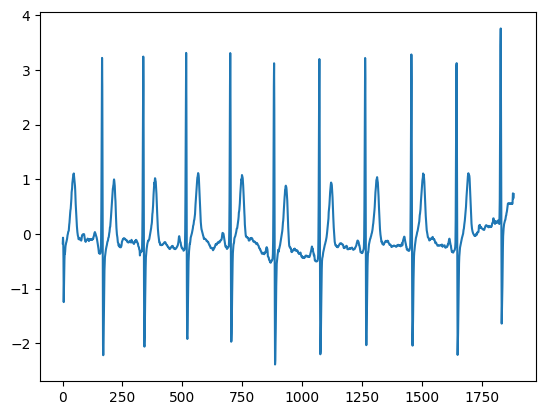

In [298]:
plt.plot(ECG_data.iloc[0, 1:-5]) # график экг после обработки сигнала

In [299]:
df_train = ECG_data_train.iloc[:, -5:]
df_val = ECG_data_val.iloc[:, -5:]

In [300]:
df_train

,patient_id,age,sex,height,weight
1592,4964.0,22.0,1,163.0,90.0
918,16196.0,84.0,0,NaN,NaN
122,767.0,61.0,0,183.0,83.0
684,12056.0,74.0,1,NaN,NaN
214,2452.0,60.0,1,152.0,NaN
...,...,...,...,...,...
1033,18617.0,49.0,0,NaN,NaN
1731,4102.0,64.0,1,168.0,66.0
763,10524.0,34.0,0,NaN,72.0
835,10717.0,55.0,0,NaN,NaN


In [301]:
ECG_data_train = ECG_data_train.iloc[:, :-5]
ECG_data_val = ECG_data_val.iloc[:, :-5]

In [302]:
ECG_data_train

,record_name,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
1592,16603,0.109449,0.185223,0.125672,-0.151371,-0.829218,-0.622236,-0.656209,-0.655158,-0.620203,...,-0.276397,-0.271167,-0.271356,-0.278988,-0.276562,-0.365569,-0.453599,-0.369220,-0.385059,-0.441318
918,9557,-1.490900,-1.394463,-1.459593,-1.758585,-2.413724,-2.193418,-1.980952,-1.772527,-1.498688,...,1.808763,1.794004,1.791578,1.824338,1.824525,2.338546,2.856921,2.381495,2.466389,2.781295
122,1511,0.410295,0.418111,0.411441,0.385160,0.316728,0.322976,0.268045,0.196556,0.132210,...,0.429139,0.419976,0.423895,0.435734,0.434976,0.667413,0.897665,0.677479,0.718923,0.865508
684,7125,-0.121402,-0.121375,-0.120977,-0.119733,-0.114203,-0.115726,-0.117201,-0.126269,-0.128501,...,0.680528,0.667779,0.672897,0.689272,0.687265,0.994409,1.308699,1.007843,1.064270,1.265372
214,2316,0.028528,-0.025202,0.009788,0.172212,0.546162,0.536875,1.251363,2.411523,3.051960,...,-0.384466,-0.378909,-0.380860,-0.388554,-0.387973,-0.530641,-0.673326,-0.537565,-0.562936,-0.653343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,10677,1.348874,1.394465,1.405025,1.479370,1.920034,1.547778,0.474275,-0.755991,-1.562751,...,-0.187951,-0.184040,-0.186707,-0.190465,-0.189940,-0.280883,-0.378106,-0.283582,-0.301543,-0.365178
1731,18020,-0.285911,-0.265134,-0.282379,-0.365458,-0.574443,-0.503349,-0.498727,-0.482626,-0.459739,...,-0.247702,-0.239041,-0.247471,-0.255108,-0.257066,-0.526102,-0.801259,-0.535676,-0.586126,-0.763746
763,7978,-0.316812,-0.305549,-0.314139,-0.357382,-0.462342,-0.426322,-0.437142,-0.429418,-0.412790,...,-0.151037,-0.149981,-0.150161,-0.152364,-0.152745,-0.197529,-0.242362,-0.200993,-0.208471,-0.235857
835,8797,-0.897106,-0.901242,-0.897541,-0.887869,-0.862189,-0.857458,-0.841005,-0.826645,-0.800221,...,0.142141,0.140497,0.141669,0.143489,0.143677,0.191975,0.240699,0.193946,0.202788,0.233976


## N-граммы

In [303]:
import neurokit2
import sleepecg
import wfdb.processing
from nltk.util import ngrams

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from catboost import CatBoostClassifier

In [304]:
def find_peaks(ecgsignal, peak): # нахождение пиков
    return wfdb.processing.correct_peaks(ecgsignal, rpeaks,
            search_radius=36, smooth_window_size=50, peak_dir=peak)

In [305]:
def get_cycle(ecgsignal, rpeaks): # разбиение ЭКГ на циклы
    ecgsignal_split = []
    cycle = []
    rpeaks = rpeaks[::-1]
    f = True #флаг конца массива с пиками
    f1 = True #флаг вхождения первого пика
    for i in range(len(ecgsignal)):
        if f and i == rpeaks[-1]:
            if f1:
                f1 = False
                cycle = []
            else:
                ecgsignal_split.append(cycle)
                cycle = []
            rpeaks = rpeaks[:-1]
            if f and len(rpeaks) == 0:
                f = False
        cycle.append(ecgsignal[i])
    return ecgsignal_split

In [306]:
def sign(x): # возвращает знак числа
   return 1 if x > 0 else -1

In [307]:
def RTL(ecgsignal_split): # получение списка приращения амплитуд R, интервалов T, углов L
    sp = [[(i[0] - min(i[:10])), len(i), ((i[0] - min(i[:10]))/len(i))] for i in ecgsignal_split]
    s = []
    for i in range(len(sp) - 1):
        R = sp[i + 1][0] - sp[i][0]
        T = sp[i + 1][1] - sp[i][1]
        L = sp[i + 1][2] - sp[i][2]
        s.append([R, T, L])
    return s

In [308]:
def letters(data): # кодирование цикла по В.М. Успенскому
  if data[0] == 1:
    if data[1] == -1:
      return 'C'
    else:
      if data[2] == -1:
        return 'E'
      return 'A'
  else:
    if data[1] == 1:
      return 'D'
    else:
      if data[2] == 1:
        return 'B'
      return 'F'

In [309]:
def encoding(ecgsignal_split): # кодирование циклов в строку по В.М. Успенскому
    s = [[sign(i) for i in k] for k in RTL(ecgsignal_split)]
    stroka = ''
    for i in s:
        stroka += letters(i)
    return stroka

In [310]:
def counter_and_sort(arr): # считает и сортирует н-граммы
  quantity = {}
  for i in arr:
    if i in quantity:
      quantity[i] += 1
    else:
      quantity[i] = 1
  quantity = pd.Series(list(quantity.values()), index=list(quantity.keys())).sort_values(ascending=False)
  return quantity

In [311]:
def func(ng):  # возвращает список количества н-грамм, относящихся к каждой категории
    # н-граммы, встречающиеся только в этой категории
    ng_healthy = sum(list(map(lambda x: 1 if x in only_healthy else 0, ng))) 
    ng_sick = sum(list(map(lambda x: 1 if x in only_sick else 0, ng)))
    
    ng_septal_0 = sum(list(map(lambda x: 1 if x in only_septal_0 else 0, ng)))
    ng_septal_1 = sum(list(map(lambda x: 1 if x in only_septal_1 else 0, ng)))
    
    ng_front_0 = sum(list(map(lambda x: 1 if x in only_front_0 else 0, ng)))
    ng_front_1 = sum(list(map(lambda x: 1 if x in only_front_1 else 0, ng)))
    
    ng_side_0 = sum(list(map(lambda x: 1 if x in only_side_0 else 0, ng)))
    ng_side_1 = sum(list(map(lambda x: 1 if x in only_side_1 else 0, ng)))
    
    ng_front_side_0 = sum(list(map(lambda x: 1 if x in only_front_side_0 else 0, ng)))
    ng_front_side_1 = sum(list(map(lambda x: 1 if x in only_front_side_1 else 0, ng)))
    
    ng_front_septal_0 = sum(list(map(lambda x: 1 if x in only_front_septal_0 else 0, ng)))
    ng_front_septal_1 = sum(list(map(lambda x: 1 if x in only_front_septal_1 else 0, ng)))
    
    ng_lower_0 = sum(list(map(lambda x: 1 if x in only_lower_0 else 0, ng)))
    ng_lower_1 = sum(list(map(lambda x: 1 if x in only_lower_1 else 0, ng)))
    
    # н-граммы, которые чаще всего встречаются в этой и не встречаются в противоположной категории
    ng_popular_healthy = sum(list(map(lambda x: 1 if x in popular_healthy_only else 0, ng)))
    ng_popular_sick = sum(list(map(lambda x: 1 if x in popular_sick_only else 0, ng)))
    
    ng_popular_septal_0 = sum(list(map(lambda x: 1 if x in popular_septal_0_only else 0, ng)))
    ng_popular_septal_1 = sum(list(map(lambda x: 1 if x in popular_septal_1_only else 0, ng)))
    
    ng_popular_front_0 = sum(list(map(lambda x: 1 if x in popular_front_0_only else 0, ng)))
    ng_popular_front_1 = sum(list(map(lambda x: 1 if x in popular_front_1_only else 0, ng)))
    
    ng_popular_side_0 = sum(list(map(lambda x: 1 if x in popular_side_0_only else 0, ng)))
    ng_popular_side_1 = sum(list(map(lambda x: 1 if x in popular_side_1_only else 0, ng)))
    
    ng_popular_front_side_0 = sum(list(map(lambda x: 1 if x in popular_front_side_0_only else 0, ng)))
    ng_popular_front_side_1 = sum(list(map(lambda x: 1 if x in popular_front_side_1_only else 0, ng)))
    
    ng_popular_front_septal_0 = sum(list(map(lambda x: 1 if x in popular_front_septal_0_only else 0, ng)))
    ng_popular_front_septal_1 = sum(list(map(lambda x: 1 if x in popular_front_septal_1_only else 0, ng)))
    
    ng_popular_lower_0 = sum(list(map(lambda x: 1 if x in popular_lower_0_only else 0, ng)))
    ng_popular_lower_1 = sum(list(map(lambda x: 1 if x in popular_lower_1_only else 0, ng)))
    
    return array([[ng_healthy, ng_popular_healthy, ng_sick, ng_popular_sick],
                  [ng_septal_0, ng_popular_septal_0, ng_septal_1, ng_popular_septal_1],
                  [ng_front_0, ng_popular_front_0, ng_front_1, ng_popular_front_1],
                  [ng_side_0, ng_popular_side_0, ng_side_1, ng_popular_side_1],
                  [ng_front_side_0, ng_popular_front_side_0, ng_front_side_1, ng_popular_front_side_1],
                  [ng_front_septal_0, ng_popular_front_septal_0, ng_front_septal_1, ng_popular_front_septal_1],
                  [ng_lower_0, ng_popular_lower_0, ng_lower_1, ng_popular_lower_1]])

In [312]:
def sp_n_gramms(ngramma):  # получение н-грамм
    sp = []
    for i in ngramma:
        n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(i), 4))))
        for k in n:
            sp.append(k)
    return sp

In [313]:
ECG_data_array_train = np.array(ECG_data_train)

In [314]:
R_Peaks_train = []

In [315]:
ecg_ids_train = []
encoding_ecgs_train = []

In [316]:
for ecgsignal in ECG_data_array_train: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks_train.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids_train.append(ecg_id)
    encoding_ecgs_train.append(encoding_ecg)

In [317]:
encoding_ecg_train = pd.DataFrame(columns=['encoding_ecg', 'ecg_id', 'перегородочный', 'передний', 'боковой',
                                           'передне-боковой','передне-перегородочный', 'нижний', 'норма'])
encoding_ecg_train.encoding_ecg = encoding_ecgs_train
encoding_ecg_train.ecg_id = ecg_ids_train
encoding_ecg_train = encoding_ecg_train.sort_values(by='ecg_id')
encoding_ecg_train[['перегородочный', 'передний', 'боковой',
                    'передне-боковой','передне-перегородочный', 'нижний', 'норма']] = array(myocard_train)
encoding_ecg_train

,encoding_ecg,ecg_id,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
1027,DDCADDCC,9.0,0,0,0,0,0,0,1
189,BFABCFADDEC,43.0,0,0,0,0,0,0,1
1064,DDEFBCCBCCF,52.0,0,0,0,0,0,0,1
43,DDCADBCDD,57.0,0,0,0,0,0,0,1
1110,FFCCFDCFDA,96.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
365,EBDCEBDCEB,21756.0,0,0,0,0,0,0,1
181,BCEFCCDDFAF,21774.0,0,0,0,0,0,0,1
344,AEDDDCCD,21775.0,0,0,0,0,0,0,1
1389,ECCDDDECB,21825.0,0,1,0,0,0,0,0


In [318]:
encoding_ecg_train.норма.sum()

1269

In [319]:
healthy = encoding_ecg_train[encoding_ecg_train['норма'] == 1].encoding_ecg  # закодированные кардиограммы по категориям
sick = encoding_ecg_train[encoding_ecg_train['норма'] == 0].encoding_ecg

septal_0 = encoding_ecg_train[encoding_ecg_train['перегородочный'] == 0].encoding_ecg
septal_1 = encoding_ecg_train[encoding_ecg_train['перегородочный'] == 1].encoding_ecg

front_0 = encoding_ecg_train[encoding_ecg_train['передний'] == 0].encoding_ecg
front_1 = encoding_ecg_train[encoding_ecg_train['передний'] == 1].encoding_ecg

side_0 = encoding_ecg_train[encoding_ecg_train['боковой'] == 0].encoding_ecg
side_1 = encoding_ecg_train[encoding_ecg_train['боковой'] == 1].encoding_ecg

front_side_0 = encoding_ecg_train[encoding_ecg_train['передне-боковой'] == 0].encoding_ecg
front_side_1 = encoding_ecg_train[encoding_ecg_train['передне-боковой'] == 1].encoding_ecg

front_septal_0 = encoding_ecg_train[encoding_ecg_train['передне-перегородочный'] == 0].encoding_ecg
front_septal_1 = encoding_ecg_train[encoding_ecg_train['передне-перегородочный'] == 1].encoding_ecg

lower_0 = encoding_ecg_train[encoding_ecg_train['нижний'] == 0].encoding_ecg
lower_1 = encoding_ecg_train[encoding_ecg_train['нижний'] == 1].encoding_ecg

In [320]:
sp_healthy = sp_n_gramms(healthy)  # списки н-грамм
sp_sick = sp_n_gramms(sick)

sp_septal_0 = sp_n_gramms(septal_0)
sp_septal_1 = sp_n_gramms(septal_1)

sp_front_0 = sp_n_gramms(front_0)
sp_front_1 = sp_n_gramms(front_1)

sp_side_0 = sp_n_gramms(side_0)
sp_side_1 = sp_n_gramms(side_1)

sp_front_side_0 = sp_n_gramms(front_side_0)
sp_front_side_1 = sp_n_gramms(front_side_1)

sp_front_septal_0 = sp_n_gramms(front_septal_0)
sp_front_septal_1 = sp_n_gramms(front_septal_1)

sp_lower_0 = sp_n_gramms(lower_0)
sp_lower_1 = sp_n_gramms(lower_1)

In [321]:
q_healthy = counter_and_sort(sp_healthy)  # отсортированные н-граммы
q_sick = counter_and_sort(sp_sick)

q_septal_0 = counter_and_sort(sp_septal_0)
q_septal_1 = counter_and_sort(sp_septal_1)

q_front_0 = counter_and_sort(sp_front_0)
q_front_1 = counter_and_sort(sp_front_1)

q_side_0 = counter_and_sort(sp_side_0)
q_side_1 = counter_and_sort(sp_side_1)

q_front_side_0 = counter_and_sort(sp_front_side_0)
q_front_side_1 = counter_and_sort(sp_front_side_1)

q_front_septal_0 = counter_and_sort(sp_front_septal_0)
q_front_septal_1 = counter_and_sort(sp_front_septal_1)

q_lower_0 = counter_and_sort(sp_lower_0)
q_lower_1 = counter_and_sort(sp_lower_1)

In [322]:
only_sick = list(set(q_sick.index) - set(q_healthy.index))  # н-граммы, встречающиеся только в этой категории 
only_healthy = list(set(q_healthy.index) - set(q_sick.index))

only_septal_0 = list(set(q_septal_0.index) - set(q_septal_1.index))
only_septal_1 = list(set(q_septal_1.index) - set(q_septal_0.index))

only_front_0 = list(set(q_front_0.index) - set(q_front_1.index))
only_front_1 = list(set(q_front_1.index) - set(q_front_0.index))

only_side_0 = list(set(q_side_0.index) - set(q_side_1.index))
only_side_1 = list(set(q_side_1.index) - set(q_side_0.index))

only_front_side_0 = list(set(q_front_side_0.index) - set(q_front_side_1.index))
only_front_side_1 = list(set(q_front_side_1.index) - set(q_front_side_0.index))

only_front_septal_0 = list(set(q_front_septal_0.index) - set(q_front_septal_1.index))
only_front_septal_1 = list(set(q_front_septal_1.index) - set(q_front_septal_0.index))

only_lower_0 = list(set(q_lower_0.index) - set(q_lower_1.index))
only_lower_1 = list(set(q_lower_1.index) - set(q_lower_0.index))

In [323]:
popular_sick = q_sick.iloc[:len(q_sick) // 2]  # н-граммы, чаще всего встречающиеся в этой категории
popular_healthy = q_healthy.iloc[:len(q_healthy) // 2]

popular_septal_0 = q_septal_0.iloc[:len(q_septal_0) // 2]
popular_septal_1 = q_septal_1.iloc[:len(q_septal_1) // 2]

popular_front_0 = q_front_0.iloc[:len(q_front_0) // 2]
popular_front_1 = q_front_1.iloc[:len(q_front_1) // 2]

popular_side_0 = q_side_0.iloc[:len(q_side_0) // 2]
popular_side_1 = q_side_1.iloc[:len(q_side_1) // 2]

popular_front_side_0 = q_front_side_0.iloc[:len(q_front_side_0) // 2]
popular_front_side_1 = q_front_side_1.iloc[:len(q_front_side_1) // 2]

popular_front_septal_0 = q_front_septal_0.iloc[:len(q_front_septal_0) // 2]
popular_front_septal_1 = q_front_septal_1.iloc[:len(q_front_septal_1) // 2]

popular_lower_0 = q_lower_0.iloc[:len(q_lower_0) // 2]
popular_lower_1 = q_lower_1.iloc[:len(q_lower_1) // 2]

In [324]:
# н-граммы, которые чаще всего встречаются в этой и не встречаются в противоположной категории
popular_sick_only = list(set(popular_sick.index) - set(popular_healthy.index))
popular_healthy_only = list(set(popular_healthy.index) - set(popular_sick.index))

popular_septal_0_only = list(set(popular_septal_0.index) - set(popular_septal_1.index))
popular_septal_1_only = list(set(popular_septal_1.index) - set(popular_septal_0.index))

popular_front_0_only = list(set(popular_front_0.index) - set(popular_front_1.index))
popular_front_1_only = list(set(popular_front_1.index) - set(popular_front_0.index))

popular_side_0_only = list(set(popular_side_0.index) - set(popular_side_1.index))
popular_side_1_only = list(set(popular_side_1.index) - set(popular_side_0.index))

popular_front_side_0_only = list(set(popular_front_side_0.index) - set(popular_front_side_1.index))
popular_front_side_1_only = list(set(popular_front_side_1.index) - set(popular_front_side_0.index))

popular_front_septal_0_only = list(set(popular_front_septal_0.index) - set(popular_front_septal_1.index))
popular_front_septal_1_only = list(set(popular_front_septal_1.index) - set(popular_front_septal_0.index))

popular_lower_0_only = list(set(popular_lower_0.index) - set(popular_lower_1.index))
popular_lower_1_only = list(set(popular_lower_1.index) - set(popular_lower_0.index))

In [325]:
ngramms_ecgs_train = []  # список н-грамм в кардиограммах
for ecg in array(encoding_ecg_train):
    ngramms_ecg = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg[0]), 4))))
    for k in n:
        ngramms_ecg.add(k)
    ngramms_ecgs_train.append(list(ngramms_ecg))

In [326]:
df_healthy_ngramms = pd.DataFrame([func(ng)[0] for ng in ngramms_ecgs_train])
df_septal_ngramms = pd.DataFrame([func(ng)[1] for ng in ngramms_ecgs_train])
df_front_ngramms = pd.DataFrame([func(ng)[2] for ng in ngramms_ecgs_train])
df_side_ngramms = pd.DataFrame([func(ng)[3] for ng in ngramms_ecgs_train])
df_front_side_ngramms = pd.DataFrame([func(ng)[4] for ng in ngramms_ecgs_train])
df_front_septal_ngramms = pd.DataFrame([func(ng)[5] for ng in ngramms_ecgs_train])
df_lower_ngramms = pd.DataFrame([func(ng)[6] for ng in ngramms_ecgs_train])

In [328]:
X_train_healthy_ngramms, X_test_healthy_ngramms, y_train_healthy_ngramms, y_test_healthy_ngramms = train_test_split(df_healthy_ngramms,
                                                                    myocard_train['норма'], random_state=0, test_size=0.8)

X_train_septal_ngramms, X_test_septal_ngramms, y_train_septal_ngramms, y_test_septal_ngramms = train_test_split(df_septal_ngramms, myocard_train['перегородочный'],
                                                                                random_state=0, test_size=0.35)

X_train_front_ngramms, X_test_front_ngramms, y_train_front_ngramms, y_test_front_ngramms = train_test_split(df_front_ngramms, myocard_train['передний'],
                                                                            random_state=0, test_size=0.7)

X_train_side_ngramms, X_test_side_ngramms, y_train_side_ngramms, y_test_side_ngramms = train_test_split(df_side_ngramms, myocard_train['боковой'], random_state=0)

X_train_front_side_ngramms, X_test_front_side_ngramms, y_train_front_side_ngramms, y_test_front_side_ngramms = train_test_split(df_front_side_ngramms,
                                                                    myocard_train['передне-боковой'], random_state=0,
                                                                                               test_size=0.1)

X_train_front_septal_ngramms, X_test_front_septal_ngramms, y_train_front_septal_ngramms, y_test_front_septal_ngramms = train_test_split(df_front_septal_ngramms,
                                                                    myocard_train['передне-перегородочный'], random_state=0,
                                                                                                       test_size=0.2)

X_train_lower_ngramms, X_test_lower_ngramms, y_train_lower_ngramms, y_test_lower_ngramms = train_test_split(df_lower_ngramms, myocard_train['нижний'],
                                                                            random_state=0, test_size=0.45)

In [329]:
cat_n_gramms_healthy = CatBoostClassifier()
cat_n_gramms_healthy.fit(X_train_healthy_ngramms, y_train_healthy_ngramms, verbose=False)

In [330]:
print(f1_score(y_test_healthy_ngramms, cat_n_gramms_healthy.predict(X_test_healthy_ngramms), average='macro'))
print(f1_score(y_train_healthy_ngramms, cat_n_gramms_healthy.predict(X_train_healthy_ngramms), average='macro'))

0.7103710796656855
0.7736777141172786


In [331]:
cat_n_gramms_septal = CatBoostClassifier()
cat_n_gramms_septal.fit(X_train_septal_ngramms, y_train_septal_ngramms, verbose=False)

In [332]:
print(f1_score(y_test_septal_ngramms, cat_n_gramms_septal.predict(X_test_septal_ngramms), average='macro'))
print(f1_score(y_train_septal_ngramms, cat_n_gramms_septal.predict(X_train_septal_ngramms), average='macro'))

0.7339759036144579
0.8523071797434616


In [333]:
cat_n_gramms_front = CatBoostClassifier()
cat_n_gramms_front.fit(X_train_front_ngramms, y_train_front_ngramms, verbose=False)

In [334]:
print(f1_score(y_test_front_ngramms, cat_n_gramms_front.predict(X_test_front_ngramms), average='macro'))
print(f1_score(y_train_front_ngramms, cat_n_gramms_front.predict(X_train_front_ngramms), average='macro'))

0.8494608980483145
0.8586967368526096


In [335]:
cat_n_gramms_side = CatBoostClassifier()
cat_n_gramms_side.fit(X_train_side_ngramms, y_train_side_ngramms, verbose=False)

In [336]:
print(f1_score(y_test_side_ngramms, cat_n_gramms_side.predict(X_test_side_ngramms), average='macro'))
print(f1_score(y_train_side_ngramms, cat_n_gramms_side.predict(X_train_side_ngramms), average='macro'))

1.0
1.0


In [337]:
cat_n_gramms_front_side = CatBoostClassifier()
cat_n_gramms_front_side.fit(X_train_front_side_ngramms, y_train_front_side_ngramms, verbose=False)

In [338]:
print(f1_score(y_test_front_side_ngramms, cat_n_gramms_front_side.predict(X_test_front_side_ngramms), average='macro'))
print(f1_score(y_train_front_side_ngramms, cat_n_gramms_front_side.predict(X_train_front_side_ngramms), average='macro'))

1.0
0.8858481120458495


In [339]:
cat_n_gramms_front_septal = CatBoostClassifier()
cat_n_gramms_front_septal.fit(X_train_front_septal_ngramms, y_train_front_septal_ngramms, verbose=False)

In [341]:
print(f1_score(y_test_front_septal_ngramms, cat_n_gramms_front_septal.predict(X_test_front_septal_ngramms), average='macro'))
print(f1_score(y_train_front_septal_ngramms, cat_n_gramms_front_septal.predict(X_train_front_septal_ngramms), average='macro'))

0.8275862068965516
0.7537946882180988


In [342]:
cat_n_gramms_lower = CatBoostClassifier()
cat_n_gramms_lower.fit(X_train_lower_ngramms, y_train_lower_ngramms, verbose=False)

In [343]:
print(f1_score(y_test_lower_ngramms, cat_n_gramms_lower.predict(X_test_lower_ngramms), average='macro'))
print(f1_score(y_train_lower_ngramms, cat_n_gramms_lower.predict(X_train_lower_ngramms), average='macro'))

0.6832464631422189
0.7194117618612388


In [344]:
print((f1_score(y_test_lower_ngramms, cat_n_gramms_lower.predict(X_test_lower_ngramms), average='macro') +
       f1_score(y_test_front_septal_ngramms, cat_n_gramms_front_septal.predict(X_test_front_septal_ngramms), average='macro') + 
      f1_score(y_test_front_side_ngramms, cat_n_gramms_front_side.predict(X_test_front_side_ngramms), average='macro') + 
      f1_score(y_test_side_ngramms, cat_n_gramms_side.predict(X_test_side_ngramms), average='macro') +
      f1_score(y_test_front_ngramms, cat_n_gramms_front.predict(X_test_front_ngramms), average='macro') + 
      f1_score(y_test_septal_ngramms, cat_n_gramms_septal.predict(X_test_septal_ngramms), average='macro') + 
      f1_score(y_test_healthy_ngramms, cat_n_gramms_healthy.predict(X_test_healthy_ngramms), average='macro')) / 7)

0.8292343644810326


In [345]:
print((f1_score(y_train_lower_ngramms, cat_n_gramms_lower.predict(X_train_lower_ngramms), average='macro') +
       f1_score(y_train_front_septal_ngramms, cat_n_gramms_front_septal.predict(X_train_front_septal_ngramms), average='macro') + 
      f1_score(y_train_front_side_ngramms, cat_n_gramms_front_side.predict(X_train_front_side_ngramms), average='macro') + 
      f1_score(y_train_side_ngramms, cat_n_gramms_side.predict(X_train_side_ngramms), average='macro') +
      f1_score(y_train_front_ngramms, cat_n_gramms_front.predict(X_train_front_ngramms), average='macro') + 
      f1_score(y_train_septal_ngramms, cat_n_gramms_septal.predict(X_train_septal_ngramms), average='macro') + 
      f1_score(y_train_healthy_ngramms, cat_n_gramms_healthy.predict(X_train_healthy_ngramms), average='macro')) / 7)

0.8348194561197909


## Валидационная выборка (н-граммы)

In [346]:
ECG_data_val

,record_name,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
1135,11747,-0.039802,0.081263,-0.001716,-0.382304,-1.234458,-0.989706,-0.992901,-1.007916,-0.990175,...,0.926767,0.912089,0.892417,0.937878,0.927163,1.249608,1.566814,1.293455,1.337666,1.516719
1285,13244,0.011148,0.057131,0.023742,-0.131472,-0.492846,-0.379566,-0.367739,-0.355196,-0.337555,...,-0.043018,-0.042389,-0.041891,-0.043569,-0.043474,-0.061216,-0.074842,-0.062777,-0.064920,-0.072557
1317,13550,-0.442519,-0.497256,-0.464688,-0.317163,-0.013555,-0.057559,0.211902,0.384145,0.580323,...,-0.360194,-0.356257,-0.364051,-0.361705,-0.361774,-0.432236,-0.519593,-0.426768,-0.445986,-0.510038
1171,12046,0.285150,0.270425,0.279589,0.323485,0.413036,0.372710,0.287300,0.173588,0.047603,...,-0.048393,-0.052389,-0.053289,-0.046140,-0.047900,0.026828,0.093714,0.031293,0.042750,0.083690
1629,17010,0.278211,0.316438,0.288177,0.158055,-0.148968,-0.060007,-0.079030,-0.094451,-0.101068,...,0.139427,0.135820,0.136371,0.141821,0.140881,0.222921,0.305317,0.227227,0.241696,0.293725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,3326,-0.168572,-0.163014,-0.167406,-0.190103,-0.251889,-0.251091,-0.406968,-0.423865,-0.410163,...,0.135359,0.122823,0.132362,0.142246,0.140672,0.399231,0.650283,0.401454,0.450249,0.616537
572,6043,-0.126710,-0.063809,-0.111900,-0.336378,-0.877066,-0.710878,-0.735117,-0.740817,-0.716353,...,2.082263,2.026851,2.036850,2.117382,2.101671,3.311050,4.525750,3.370373,3.585263,4.355601
1858,19320,-0.040343,-0.009573,-0.034800,-0.153176,-0.449508,-0.356325,-0.370884,-0.361877,-0.341365,...,-0.138259,-0.140756,-0.138098,-0.135747,-0.134623,-0.044051,0.044768,-0.040289,-0.024214,0.032333
1693,17657,0.225451,0.198650,0.222838,0.333616,0.623670,0.533530,0.541476,0.526216,0.498645,...,-0.076187,-0.071718,-0.078512,-0.081033,-0.084876,-0.266705,-0.429813,-0.271544,-0.302457,-0.406626


In [347]:
myocard_val

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
1135,0,0,0,0,1,0,0
1285,0,0,0,0,0,0,1
1317,0,0,0,0,0,0,1
1171,0,0,0,0,0,1,0
1629,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
326,0,0,0,0,0,0,1
572,0,0,0,0,0,0,1
1858,0,0,0,0,0,0,1
1693,0,0,0,0,0,0,1


In [348]:
ECG_data_val_array = np.array(ECG_data_val)
R_Peaks_val = []
ecg_ids_val = []
encoding_ecgs_val = []

In [349]:
for ecgsignal in ECG_data_val_array: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks_val.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids_val.append(ecg_id)
    encoding_ecgs_val.append(encoding_ecg)

In [350]:
encoding_ecg_val = pd.DataFrame(columns=['encoding_ecg', 'ecg_id', 'перегородочный', 'передний', 'боковой',
                                           'передне-боковой','передне-перегородочный', 'нижний', 'норма'])
encoding_ecg_val.encoding_ecg = encoding_ecgs_val
encoding_ecg_val.ecg_id = ecg_ids_val
encoding_ecg_val = encoding_ecg_val.sort_values(by='ecg_id')
encoding_ecg_val[['перегородочный', 'передний', 'боковой',
                    'передне-боковой','передне-перегородочный', 'нижний', 'норма']] = array(myocard_val)
encoding_ecg_val

,encoding_ecg,ecg_id,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
510,DDDCCCFFFDDFCCCACFE,34.0,0,0,0,0,1,0,0
464,DDBBCCDDA,61.0,0,0,0,0,0,0,1
193,CAFCBADDC,81.0,0,0,0,0,0,0,1
266,BEBCEDBDEC,109.0,0,0,0,0,0,1,0
422,BDDCEDFCDE,115.0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
74,AAFDDFCCAF,21672.0,0,0,0,0,0,0,1
27,CFCDAFCD,21712.0,0,0,0,0,0,0,1
411,DDCCFFAFAFFAFC,21784.0,0,0,0,0,0,0,1
300,,21795.0,0,0,0,0,0,0,1


In [351]:
ngramms_ecgs_val = []  # список н-грамм в кардиограммах
for ecg in array(encoding_ecg_val):
    ngramms_ecg_val = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg[0]), 4))))
    for k in n:
        ngramms_ecg_val.add(k)
    ngramms_ecgs_val.append(list(ngramms_ecg_val))

In [527]:
df_healthy_ngramms_val = pd.DataFrame([func(ng)[0] for ng in ngramms_ecgs_val])
df_septal_ngramms_val = pd.DataFrame([func(ng)[1] for ng in ngramms_ecgs_val])
df_front_ngramms_val = pd.DataFrame([func(ng)[2] for ng in ngramms_ecgs_val])
df_side_ngramms_val = pd.DataFrame([func(ng)[3] for ng in ngramms_ecgs_val])
df_front_side_ngramms_val = pd.DataFrame([func(ng)[4] for ng in ngramms_ecgs_val])
df_front_septal_ngramms_val = pd.DataFrame([func(ng)[5] for ng in ngramms_ecgs_val])
df_lower_ngramms_val = pd.DataFrame([func(ng)[6] for ng in ngramms_ecgs_val])

In [528]:
print((f1_score(myocard_val['норма'], cat_n_gramms_healthy.predict(df_healthy_ngramms_val), average='macro') +
       f1_score(myocard_val['перегородочный'], cat_n_gramms_septal.predict(df_septal_ngramms_val), average='macro') + 
        f1_score(myocard_val['передний'], cat_n_gramms_front.predict(df_front_ngramms_val), average='macro') + 
         f1_score(myocard_val['боковой'], cat_n_gramms_side.predict(df_side_ngramms_val), average='macro') +
          f1_score(myocard_val['передне-боковой'], cat_n_gramms_front_side.predict(df_front_side_ngramms_val), average='macro') +
           f1_score(myocard_val['передне-перегородочный'], cat_n_gramms_front_septal.predict(df_front_septal_ngramms_val), average='macro') +
            f1_score(myocard_val['нижний'], cat_n_gramms_lower.predict(df_lower_ngramms_val), average='macro')) / 7)

0.5686942515977008


In [354]:
answer_val = pd.DataFrame(columns=['перегородочный', 'передний', 'боковой', 'передне-боковой', 'передне-перегородочный',
                              'нижний', 'норма'])

In [529]:
answer_val['норма'] = cat_n_gramms_healthy.predict(df_healthy_ngramms_val)
answer_val['перегородочный'] = cat_n_gramms_septal.predict(df_septal_ngramms_val)
answer_val['передний'] = cat_n_gramms_front.predict(df_front_ngramms_val)
answer_val['боковой'] = cat_n_gramms_side.predict(df_side_ngramms_val)
answer_val['передне-боковой'] = cat_n_gramms_front_side.predict(df_front_side_ngramms_val)
answer_val['передне-перегородочный'] = cat_n_gramms_front_septal.predict(df_front_septal_ngramms_val)
answer_val['нижний'] = cat_n_gramms_lower.predict(df_lower_ngramms_val)

In [530]:
answer_val.describe()

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
count,526.000000,526.000000,526.0,526.000000,526.000000,526.000000,526.000000
mean,0.003802,0.007605,0.0,0.001901,0.009506,0.005703,0.946768
std,0.061604,0.086955,0.0,0.043602,0.097125,0.075377,0.224709
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


## Тестовая выборка (н-граммы)

In [357]:
target = pd.Series(list(map(lambda x: x[:-4], os.listdir('test')[:-1])))
ECG_data_test = into_one_table(target, 'test/') # таблица с графиками

In [358]:
ECG_data_test[0] = ECG_data_test[0].astype('int')
ECG_data_test = ECG_data_test.rename(columns={0: 'ecg_id'})

In [359]:
ECG_data_test = ECG_data_test.sort_values(by=['ecg_id'], ascending=True)

In [360]:
ECG_data_test

,ecg_id,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
0,127,0.551321,0.567983,0.554029,0.492568,0.339082,0.390595,0.431473,0.454520,0.471013,...,0.433445,0.424909,0.427370,0.439623,0.438824,0.654650,0.859789,0.664818,0.701449,0.830474
1,186,-0.228489,-0.250604,-0.233954,-0.158345,0.021664,-0.030285,-0.022622,-0.013088,-0.012522,...,-0.108143,-0.101975,-0.108204,-0.112008,-0.112000,-0.257763,-0.409460,-0.259432,-0.288619,-0.389564
2,193,0.057288,0.064344,0.059135,0.035167,-0.021350,-0.004921,-0.009295,-0.013487,-0.013991,...,-0.258149,-0.253796,-0.258858,-0.259947,-0.259002,-0.332565,-0.418317,-0.330162,-0.347843,-0.408150
3,198,0.322322,0.325394,0.324276,0.321637,0.325268,0.328014,0.371513,0.442121,0.505202,...,-0.578536,-0.564610,-0.574094,-0.589990,-0.590198,-0.994141,-1.430403,-1.013449,-1.091052,-1.371277
4,211,-0.286311,-0.287880,-0.287201,-0.286709,-0.289171,-0.281713,-0.272063,-0.257530,-0.244224,...,-0.130613,-0.123169,-0.128307,-0.138477,-0.141652,-0.419182,-0.680363,-0.433631,-0.479855,-0.642639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,21269,-0.677508,-0.718099,-0.690094,-0.565621,-0.287028,-0.362566,-0.361522,-0.354243,-0.373030,...,0.280670,0.273389,0.274862,0.286313,0.285368,0.478413,0.671674,0.489684,0.523207,0.644247
445,21301,-0.237956,-0.221787,-0.234143,-0.292794,-0.433130,-0.383603,-0.357789,-0.332969,-0.315188,...,-0.087346,-0.084759,-0.083924,-0.088922,-0.087616,-0.138545,-0.189799,-0.142371,-0.150852,-0.182371
446,21366,0.081010,0.224300,0.120267,-0.359634,-1.462089,-1.075094,-0.646229,-0.267045,-0.031667,...,0.506212,0.491945,0.494226,0.517636,0.516075,0.905335,1.290857,0.929101,0.995553,1.235699
447,21547,0.788410,0.727998,0.778003,1.019775,1.649710,1.524569,2.150617,2.771287,2.441493,...,0.140422,0.139383,0.137380,0.139981,0.137600,0.118166,0.102642,0.117695,0.114621,0.104943


In [361]:
df_test_ngramms = pd.read_csv('test/test_meta.csv')
df_test_ngramms.record_name = list(map(lambda x: int(x.strip('_hr')), df_test.record_name))

In [362]:
df_test_ngramms.rename(columns = {'record_name':'ecg_id'}, inplace = True)

In [363]:
ECG_data_test = ECG_data_test.merge(df_test_ngramms, on='ecg_id', how='left')

In [364]:
df_test_ngramms = ECG_data_test.iloc[:, -5:]
ECG_data_test = ECG_data_test.iloc[:, :-5]

In [365]:
df_test_ngramms

,patient_id,age,sex,height,weight
0,11926.0,22.0,1,NaN,52.0
1,12396.0,60.0,1,NaN,NaN
2,17536.0,28.0,0,NaN,112.0
3,21074.0,19.0,1,NaN,59.0
4,18690.0,85.0,1,NaN,NaN
...,...,...,...,...,...
444,8951.0,44.0,0,NaN,NaN
445,21392.0,71.0,0,NaN,NaN
446,17212.0,62.0,1,NaN,NaN
447,13332.0,40.0,0,NaN,NaN


In [366]:
ECG_data_test_array = np.array(ECG_data_test)
R_Peaks_test = []
ecg_ids_test = []
encoding_ecgs_test = []

In [367]:
for ecgsignal in ECG_data_test_array: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks_test.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids_test.append(ecg_id)
    encoding_ecgs_test.append(encoding_ecg)

In [368]:
encoding_ecg_test = pd.DataFrame(columns=['encoding_ecg', 'ecg_id'])
encoding_ecg_test.encoding_ecg = encoding_ecgs_test
encoding_ecg_test.ecg_id = ecg_ids_test
encoding_ecg_test

,encoding_ecg,ecg_id
0,DCCBDDFCCB,127.0
1,DBEBFA,186.0
2,CCCFDDEABCFC,193.0
3,ADBEDECCD,198.0
4,,211.0
...,...,...
444,DBFEABC,21269.0
445,DFFACFCDFDCCC,21301.0
446,DBCEFAFAFCF,21366.0
447,CDBBCED,21547.0


In [369]:
ngramms_ecgs_test = []  # список н-грамм в кардиограммах
for ecg in array(encoding_ecg_test):
    ngramms_ecg_test = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg[0]), 4))))
    for k in n:
        ngramms_ecg_test.add(k)
    ngramms_ecgs_test.append(list(ngramms_ecg_test))

In [568]:
df_healthy_ngramms_test = pd.DataFrame([func(ng)[0] for ng in ngramms_ecgs_test])
df_septal_ngramms_test = pd.DataFrame([func(ng)[1] for ng in ngramms_ecgs_test])
df_front_ngramms_test = pd.DataFrame([func(ng)[2] for ng in ngramms_ecgs_test])
df_side_ngramms_test = pd.DataFrame([func(ng)[3] for ng in ngramms_ecgs_test])
df_front_side_ngramms_test = pd.DataFrame([func(ng)[4] for ng in ngramms_ecgs_test])
df_front_septal_ngramms_test = pd.DataFrame([func(ng)[5] for ng in ngramms_ecgs_test])
df_lower_ngramms_test = pd.DataFrame([func(ng)[6] for ng in ngramms_ecgs_test])

In [371]:
answer = pd.DataFrame(columns=['перегородочный', 'передний', 'боковой', 'передне-боковой', 'передне-перегородочный',
                              'нижний', 'норма', 'record_name'])

In [569]:
answer['record_name'] = list(map(lambda x: x[:-4], os.listdir('test')[:-1]))
answer['норма'] = cat_n_gramms_healthy.predict(df_healthy_ngramms_test)
answer['перегородочный'] = cat_n_gramms_septal.predict(df_septal_ngramms_test)
answer['передний'] = cat_n_gramms_front.predict(df_front_ngramms_test)
answer['боковой'] = cat_n_gramms_side.predict(df_side_ngramms_test)
answer['передне-боковой'] = cat_n_gramms_front_side.predict(df_front_side_ngramms_test)
answer['передне-перегородочный'] = cat_n_gramms_front_septal.predict(df_front_septal_ngramms_test)
answer['нижний'] = cat_n_gramms_lower.predict(df_lower_ngramms_test)

In [374]:
answer.to_csv('answer.csv',index=False)

In [375]:
answer.describe() # 4-граммы

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
count,449.000000,449.0,449.0,449.0,449.000000,449.000000,449.000000
mean,0.008909,0.0,0.0,0.0,0.011136,0.002227,0.942094
std,0.094069,0.0,0.0,0.0,0.105054,0.047193,0.233827
min,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
50%,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
75%,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
max,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000


In [376]:
answer.describe() # 7-граммы

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
count,449.000000,449.0,449.0,449.0,449.000000,449.000000,449.000000
mean,0.008909,0.0,0.0,0.0,0.011136,0.002227,0.942094
std,0.094069,0.0,0.0,0.0,0.105054,0.047193,0.233827
min,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
50%,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
75%,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
max,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000


## Анализ метаданных

In [377]:
myocard_train_meta = myocard_train.copy()

In [378]:
myocard_train_meta.columns

Index(['перегородочный', 'передний', 'боковой', 'передне-боковой',
       'передне-перегородочный', 'нижний', 'норма'],
      dtype='object')

In [379]:
df_train_enc = df_train.copy()

In [380]:
df_train_enc.height = df_train_enc.height.fillna(df_train_enc.height.median())

In [381]:
df_train_enc.weight = df_train_enc.height.fillna(df_train_enc.weight.median())

In [382]:
df_train_enc

,patient_id,age,sex,height,weight
1592,4964.0,22.0,1,163.0,163.0
918,16196.0,84.0,0,167.0,167.0
122,767.0,61.0,0,183.0,183.0
684,12056.0,74.0,1,167.0,167.0
214,2452.0,60.0,1,152.0,152.0
...,...,...,...,...,...
1033,18617.0,49.0,0,167.0,167.0
1731,4102.0,64.0,1,168.0,168.0
763,10524.0,34.0,0,167.0,167.0
835,10717.0,55.0,0,167.0,167.0


In [383]:
df_train_healthy_enc = df_train_enc.copy()
#норма
df_train_septal_enc = df_train_enc.copy()
#перегородочный
df_train_front_enc = df_train_enc.copy()
#передний
df_train_side_enc = df_train_enc.copy()
#боковой
df_train_front_side_enc = df_train_enc.copy()
#передне-боковой
df_train_front_septal_enc = df_train_enc.copy()
#передне-перегородочный
df_train_lower_enc = df_train_enc.copy()
#нижний

In [384]:
X_train_healthy_enc, X_test_healthy_enc, y_train_healthy_enc, y_test_healthy_enc = train_test_split(df_train_healthy_enc, 
                                                                myocard_train_meta['норма'], train_size=0.2, random_state=0)

X_train_septal_enc, X_test_septal_enc, y_train_septal_enc, y_test_septal_enc = train_test_split(df_train_septal_enc, 
                                                                myocard_train_meta['перегородочный'], train_size=0.9, random_state=0)

X_train_front_enc, X_test_front_enc, y_train_front_enc, y_test_front_enc = train_test_split(df_train_front_enc, 
                                                                myocard_train_meta['передний'], train_size=0.99, random_state=0)

X_train_side_enc, X_test_side_enc, y_train_side_enc, y_test_side_enc = train_test_split(df_train_side_enc, 
                                                                myocard_train_meta['боковой'], train_size=0.99, random_state=0)

X_train_front_side_enc, X_test_front_side_enc, y_train_front_side_enc, y_test_front_side_enc = train_test_split(df_train_front_side_enc, 
                                                                myocard_train_meta['передне-боковой'], train_size=0.99, random_state=0)

X_train_front_septal_enc, X_test_front_septal_enc, y_train_front_septal_enc, y_test_front_septal_enc = train_test_split(df_train_front_septal_enc, 
                                                                myocard_train_meta['передне-перегородочный'], train_size=0.99, random_state=0)

X_train_lower_enc, X_test_lower_enc, y_train_lower_enc, y_test_lower_enc = train_test_split(df_train_lower_enc, 
                                                                myocard_train_meta['нижний'], train_size=0.25, random_state=0)

In [385]:
cat_healthy = CatBoostClassifier()
cat_healthy.fit(X_train_healthy_enc, y_train_healthy_enc, verbose=False)

In [386]:
print(f1_score(y_train_healthy_enc, cat_healthy.predict(X_train_healthy_enc), average = 'macro'))
print(f1_score(y_test_healthy_enc, cat_healthy.predict(X_test_healthy_enc), average = 'macro'))

0.7663071391884951
0.50758124645967


In [387]:
cat_septal = CatBoostClassifier()
cat_septal.fit(X_train_septal_enc, y_train_septal_enc, verbose=False)

In [388]:
print(f1_score(y_train_septal_enc, cat_septal.predict(X_train_septal_enc), average = 'macro'))
print(f1_score(y_test_septal_enc, cat_septal.predict(X_test_septal_enc), average = 'macro'))

0.6768002606712283
0.4903225806451613


In [389]:
cat_front = CatBoostClassifier()
cat_front.fit(X_train_front_enc, y_train_front_enc, verbose=False)

In [390]:
print(f1_score(y_train_front_enc, cat_front.predict(X_train_front_enc), average = 'macro'))
print(f1_score(y_test_front_enc, cat_front.predict(X_test_front_enc), average = 'macro'))

0.530633749811832
1.0


In [391]:
cat_side = CatBoostClassifier()
cat_side.fit(X_train_side_enc, y_train_side_enc, verbose=False)

In [392]:
print(f1_score(y_train_side_enc, cat_side.predict(X_train_side_enc), average = 'macro'))
print(f1_score(y_test_side_enc, cat_side.predict(X_test_side_enc), average = 'macro'))

1.0
1.0


In [393]:
cat_front_side = CatBoostClassifier()
cat_front_side.fit(X_train_front_side_enc, y_train_front_side_enc, verbose=False)

In [394]:
print(f1_score(y_train_front_side_enc, cat_front_side.predict(X_train_front_side_enc), average = 'macro'))
print(f1_score(y_test_front_side_enc, cat_front_side.predict(X_test_front_side_enc), average = 'macro'))

0.5880021141649049
1.0


In [406]:
cat_front_septal = CatBoostClassifier()
cat_front_septal.fit(X_train_front_septal_enc, y_train_front_septal_enc, verbose=False)

In [407]:
print(f1_score(y_train_front_septal_enc, cat_front_septal.predict(X_train_front_septal_enc), average = 'macro'))
print(f1_score(y_test_front_septal_enc, cat_front_septal.predict(X_test_front_septal_enc), average = 'macro'))

0.5891269090417623
1.0


In [408]:
cat_lower = CatBoostClassifier()
cat_lower.fit(X_train_lower_enc, y_train_lower_enc, verbose=False)

In [409]:
print(f1_score(y_train_lower_enc, cat_lower.predict(X_train_lower_enc), average = 'macro'))
print(f1_score(y_test_lower_enc, cat_lower.predict(X_test_lower_enc), average = 'macro'))

0.5755822003156759
0.4755989352262644


In [410]:
#тренировочные
print((f1_score(y_train_healthy_enc, cat_healthy.predict(X_train_healthy_enc), average = 'macro') +
       f1_score(y_train_septal_enc, cat_septal.predict(X_train_septal_enc), average = 'macro') + 
        f1_score(y_train_front_enc, cat_front.predict(X_train_front_enc), average = 'macro') + 
         f1_score(y_train_side_enc, cat_side.predict(X_train_side_enc), average = 'macro') +
          f1_score(y_train_front_side_enc, cat_front_side.predict(X_train_front_side_enc), average = 'macro') +
           f1_score(y_train_front_septal_enc, cat_front_septal.predict(X_train_front_septal_enc), average = 'macro') +
            f1_score(y_train_lower_enc, cat_lower.predict(X_train_lower_enc), average = 'macro')) / 7)

0.6752074818848427


In [411]:
#тестовые
print((f1_score(y_test_healthy_enc, cat_healthy.predict(X_test_healthy_enc), average = 'macro') +
       f1_score(y_test_septal_enc, cat_septal.predict(X_test_septal_enc), average = 'macro') + 
        f1_score(y_test_front_enc, cat_front.predict(X_test_front_enc), average = 'macro') + 
         f1_score(y_test_side_enc, cat_side.predict(X_test_side_enc), average = 'macro') +
          f1_score(y_test_front_side_enc, cat_front_side.predict(X_test_front_side_enc), average = 'macro') +
           f1_score(y_test_front_septal_enc, cat_front_septal.predict(X_test_front_septal_enc), average = 'macro') +
            f1_score(y_test_lower_enc, cat_lower.predict(X_test_lower_enc), average = 'macro')) / 7)

0.7819289660472994


In [412]:
data_analysis_train = pd.DataFrame(columns=['перегородочный', 'передний', 'боковой', 'передне-боковой', 
                                      'передне-перегородочный', 'нижний', 'норма'])

In [414]:
data_analysis_train['норма'] = cat_healthy.predict(df_train_healthy_enc)
data_analysis_train['нижний'] = cat_lower.predict(df_train_lower_enc)
data_analysis_train['передне-перегородочный'] = cat_front_septal.predict(df_train_front_septal_enc)
data_analysis_train['передне-боковой'] = cat_front_side.predict(df_train_front_side_enc)
data_analysis_train['боковой'] = cat_side.predict(df_train_side_enc)
data_analysis_train['передний'] = cat_front.predict(df_train_front_enc)
data_analysis_train['перегородочный'] = cat_septal.predict(df_train_septal_enc)

In [415]:
data_analysis_train.describe()

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
count,1575.000000,1575.000000,1575.000000,1575.000000,1575.000000,1575.000000,1575.000000
mean,0.005079,0.001270,0.001270,0.001270,0.006349,0.003175,0.935238
std,0.071111,0.035624,0.035624,0.035624,0.079454,0.056272,0.246183
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [416]:
#класс мультиклассификатора
class MultiClassifier: 
  def __init__(self, classes): 
    self.models = dict() 
    self.classes = classes
    for i in classes: 
      self.models[i] = 0 
  def multifit(self, train, train_target): 
    for i in self.classes: 
      mod = CatBoostClassifier() 
      mod.fit(train, train_target[i]) 
      self.models[i] = mod 
  def train_score(self, train, train_target): 
    f1_scores = []
    for i in self.classes: 
      mod = self.models[i] 
      f1_scores.append(f1_score(train_target[i], mod.predict(train)))
    self.f1_train = np.array(f1_scores).mean()
  def val_score(self, val, val_target):
    f1_scores = [] 
    for i in self.classes: 
      mod = self.models[i] 
      f1_scores.append(f1_score(val_target[i], mod.predict(val)))
    self.f1_val = np.array(f1_scores).mean()
  def multipredict(self, data): 
    predicts = pd.DataFrame(columns=self.classes, index = range(data.shape[0])) 
    for i in self.classes: 
      mod = self.models[i]
      predicts[i] = mod.predict(data)
    return predicts

## Валидационная выборка (анализ метаданных)

In [417]:
myocard_val_meta = myocard_val.copy()

In [418]:
df_val_enc = df_val.copy()

In [419]:
df_val_enc

,patient_id,age,sex,height,weight
1135,1600.0,70.0,0,176.0,63.0
1285,16262.0,60.0,0,NaN,NaN
1317,12828.0,87.0,1,NaN,NaN
1171,4006.0,81.0,1,162.0,NaN
1629,18037.0,55.0,0,NaN,NaN
...,...,...,...,...,...
326,733.0,69.0,1,169.0,71.0
572,4650.0,34.0,0,173.0,75.0
1858,18748.0,33.0,0,NaN,67.0
1693,6490.0,84.0,1,163.0,57.0


In [420]:
df_val_enc.height = df_val_enc.height.fillna(df_val_enc.height.median())

In [421]:
df_val_enc.weight = df_val_enc.weight.fillna(df_val_enc.weight.median())

In [422]:
df_val_healthy = df_val_enc.copy()
#норма
df_val_septal = df_val_enc.copy()
#перегородочный
df_val_front = df_val_enc.copy()
#передний
df_val_side = df_val_enc.copy()
#боковой
df_val_front_side = df_val_enc.copy()
#передне-боковой
df_val_front_septal = df_val_enc.copy()
#передне-перегородочный
df_val_lower = df_val_enc.copy()
#нижний

In [423]:
print((f1_score(myocard_val['норма'], cat_healthy.predict(df_val_healthy), average='macro') +
       f1_score(myocard_val['перегородочный'], cat_septal.predict(df_val_septal), average='macro') + 
        f1_score(myocard_val['передний'], cat_front.predict(df_val_front), average='macro') + 
         f1_score(myocard_val['боковой'], cat_side.predict(df_val_side), average='macro') +
          f1_score(myocard_val['передне-боковой'], cat_front_side.predict(df_val_front_side), average='macro') +
           f1_score(myocard_val['передне-перегородочный'], cat_front_septal.predict(df_val_front_septal), average='macro') +
            f1_score(myocard_val['нижний'], cat_lower.predict(df_val_lower), average='macro')) / 7)

0.5625513560683252


In [424]:
f1_score(myocard_val['норма'], cat_healthy.predict(df_val_healthy), average='macro')

0.48076855279393615

In [425]:
f1_score(myocard_val['перегородочный'], cat_septal.predict(df_val_septal), average='macro')

0.4922779922779923

In [426]:
f1_score(myocard_val['передний'], cat_front.predict(df_val_front), average='macro')

0.4976122254059217

In [427]:
f1_score(myocard_val['боковой'], cat_side.predict(df_val_side), average='macro')

1.0

In [428]:
f1_score(myocard_val['передне-боковой'], cat_front_side.predict(df_val_front_side), average='macro')

0.4966507177033493

In [429]:
f1_score(myocard_val['передне-перегородочный'], cat_front_septal.predict(df_val_front_septal), average='macro')

0.5029386682646876

In [430]:
f1_score(myocard_val['нижний'], cat_lower.predict(df_val_lower), average='macro')

0.4676113360323887

In [431]:
data_analysis_val = pd.DataFrame(columns=['перегородочный', 'передний', 'боковой', 'передне-боковой', 
                                      'передне-перегородочный', 'нижний', 'норма'])

In [432]:
data_analysis_val['норма'] = cat_healthy.predict(df_val_healthy)

data_analysis_val['нижний'] = cat_lower.predict(df_val_lower)

data_analysis_val['передне-перегородочный'] = cat_front_septal.predict(df_val_front_septal)

data_analysis_val['передне-боковой'] = cat_front_side.predict(df_val_front_side)

data_analysis_val['боковой'] = cat_side.predict(df_val_side)

data_analysis_val['передний'] = cat_front.predict(df_val_front)

data_analysis_val['перегородочный'] = cat_septal.predict(df_val_septal)

In [433]:
data_analysis_val.describe()

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
count,526.0,526.0,526.0,526.000000,526.000000,526.0,526.000000
mean,0.0,0.0,0.0,0.001901,0.022814,0.0,0.975285
std,0.0,0.0,0.0,0.043602,0.149451,0.0,0.155402
min,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
25%,0.0,0.0,0.0,0.000000,0.000000,0.0,1.000000
50%,0.0,0.0,0.0,0.000000,0.000000,0.0,1.000000
75%,0.0,0.0,0.0,0.000000,0.000000,0.0,1.000000
max,0.0,0.0,0.0,1.000000,1.000000,0.0,1.000000


## Тестовая выборка (анализ метаданных)

In [434]:
df_test_enc = pd.read_csv('test/test_meta.csv')
df_test_enc

,patient_id,age,sex,height,weight,record_name
0,11926.0,22.0,1,NaN,52.0,00127_hr
1,12396.0,60.0,1,NaN,NaN,00186_hr
2,17536.0,28.0,0,NaN,112.0,00193_hr
3,21074.0,19.0,1,NaN,59.0,00198_hr
4,18690.0,85.0,1,NaN,NaN,00211_hr
...,...,...,...,...,...,...
444,8951.0,44.0,0,NaN,NaN,21269_hr
445,21392.0,71.0,0,NaN,NaN,21301_hr
446,17212.0,62.0,1,NaN,NaN,21366_hr
447,13332.0,40.0,0,NaN,NaN,21547_hr


In [435]:
df_test_enc.drop('record_name', axis=1, inplace=True)

In [436]:
df_test_enc.height = df_test_enc.height.fillna(df_test_enc.height.median())

In [437]:
df_test_enc.weight= df_test_enc.weight.fillna(df_test_enc.weight.median())

In [438]:
df_test_healthy = df_test_enc.copy()
#норма
df_test_septal = df_test_enc.copy()
#перегородочный
df_test_front = df_test_enc.copy()
#передний
df_test_side = df_test_enc.copy()
#боковой
df_test_front_side = df_test_enc.copy()
#передне-боковой
df_test_front_septal = df_test_enc.copy()
#передне-перегородочный
df_test_lower = df_test_enc.copy()
#нижний

In [439]:
data_analysis = pd.DataFrame(columns=['перегородочный', 'передний', 'боковой', 'передне-боковой', 
                                      'передне-перегородочный', 'нижний', 'норма'])

In [440]:
data_analysis['норма'] = cat_healthy.predict(df_test_healthy)

data_analysis['нижний'] = cat_lower.predict(df_test_lower)

data_analysis['передне-перегородочный'] = cat_front_septal.predict(df_test_front_septal)

data_analysis['передне-боковой'] = cat_front_side.predict(df_test_front_side)

data_analysis['боковой'] = cat_side.predict(df_test_side)

data_analysis['передний'] = cat_front.predict(df_test_front)

data_analysis['перегородочный'] = cat_septal.predict(df_test_septal)

In [441]:
data_analysis

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
444,0,0,0,0,0,0,1
445,0,0,0,0,0,0,1
446,0,0,0,0,0,0,1
447,0,0,0,0,0,0,1


## Анализ HRV-сигнала

In [442]:
def variational_range(peaks):
        f = np.zeros(len(peaks))
        for i in range(len(peaks) - 2):
            f[i] = abs(peaks[i + 1] - peaks[i]) / 10

        max_f = max(f)
        min = 0
        for m in range(len(f)):
            if f[min] > f[m] != 0:
                min = m

        delta_x = max_f - f[min]
        return delta_x

In [443]:
def func_moda_and_amplitude(peaks):
    eps = 0.02

    f = np.zeros(len(peaks))
    count_mode = np.zeros(len(peaks))

    for i in range(len(peaks) - 1):
        f[i] = (peaks[i + 1] - peaks[i])

    for m in range(len(f)):
        count = 0

        for t in range(len(f) - 1):
            if math.fabs(f[t + 1] - f[m]) / 1000 < eps:
                count += 1

        count_mode[m] = count
    max = len(peaks) - 1

    for m in range(len(count_mode)):
        if count_mode[max] < count_mode[m]:
            max = m
    return f[max] / 1000, 100 * count_mode[max] / len(peaks)

In [444]:
myocard_train_hrv = myocard_train.copy()
myocard_train_hrv

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
1592,0,0,0,0,0,0,1
918,0,0,0,0,0,0,1
122,0,0,0,0,0,0,1
684,0,0,0,0,0,0,1
214,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
1033,0,0,0,0,0,0,1
1731,0,0,0,0,0,0,1
763,0,0,0,0,0,0,1
835,0,1,0,0,0,0,0


In [445]:
RR_train = list(map(lambda rpeaks: 60 / (np.diff(rpeaks) + 0.00001), R_Peaks_train))

In [446]:
M_train = list(map(lambda rr: pd.Series(rr).median(), RR_train))
myocard_train_hrv.insert(0, 'M', M_train)

In [447]:
myocard_train_hrv

,M,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
1592,0.582524,0,0,0,0,0,0,1
918,0.428571,0,0,0,0,0,0,1
122,0.292690,0,0,0,0,0,0,1
684,0.368098,0,0,0,0,0,0,1
214,0.352953,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
1033,0.371549,0,0,0,0,0,0,1
1731,0.364745,0,0,0,0,0,0,1
763,0.301508,0,0,0,0,0,0,1
835,0.750000,0,1,0,0,0,0,0


In [448]:
M_mean = myocard_train_hrv[myocard_train_hrv['норма'] == 1].M.mean() / 100000
myocard_train_hrv.M = myocard_train_hrv.M - M_mean

In [449]:
delta_x = list(map(lambda peaks: variational_range(peaks), R_Peaks_train))
myocard_train_hrv.insert(0, 'delta_x', delta_x)
delta_x_median = myocard_train_hrv[myocard_train_hrv['норма'] == 1].delta_x.median()
myocard_train_hrv.delta_x = myocard_train_hrv.delta_x - delta_x_median

In [450]:
moda_and_amplitude_train = pd.DataFrame(list(map(lambda peaks: func_moda_and_amplitude(peaks), R_Peaks_train)))

In [451]:
myocard_train_hrv.insert(0, 'moda', moda_and_amplitude_train.iloc[:, 0])
myocard_train_hrv.insert(0, 'amplitude', moda_and_amplitude_train.iloc[:, 1])

myocard_train_hrv.moda.fillna(0, inplace=True)
myocard_train_hrv.amplitude.fillna(0, inplace=True)

In [452]:
ivb_train = myocard_train_hrv.amplitude / myocard_train_hrv.delta_x
myocard_train_hrv.insert(0, 'ivb', ivb_train)

In [453]:
vri_train = 1 / (myocard_train_hrv.moda * myocard_train_hrv.delta_x)
myocard_train_hrv.insert(0, 'vri', vri_train)

In [454]:
X_train_hrv = myocard_train_hrv[['M', 'delta_x', 'moda', 'amplitude', 'ivb', 'vri']]

In [455]:
myocard_train_hrv.drop(['M', 'delta_x', 'moda', 'amplitude', 'ivb', 'vri'],
                       axis=1, inplace=True)

In [456]:
X_train_hrv

,M,delta_x,moda,amplitude,ivb,vri
1592,0.369754,-9.000000e-01,0.000,0.000000,-0.000000e+00,-inf
918,0.215801,-2.000000e-01,0.127,85.714286,-4.285714e+02,-3.937008e+01
122,0.079920,-2.000000e-01,0.131,86.666667,-4.333333e+02,-3.816794e+01
684,0.155328,3.200000e+00,0.237,50.000000,1.562500e+01,1.318565e+00
214,0.140183,-1.776357e-15,0.185,81.818182,-4.605954e+16,-3.042973e+15
...,...,...,...,...,...,...
1033,0.158779,-8.000000e-01,0.189,80.000000,-1.000000e+02,-6.613757e+00
1731,0.151975,-1.200000e+00,0.000,0.000000,-0.000000e+00,-inf
763,0.088737,5.200000e+00,0.159,83.333333,1.602564e+01,1.209482e+00
835,0.537230,1.310000e+01,0.175,81.818182,6.245663e+00,4.362050e-01


In [457]:
X_train_healthy_hrv, X_test_healthy_hrv, y_train_healthy_hrv, y_test_healthy_hrv = train_test_split(X_train_hrv, myocard_train_hrv['норма'],
                                                                                    random_state=0, test_size=0.91)

X_train_septal_hrv, X_test_septal_hrv, y_train_septal_hrv, y_test_septal_hrv = train_test_split(X_train_hrv,
                                                                                myocard_train_hrv['перегородочный'],
                                                                                    random_state=0, test_size=0.7)

X_train_front_hrv, X_test_front_hrv, y_train_front_hrv, y_test_front_hrv = train_test_split(X_train_hrv, myocard_train_hrv['передний'],
                                                                                    random_state=0, test_size=0.5)

X_train_side_hrv, X_test_side_hrv, y_train_side_hrv, y_test_side_hrv = train_test_split(X_train_hrv, myocard_train_hrv['боковой'],
                                                                         random_state=0)

X_train_front_side_hrv, X_test_front_side_hrv, y_train_front_side_hrv, y_test_front_side_hrv = train_test_split(X_train_hrv,
                                                                                myocard_train_hrv['передне-боковой'],
                                                                                    random_state=0, test_size=0.7)

X_train_front_septal_hrv, X_test_front_septal_hrv, y_train_front_septal_hrv, y_test_front_septal_hrv = train_test_split(X_train_hrv,
                                                                                myocard_train_hrv['передне-перегородочный'],
                                                                                            random_state=0, test_size=0.25)

X_train_lower_hrv, X_test_lower_hrv, y_train_lower_hrv, y_test_lower_hrv = train_test_split(X_train_hrv, myocard_train_hrv['нижний'],
                                                                            random_state=0, test_size=0.4)

In [458]:
cat_HRV_healthy = CatBoostClassifier()
cat_HRV_healthy.fit(X_train_healthy_hrv, y_train_healthy_hrv, verbose=False)

In [459]:
print(f1_score(y_test_healthy_hrv, cat_HRV_healthy.predict(X_test_healthy_hrv), average='macro'))
print(f1_score(y_train_healthy_hrv, cat_HRV_healthy.predict(X_train_healthy_hrv), average='macro'))

0.5242614816524348
0.9435322386864237


In [460]:
cat_HRV_septal = CatBoostClassifier()
cat_HRV_septal.fit(X_train_septal_hrv, y_train_septal_hrv, verbose=False)

In [461]:
print(f1_score(y_test_septal_hrv, cat_HRV_septal.predict(X_test_septal_hrv), average='macro'))
print(f1_score(y_train_septal_hrv, cat_HRV_septal.predict(X_train_septal_hrv), average='macro'))

0.4928735632183908
0.9194310099573257


In [463]:
cat_HRV_front = CatBoostClassifier()
cat_HRV_front.fit(X_train_front_hrv, y_train_front_hrv, verbose=False)

In [464]:
print(f1_score(y_test_front_hrv, cat_HRV_front.predict(X_test_front_hrv), average='macro'))
print(f1_score(y_train_front_hrv, cat_HRV_front.predict(X_train_front_hrv), average='macro'))

0.4916129032258065
0.8741806554756195


In [465]:
cat_HRV_side = CatBoostClassifier()
cat_HRV_side.fit(X_train_side_hrv, y_train_side_hrv, verbose=False)

In [466]:
print(f1_score(y_test_side_hrv, cat_HRV_side.predict(X_test_side_hrv), average='macro'))
print(f1_score(y_train_side_hrv, cat_HRV_side.predict(X_train_side_hrv), average='macro'))

1.0
1.0


In [467]:
cat_HRV_front_side = CatBoostClassifier()
cat_HRV_front_side.fit(X_train_front_side_hrv, y_train_front_side_hrv, verbose=False)

In [468]:
print(f1_score(y_test_front_side_hrv, cat_HRV_front_side.predict(X_test_front_side_hrv), average='macro'))
print(f1_score(y_train_front_side_hrv, cat_HRV_front_side.predict(X_train_front_side_hrv), average='macro'))

0.4972652689152233
0.8830042138312815


In [469]:
cat_HRV_front_septal = CatBoostClassifier()
cat_HRV_front_septal.fit(X_train_front_septal_hrv, y_train_front_septal_hrv, verbose=False)

In [470]:
print(f1_score(y_test_front_septal_hrv, cat_HRV_front_septal.predict(X_test_front_septal_hrv), average='macro'))
print(f1_score(y_train_front_septal_hrv, cat_HRV_front_septal.predict(X_train_front_septal_hrv), average='macro'))

0.48631029986962193
0.683753947202223


In [471]:
cat_HRV_lower = CatBoostClassifier()
cat_HRV_lower.fit(X_train_lower_hrv, y_train_lower_hrv, verbose=False)

In [472]:
print(f1_score(y_test_lower_hrv, cat_HRV_lower.predict(X_test_lower_hrv), average='macro'))
print(f1_score(y_train_lower_hrv, cat_HRV_lower.predict(X_train_lower_hrv), average='macro'))

0.47804473902236955
0.6478115035819288


In [473]:
print((f1_score(y_test_lower_hrv, cat_HRV_lower.predict(X_test_lower_hrv), average='macro') +
       f1_score(y_test_front_septal_hrv, cat_HRV_front_septal.predict(X_test_front_septal_hrv), average='macro') + 
      f1_score(y_test_front_side_hrv, cat_HRV_front_side.predict(X_test_front_side_hrv), average='macro') + 
      f1_score(y_test_side_hrv, cat_HRV_side.predict(X_test_side_hrv), average='macro') +
      f1_score(y_test_front_hrv, cat_HRV_front.predict(X_test_front_hrv), average='macro') + 
      f1_score(y_test_septal_hrv, cat_HRV_septal.predict(X_test_septal_hrv), average='macro') + 
      f1_score(y_test_healthy_hrv, cat_HRV_healthy.predict(X_test_healthy_hrv), average='macro')) / 7)

0.567195465129121


In [475]:
print((f1_score(y_train_lower_hrv, cat_HRV_lower.predict(X_train_lower_hrv), average='macro') +
       f1_score(y_train_front_septal_hrv, cat_HRV_front_septal.predict(X_train_front_septal_hrv), average='macro') + 
      f1_score(y_train_front_side_hrv, cat_HRV_front_side.predict(X_train_front_side_hrv), average='macro') + 
      f1_score(y_train_side_hrv, cat_HRV_side.predict(X_train_side_hrv), average='macro') +
      f1_score(y_train_front_hrv, cat_HRV_front.predict(X_train_front_hrv), average='macro') + 
      f1_score(y_train_septal_hrv, cat_HRV_septal.predict(X_train_septal_hrv), average='macro') + 
      f1_score(y_train_healthy_hrv, cat_HRV_healthy.predict(X_train_healthy_hrv), average='macro')) / 7)

0.8502447955335433


## Валидационная выборка (анализ HRV-сигнала)

In [535]:
myocard_val_hrv = myocard_val.copy()
myocard_val_hrv

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
1135,0,0,0,0,1,0,0
1285,0,0,0,0,0,0,1
1317,0,0,0,0,0,0,1
1171,0,0,0,0,0,1,0
1629,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
326,0,0,0,0,0,0,1
572,0,0,0,0,0,0,1
1858,0,0,0,0,0,0,1
1693,0,0,0,0,0,0,1


In [536]:
RR_val = list(map(lambda rpeaks: 60 / (np.diff(rpeaks) + 0.00001), R_Peaks_val))

In [537]:
M_val = list(map(lambda rr: pd.Series(rr).median(), RR_val))
myocard_val_hrv.insert(0, 'M', M_val)
myocard_val_hrv.M = myocard_val_hrv.M - M_mean

In [538]:
delta_x_val = list(map(lambda peaks: variational_range(peaks), R_Peaks_val))
myocard_val_hrv.insert(0, 'delta_x', delta_x_val)
myocard_val_hrv.delta_x = myocard_val_hrv.delta_x - delta_x_median

In [539]:
moda_and_amplitude_val = pd.DataFrame(list(map(lambda peaks: func_moda_and_amplitude(peaks), R_Peaks_val)))

In [540]:
myocard_val_hrv.insert(0, 'moda', moda_and_amplitude_val.iloc[:, 0])
myocard_val_hrv.insert(0, 'amplitude', moda_and_amplitude_val.iloc[:, 1])

myocard_val_hrv.moda.fillna(0, inplace=True)
myocard_val_hrv.amplitude.fillna(0, inplace=True)

In [541]:
ivb_val = myocard_val_hrv.amplitude / myocard_val_hrv.delta_x
myocard_val_hrv.insert(0, 'ivb', ivb_val)

In [542]:
vri_val = 1 / (myocard_val_hrv.moda * myocard_val_hrv.delta_x)
myocard_val_hrv.insert(0, 'vri', vri_val)

In [543]:
X_val_hrv = myocard_val_hrv[['M', 'delta_x', 'moda', 'amplitude', 'ivb', 'vri']]

In [544]:
myocard_val_hrv.drop(['M', 'delta_x', 'moda', 'amplitude', 'ivb', 'vri'],
                     axis=1, inplace=True)

In [545]:
f1_score(array(myocard_val_hrv['норма']), cat_HRV_healthy.predict(pd.DataFrame(X_val_hrv)), average='macro')

0.5711124053581829

In [546]:
f1_score(array(myocard_val_hrv['перегородочный']), cat_HRV_septal.predict(pd.DataFrame(X_val_hrv)), average='macro')

0.4922779922779923

In [547]:
f1_score(array(myocard_val_hrv['передний']), cat_HRV_front.predict(pd.DataFrame(X_val_hrv)), average='macro')

0.5785256410256411

In [548]:
f1_score(array(myocard_val_hrv['боковой']), cat_HRV_side.predict(pd.DataFrame(X_val_hrv)), average='macro')

1.0

In [549]:
f1_score(array(myocard_val_hrv['передне-боковой']), cat_HRV_front_side.predict(pd.DataFrame(X_val_hrv)), average='macro')

0.497131931166348

In [550]:
f1_score(array(myocard_val_hrv['передне-перегородочный']), cat_HRV_front_septal.predict(pd.DataFrame(X_val_hrv)), average='macro')

0.4843137254901961

In [492]:
f1_score(array(myocard_val_hrv['нижний']), cat_HRV_lower.predict(pd.DataFrame(X_val_hrv)), average='macro')

0.4670719351570416

In [551]:
(f1_score(array(myocard_val_hrv['нижний']), cat_HRV_lower.predict(pd.DataFrame(X_val_hrv)), average='macro') +
f1_score(array(myocard_val_hrv['передне-перегородочный']), cat_HRV_front_septal.predict(pd.DataFrame(X_val_hrv)), average='macro') +
f1_score(array(myocard_val_hrv['передне-боковой']), cat_HRV_front_side.predict(pd.DataFrame(X_val_hrv)), average='macro') +
f1_score(array(myocard_val_hrv['боковой']), cat_HRV_side.predict(pd.DataFrame(X_val_hrv)), average='macro') +
f1_score(array(myocard_val_hrv['передний']), cat_HRV_front.predict(pd.DataFrame(X_val_hrv)), average='macro') +
f1_score(array(myocard_val_hrv['перегородочный']), cat_HRV_septal.predict(pd.DataFrame(X_val_hrv)), average='macro') +
f1_score(array(myocard_val_hrv['норма']), cat_HRV_healthy.predict(pd.DataFrame(X_val_hrv)), average='macro')) / 7

0.584347661496486

## Тестовая выборка (анализ HRV-сигнала)

In [494]:
target = pd.Series(list(map(lambda x: x[:-4], os.listdir('test')[:-1])))
ECG_data_test = into_one_table(target, 'test/') # таблица с графиками

In [495]:
ECG_data_test[0] = ECG_data_test[0].astype('int')
ECG_data_test = ECG_data_test.rename(columns={0: 'ecg_id'})

In [496]:
ECG_data_test = ECG_data_test.sort_values(by=['ecg_id'], ascending=True)

In [497]:
ECG_data_test

,ecg_id,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
0,127,0.551321,0.567983,0.554029,0.492568,0.339082,0.390595,0.431473,0.454520,0.471013,...,0.433445,0.424909,0.427370,0.439623,0.438824,0.654650,0.859789,0.664818,0.701449,0.830474
1,186,-0.228489,-0.250604,-0.233954,-0.158345,0.021664,-0.030285,-0.022622,-0.013088,-0.012522,...,-0.108143,-0.101975,-0.108204,-0.112008,-0.112000,-0.257763,-0.409460,-0.259432,-0.288619,-0.389564
2,193,0.057288,0.064344,0.059135,0.035167,-0.021350,-0.004921,-0.009295,-0.013487,-0.013991,...,-0.258149,-0.253796,-0.258858,-0.259947,-0.259002,-0.332565,-0.418317,-0.330162,-0.347843,-0.408150
3,198,0.322322,0.325394,0.324276,0.321637,0.325268,0.328014,0.371513,0.442121,0.505202,...,-0.578536,-0.564610,-0.574094,-0.589990,-0.590198,-0.994141,-1.430403,-1.013449,-1.091052,-1.371277
4,211,-0.286311,-0.287880,-0.287201,-0.286709,-0.289171,-0.281713,-0.272063,-0.257530,-0.244224,...,-0.130613,-0.123169,-0.128307,-0.138477,-0.141652,-0.419182,-0.680363,-0.433631,-0.479855,-0.642639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,21269,-0.677508,-0.718099,-0.690094,-0.565621,-0.287028,-0.362566,-0.361522,-0.354243,-0.373030,...,0.280670,0.273389,0.274862,0.286313,0.285368,0.478413,0.671674,0.489684,0.523207,0.644247
445,21301,-0.237956,-0.221787,-0.234143,-0.292794,-0.433130,-0.383603,-0.357789,-0.332969,-0.315188,...,-0.087346,-0.084759,-0.083924,-0.088922,-0.087616,-0.138545,-0.189799,-0.142371,-0.150852,-0.182371
446,21366,0.081010,0.224300,0.120267,-0.359634,-1.462089,-1.075094,-0.646229,-0.267045,-0.031667,...,0.506212,0.491945,0.494226,0.517636,0.516075,0.905335,1.290857,0.929101,0.995553,1.235699
447,21547,0.788410,0.727998,0.778003,1.019775,1.649710,1.524569,2.150617,2.771287,2.441493,...,0.140422,0.139383,0.137380,0.139981,0.137600,0.118166,0.102642,0.117695,0.114621,0.104943


In [498]:
df_test_hrv = pd.read_csv('test/test_meta.csv')
df_test_hrv.record_name = list(map(lambda x: int(x.strip('_hr')), df_test_hrv.record_name))

In [499]:
df_test_hrv.rename(columns = {'record_name':'ecg_id'}, inplace = True)

In [500]:
ECG_data_test = ECG_data_test.merge(df_test_hrv, on='ecg_id', how='left')

In [501]:
df_test_hrv = ECG_data_test.iloc[:, -5:]
ECG_data_test = ECG_data_test.iloc[:, :-5]

In [502]:
myocard_test_hrv = pd.DataFrame()

In [503]:
RR_test = list(map(lambda rpeaks: 60 / (np.diff(rpeaks) + 0.00001), R_Peaks_test))

In [504]:
M_test = list(map(lambda rr: pd.Series(rr).median(), RR_test))
myocard_test_hrv.insert(0, 'M', M_test)
myocard_test_hrv.M = myocard_test_hrv.M - M_mean

In [505]:
delta_x_test = list(map(lambda peaks: variational_range(peaks), R_Peaks_test))
myocard_test_hrv.insert(0, 'delta_x', delta_x_test)
myocard_test_hrv.delta_x = myocard_test_hrv.delta_x - delta_x_median

In [506]:
moda_and_amplitude_test = pd.DataFrame(list(map(lambda peaks: func_moda_and_amplitude(peaks), R_Peaks_test)))

In [507]:
myocard_test_hrv.insert(0, 'moda', moda_and_amplitude_test.iloc[:, 0])
myocard_test_hrv.insert(0, 'amplitude', moda_and_amplitude_test.iloc[:, 1])

myocard_test_hrv.moda.fillna(0, inplace=True)
myocard_test_hrv.amplitude.fillna(0, inplace=True)

In [508]:
ivb_test = myocard_test_hrv.amplitude / myocard_test_hrv.delta_x
myocard_test_hrv.insert(0, 'ivb', ivb_test)

In [509]:
vri_test = 1 / (myocard_test_hrv.moda * myocard_test_hrv.delta_x)
myocard_test_hrv.insert(0, 'vri', vri_test)

In [510]:
myocard_test_hrv

,vri,ivb,amplitude,moda,delta_x,M
0,12.578616,166.666667,83.333333,0.159,0.5,0.169395
1,-42.918455,-750.000000,75.000000,0.233,-0.1,0.042549
2,15.037594,171.428571,85.714286,0.133,0.5,0.238357
3,20.833333,272.727273,81.818182,0.160,0.3,0.145442
4,-5.347594,-68.181818,75.000000,0.170,-1.1,0.140171
...,...,...,...,...,...,...
444,6.583278,95.238095,66.666667,0.217,0.7,0.063093
445,-5.602241,-57.777778,86.666667,0.119,-1.5,0.291431
446,-5.574136,-65.088757,84.615385,0.138,-1.3,0.217343
447,7.178751,95.238095,66.666667,0.199,0.7,0.091830


In [511]:
answer_hrv = pd.DataFrame(columns=['перегородочный', 'передний', 'боковой', 'передне-боковой', 'передне-перегородочный',
                              'нижний', 'норма', 'record_name'])

In [512]:
answer_hrv['record_name'] = list(map(lambda x: x[:-4], os.listdir('test')[:-1]))
answer_hrv['норма'] = cat_HRV_healthy.predict(pd.DataFrame(myocard_test_hrv))
answer_hrv['перегородочный'] = cat_HRV_septal.predict(pd.DataFrame(myocard_test_hrv))
answer_hrv['передний'] = cat_HRV_front.predict(pd.DataFrame(myocard_test_hrv))
answer_hrv['боковой'] = cat_HRV_side.predict(pd.DataFrame(myocard_test_hrv))
answer_hrv['передне-боковой'] = cat_HRV_front_side.predict(pd.DataFrame(myocard_test_hrv))
answer_hrv['передне-перегородочный'] = cat_HRV_front_septal.predict(pd.DataFrame(myocard_test_hrv))
answer_hrv['нижний'] = cat_HRV_lower.predict(pd.DataFrame(myocard_test_hrv))

In [513]:
answer.describe()

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
count,449.000000,449.0,449.0,449.0,449.000000,449.000000,449.000000
mean,0.008909,0.0,0.0,0.0,0.011136,0.002227,0.942094
std,0.094069,0.0,0.0,0.0,0.105054,0.047193,0.233827
min,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
50%,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
75%,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
max,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000


In [514]:
class MultiClassifier:
  def __init__(self, classes):
    self.models = dict()
    self.classes = classes
    for i in classes:
      self.models[i] = 0
  def multifit(self, train, train_target):
    for i in self.classes:
      mod = CatBoostClassifier()
      mod.fit(train[i], train_target[i])
      self.models[i] = mod
  def train_score(self, train, train_target):
    f1_scores = []
    for i in self.classes:
      mod = self.models[i]
      f1_scores.append(f1_score(train_target[i], mod.predict(train[i])))
    self.f1_train = np.array(f1_scores).mean()
  def val_score(self, val, val_target):
    f1_scores = []
    for i in self.classes:
      mod = self.models[i]
      f1_scores.append(f1_score(val_target[i], mod.predict(val[i])))
    self.f1_val = np.array(f1_scores).mean()
  def multipredict(self, data):
    predicts = pd.DataFrame(columns=self.classes, index = range(data.shape[0]))
    for i in self.classes:
      mod = self.models[i]
      predicts[i] = mod.predict(data[i])
    return predicts

In [515]:
classes = ['перегородочный', 'передний', 'боковой', 'передне-боковой', 'передне-перегородочный', 'нижний', 'норма']

In [516]:
multy_ngramms = MultiClassifier(classes)
multy_analysis = MultiClassifier(classes)
multy_hrv = MultiClassifier(classes)

In [517]:
train_ngramms = {'перегородочный': X_train_septal_ngramms,
                 'передний': X_train_front_ngramms,
                 'боковой': X_train_side_ngramms,
                 'передне-боковой': X_train_front_side_ngramms,
                 'передне-перегородочный': X_train_front_septal_ngramms,
                 'нижний': X_train_lower_ngramms,
                 'норма': X_train_healthy_ngramms}
train_analysis = {'перегородочный': X_train_septal_enc,
                 'передний': X_train_front_enc,
                 'боковой': X_train_side_enc,
                 'передне-боковой': X_train_front_side_enc,
                 'передне-перегородочный': X_train_front_septal_enc,
                 'нижний': X_train_lower_enc,
                 'норма': X_train_healthy_enc}
train_hrv = {'перегородочный': X_train_septal_hrv,
                 'передний': X_train_front_hrv,
                 'боковой': X_train_side_hrv,
                 'передне-боковой': X_train_front_side_hrv,
                 'передне-перегородочный': X_train_front_septal_hrv,
                 'нижний': X_train_lower_hrv,
                 'норма': X_train_healthy_hrv}
train_target_ngramms = {'перегородочный': y_train_septal_ngramms,
                 'передний': y_train_front_ngramms,
                 'боковой': y_train_side_ngramms,
                 'передне-боковой': y_train_front_side_ngramms,
                 'передне-перегородочный': y_train_front_septal_ngramms,
                 'нижний': y_train_lower_ngramms,
                 'норма': y_train_healthy_ngramms}
train_target_analysis = {'перегородочный': y_train_septal_enc,
                 'передний': y_train_front_enc,
                 'боковой': y_train_side_enc,
                 'передне-боковой': y_train_front_side_enc,
                 'передне-перегородочный': y_train_front_septal_enc,
                 'нижний': y_train_lower_enc,
                 'норма': y_train_healthy_enc}
train_target_hrv = {'перегородочный': y_train_septal_hrv,
                 'передний': y_train_front_hrv,
                 'боковой': y_train_side_hrv,
                 'передне-боковой': y_train_front_side_hrv,
                 'передне-перегородочный': y_train_front_septal_hrv,
                 'нижний': y_train_lower_hrv,
                 'норма': y_train_healthy_hrv}

In [521]:
multy_ngramms.multifit(train_ngramms, train_target_ngramms)

Learning rate set to 0.010403
0:	learn: 0.6669839	total: 1.85ms	remaining: 1.84s
1:	learn: 0.6498381	total: 4.76ms	remaining: 2.38s
2:	learn: 0.6303363	total: 7.43ms	remaining: 2.47s
3:	learn: 0.6129647	total: 11.7ms	remaining: 2.91s
4:	learn: 0.5908594	total: 16.6ms	remaining: 3.3s
5:	learn: 0.5759978	total: 21.6ms	remaining: 3.58s
6:	learn: 0.5534835	total: 26.4ms	remaining: 3.74s
7:	learn: 0.5341897	total: 30.5ms	remaining: 3.79s
8:	learn: 0.5205641	total: 34.9ms	remaining: 3.85s
9:	learn: 0.5070360	total: 37.9ms	remaining: 3.75s
10:	learn: 0.4944518	total: 43.5ms	remaining: 3.91s
11:	learn: 0.4820015	total: 49ms	remaining: 4.04s
12:	learn: 0.4687502	total: 52.6ms	remaining: 3.99s
13:	learn: 0.4511170	total: 55.3ms	remaining: 3.89s
14:	learn: 0.4406261	total: 58.7ms	remaining: 3.86s
15:	learn: 0.4274356	total: 61.8ms	remaining: 3.8s
16:	learn: 0.4172432	total: 67ms	remaining: 3.88s
17:	learn: 0.4019319	total: 71.6ms	remaining: 3.91s
18:	learn: 0.3867934	total: 76ms	remaining: 3.92s


189:	learn: 0.0570450	total: 600ms	remaining: 2.56s
190:	learn: 0.0569868	total: 601ms	remaining: 2.54s
191:	learn: 0.0568808	total: 602ms	remaining: 2.53s
192:	learn: 0.0568371	total: 603ms	remaining: 2.52s
193:	learn: 0.0567897	total: 606ms	remaining: 2.52s
194:	learn: 0.0567025	total: 611ms	remaining: 2.52s
195:	learn: 0.0566116	total: 615ms	remaining: 2.52s
196:	learn: 0.0565470	total: 617ms	remaining: 2.52s
197:	learn: 0.0564454	total: 619ms	remaining: 2.51s
198:	learn: 0.0563682	total: 621ms	remaining: 2.5s
199:	learn: 0.0563249	total: 623ms	remaining: 2.49s
200:	learn: 0.0562901	total: 625ms	remaining: 2.48s
201:	learn: 0.0562731	total: 626ms	remaining: 2.47s
202:	learn: 0.0562393	total: 629ms	remaining: 2.47s
203:	learn: 0.0561369	total: 631ms	remaining: 2.46s
204:	learn: 0.0560369	total: 634ms	remaining: 2.46s
205:	learn: 0.0559361	total: 638ms	remaining: 2.46s
206:	learn: 0.0558507	total: 641ms	remaining: 2.45s
207:	learn: 0.0557961	total: 644ms	remaining: 2.45s
208:	learn: 0

394:	learn: 0.0501330	total: 1.2s	remaining: 1.84s
395:	learn: 0.0501251	total: 1.21s	remaining: 1.84s
396:	learn: 0.0501119	total: 1.21s	remaining: 1.83s
397:	learn: 0.0500923	total: 1.21s	remaining: 1.83s
398:	learn: 0.0500867	total: 1.21s	remaining: 1.82s
399:	learn: 0.0500837	total: 1.21s	remaining: 1.81s
400:	learn: 0.0500682	total: 1.21s	remaining: 1.81s
401:	learn: 0.0500589	total: 1.21s	remaining: 1.8s
402:	learn: 0.0500515	total: 1.21s	remaining: 1.8s
403:	learn: 0.0500361	total: 1.22s	remaining: 1.79s
404:	learn: 0.0500198	total: 1.22s	remaining: 1.79s
405:	learn: 0.0500137	total: 1.22s	remaining: 1.78s
406:	learn: 0.0499997	total: 1.22s	remaining: 1.78s
407:	learn: 0.0499775	total: 1.22s	remaining: 1.77s
408:	learn: 0.0499538	total: 1.23s	remaining: 1.77s
409:	learn: 0.0499485	total: 1.23s	remaining: 1.77s
410:	learn: 0.0499439	total: 1.23s	remaining: 1.76s
411:	learn: 0.0499329	total: 1.23s	remaining: 1.76s
412:	learn: 0.0499300	total: 1.23s	remaining: 1.75s
413:	learn: 0.0

594:	learn: 0.0486874	total: 1.6s	remaining: 1.09s
595:	learn: 0.0486864	total: 1.6s	remaining: 1.08s
596:	learn: 0.0486803	total: 1.6s	remaining: 1.08s
597:	learn: 0.0486786	total: 1.6s	remaining: 1.08s
598:	learn: 0.0486659	total: 1.6s	remaining: 1.07s
599:	learn: 0.0486579	total: 1.6s	remaining: 1.07s
600:	learn: 0.0486564	total: 1.61s	remaining: 1.07s
601:	learn: 0.0486506	total: 1.61s	remaining: 1.06s
602:	learn: 0.0486482	total: 1.61s	remaining: 1.06s
603:	learn: 0.0486353	total: 1.61s	remaining: 1.06s
604:	learn: 0.0486333	total: 1.61s	remaining: 1.05s
605:	learn: 0.0486248	total: 1.61s	remaining: 1.05s
606:	learn: 0.0486139	total: 1.62s	remaining: 1.05s
607:	learn: 0.0486133	total: 1.62s	remaining: 1.04s
608:	learn: 0.0486130	total: 1.62s	remaining: 1.04s
609:	learn: 0.0486067	total: 1.62s	remaining: 1.03s
610:	learn: 0.0485968	total: 1.62s	remaining: 1.03s
611:	learn: 0.0485952	total: 1.62s	remaining: 1.03s
612:	learn: 0.0485776	total: 1.63s	remaining: 1.02s
613:	learn: 0.0485

830:	learn: 0.0476502	total: 2.19s	remaining: 446ms
831:	learn: 0.0476406	total: 2.19s	remaining: 443ms
832:	learn: 0.0476365	total: 2.19s	remaining: 440ms
833:	learn: 0.0476278	total: 2.2s	remaining: 437ms
834:	learn: 0.0476205	total: 2.2s	remaining: 434ms
835:	learn: 0.0476197	total: 2.2s	remaining: 432ms
836:	learn: 0.0476135	total: 2.2s	remaining: 429ms
837:	learn: 0.0476125	total: 2.21s	remaining: 427ms
838:	learn: 0.0476120	total: 2.21s	remaining: 424ms
839:	learn: 0.0476064	total: 2.21s	remaining: 421ms
840:	learn: 0.0476010	total: 2.21s	remaining: 418ms
841:	learn: 0.0476000	total: 2.21s	remaining: 416ms
842:	learn: 0.0475942	total: 2.22s	remaining: 413ms
843:	learn: 0.0475919	total: 2.22s	remaining: 410ms
844:	learn: 0.0475901	total: 2.22s	remaining: 407ms
845:	learn: 0.0475832	total: 2.22s	remaining: 405ms
846:	learn: 0.0475807	total: 2.23s	remaining: 402ms
847:	learn: 0.0475761	total: 2.23s	remaining: 399ms
848:	learn: 0.0475670	total: 2.23s	remaining: 397ms
849:	learn: 0.04

25:	learn: 0.4167325	total: 63.2ms	remaining: 2.37s
26:	learn: 0.4096842	total: 63.9ms	remaining: 2.3s
27:	learn: 0.4020558	total: 65ms	remaining: 2.26s
28:	learn: 0.3937402	total: 66.8ms	remaining: 2.24s
29:	learn: 0.3862824	total: 70.2ms	remaining: 2.27s
30:	learn: 0.3779412	total: 71.6ms	remaining: 2.24s
31:	learn: 0.3729767	total: 72.9ms	remaining: 2.21s
32:	learn: 0.3674848	total: 75ms	remaining: 2.2s
33:	learn: 0.3621432	total: 77.3ms	remaining: 2.2s
34:	learn: 0.3546539	total: 78.8ms	remaining: 2.17s
35:	learn: 0.3486032	total: 80.3ms	remaining: 2.15s
36:	learn: 0.3409472	total: 81.7ms	remaining: 2.13s
37:	learn: 0.3340682	total: 83.9ms	remaining: 2.12s
38:	learn: 0.3293080	total: 86.2ms	remaining: 2.12s
39:	learn: 0.3253424	total: 87.5ms	remaining: 2.1s
40:	learn: 0.3212557	total: 89.7ms	remaining: 2.1s
41:	learn: 0.3145659	total: 92.8ms	remaining: 2.12s
42:	learn: 0.3105291	total: 94.6ms	remaining: 2.1s
43:	learn: 0.3065601	total: 97.7ms	remaining: 2.12s
44:	learn: 0.3019349	t

204:	learn: 0.0938126	total: 455ms	remaining: 1.77s
205:	learn: 0.0934614	total: 456ms	remaining: 1.76s
206:	learn: 0.0931615	total: 457ms	remaining: 1.75s
207:	learn: 0.0930901	total: 458ms	remaining: 1.74s
208:	learn: 0.0929986	total: 460ms	remaining: 1.74s
209:	learn: 0.0926578	total: 461ms	remaining: 1.74s
210:	learn: 0.0925240	total: 465ms	remaining: 1.74s
211:	learn: 0.0924561	total: 467ms	remaining: 1.74s
212:	learn: 0.0922669	total: 470ms	remaining: 1.74s
213:	learn: 0.0921266	total: 472ms	remaining: 1.73s
214:	learn: 0.0918775	total: 474ms	remaining: 1.73s
215:	learn: 0.0916023	total: 476ms	remaining: 1.73s
216:	learn: 0.0912924	total: 478ms	remaining: 1.73s
217:	learn: 0.0909933	total: 480ms	remaining: 1.72s
218:	learn: 0.0907765	total: 482ms	remaining: 1.72s
219:	learn: 0.0906380	total: 483ms	remaining: 1.71s
220:	learn: 0.0904660	total: 485ms	remaining: 1.71s
221:	learn: 0.0902096	total: 487ms	remaining: 1.71s
222:	learn: 0.0899656	total: 489ms	remaining: 1.7s
223:	learn: 0

425:	learn: 0.0744148	total: 1.04s	remaining: 1.41s
426:	learn: 0.0743643	total: 1.05s	remaining: 1.4s
427:	learn: 0.0743481	total: 1.05s	remaining: 1.4s
428:	learn: 0.0743436	total: 1.05s	remaining: 1.4s
429:	learn: 0.0743322	total: 1.05s	remaining: 1.39s
430:	learn: 0.0742841	total: 1.05s	remaining: 1.39s
431:	learn: 0.0742352	total: 1.05s	remaining: 1.38s
432:	learn: 0.0741760	total: 1.05s	remaining: 1.38s
433:	learn: 0.0741728	total: 1.06s	remaining: 1.38s
434:	learn: 0.0741171	total: 1.06s	remaining: 1.37s
435:	learn: 0.0740824	total: 1.06s	remaining: 1.37s
436:	learn: 0.0740295	total: 1.06s	remaining: 1.37s
437:	learn: 0.0740251	total: 1.06s	remaining: 1.36s
438:	learn: 0.0740224	total: 1.06s	remaining: 1.36s
439:	learn: 0.0740027	total: 1.07s	remaining: 1.36s
440:	learn: 0.0739965	total: 1.07s	remaining: 1.35s
441:	learn: 0.0739621	total: 1.07s	remaining: 1.35s
442:	learn: 0.0739442	total: 1.07s	remaining: 1.35s
443:	learn: 0.0739361	total: 1.08s	remaining: 1.35s
444:	learn: 0.0

649:	learn: 0.0709872	total: 1.65s	remaining: 890ms
650:	learn: 0.0709848	total: 1.65s	remaining: 887ms
651:	learn: 0.0709847	total: 1.66s	remaining: 884ms
652:	learn: 0.0709803	total: 1.66s	remaining: 880ms
653:	learn: 0.0709616	total: 1.66s	remaining: 877ms
654:	learn: 0.0709557	total: 1.66s	remaining: 875ms
655:	learn: 0.0709516	total: 1.66s	remaining: 872ms
656:	learn: 0.0709453	total: 1.66s	remaining: 868ms
657:	learn: 0.0709277	total: 1.67s	remaining: 865ms
658:	learn: 0.0709135	total: 1.67s	remaining: 862ms
659:	learn: 0.0709094	total: 1.67s	remaining: 860ms
660:	learn: 0.0708890	total: 1.67s	remaining: 859ms
661:	learn: 0.0708809	total: 1.68s	remaining: 857ms
662:	learn: 0.0708791	total: 1.68s	remaining: 854ms
663:	learn: 0.0708762	total: 1.68s	remaining: 852ms
664:	learn: 0.0708677	total: 1.69s	remaining: 850ms
665:	learn: 0.0708675	total: 1.69s	remaining: 848ms
666:	learn: 0.0708419	total: 1.69s	remaining: 846ms
667:	learn: 0.0708381	total: 1.7s	remaining: 844ms
668:	learn: 0

878:	learn: 0.0692697	total: 2.25s	remaining: 309ms
879:	learn: 0.0692638	total: 2.25s	remaining: 307ms
880:	learn: 0.0692615	total: 2.25s	remaining: 304ms
881:	learn: 0.0692400	total: 2.25s	remaining: 301ms
882:	learn: 0.0692374	total: 2.25s	remaining: 298ms
883:	learn: 0.0692300	total: 2.25s	remaining: 296ms
884:	learn: 0.0692250	total: 2.25s	remaining: 293ms
885:	learn: 0.0692092	total: 2.26s	remaining: 290ms
886:	learn: 0.0692071	total: 2.26s	remaining: 288ms
887:	learn: 0.0692050	total: 2.26s	remaining: 285ms
888:	learn: 0.0691861	total: 2.26s	remaining: 282ms
889:	learn: 0.0691845	total: 2.26s	remaining: 280ms
890:	learn: 0.0691820	total: 2.26s	remaining: 277ms
891:	learn: 0.0691711	total: 2.27s	remaining: 274ms
892:	learn: 0.0691665	total: 2.27s	remaining: 272ms
893:	learn: 0.0691633	total: 2.27s	remaining: 269ms
894:	learn: 0.0691613	total: 2.27s	remaining: 267ms
895:	learn: 0.0691565	total: 2.28s	remaining: 264ms
896:	learn: 0.0691438	total: 2.28s	remaining: 262ms
897:	learn: 

77:	learn: 0.0293874	total: 272ms	remaining: 3.21s
78:	learn: 0.0283909	total: 274ms	remaining: 3.19s
79:	learn: 0.0274768	total: 275ms	remaining: 3.16s
80:	learn: 0.0268092	total: 276ms	remaining: 3.13s
81:	learn: 0.0261292	total: 277ms	remaining: 3.1s
82:	learn: 0.0252846	total: 279ms	remaining: 3.09s
83:	learn: 0.0245500	total: 281ms	remaining: 3.06s
84:	learn: 0.0240303	total: 283ms	remaining: 3.04s
85:	learn: 0.0234411	total: 284ms	remaining: 3.02s
86:	learn: 0.0229781	total: 286ms	remaining: 3s
87:	learn: 0.0225236	total: 288ms	remaining: 2.98s
88:	learn: 0.0221209	total: 291ms	remaining: 2.98s
89:	learn: 0.0215144	total: 295ms	remaining: 2.98s
90:	learn: 0.0208822	total: 299ms	remaining: 2.98s
91:	learn: 0.0204507	total: 302ms	remaining: 2.98s
92:	learn: 0.0199176	total: 306ms	remaining: 2.98s
93:	learn: 0.0194006	total: 309ms	remaining: 2.98s
94:	learn: 0.0190374	total: 313ms	remaining: 2.98s
95:	learn: 0.0185182	total: 316ms	remaining: 2.98s
96:	learn: 0.0181577	total: 320ms	r

274:	learn: 0.0028517	total: 882ms	remaining: 2.33s
275:	learn: 0.0028249	total: 884ms	remaining: 2.32s
276:	learn: 0.0027991	total: 885ms	remaining: 2.31s
277:	learn: 0.0027920	total: 886ms	remaining: 2.3s
278:	learn: 0.0027668	total: 887ms	remaining: 2.29s
279:	learn: 0.0027617	total: 888ms	remaining: 2.28s
280:	learn: 0.0027551	total: 889ms	remaining: 2.27s
281:	learn: 0.0027477	total: 890ms	remaining: 2.27s
282:	learn: 0.0027430	total: 891ms	remaining: 2.26s
283:	learn: 0.0027358	total: 892ms	remaining: 2.25s
284:	learn: 0.0027342	total: 893ms	remaining: 2.24s
285:	learn: 0.0027310	total: 894ms	remaining: 2.23s
286:	learn: 0.0027030	total: 896ms	remaining: 2.22s
287:	learn: 0.0026982	total: 897ms	remaining: 2.22s
288:	learn: 0.0026762	total: 899ms	remaining: 2.21s
289:	learn: 0.0026507	total: 902ms	remaining: 2.21s
290:	learn: 0.0026282	total: 905ms	remaining: 2.21s
291:	learn: 0.0026029	total: 908ms	remaining: 2.2s
292:	learn: 0.0025797	total: 911ms	remaining: 2.2s
293:	learn: 0.0

466:	learn: 0.0011773	total: 1.48s	remaining: 1.69s
467:	learn: 0.0011704	total: 1.48s	remaining: 1.69s
468:	learn: 0.0011700	total: 1.48s	remaining: 1.68s
469:	learn: 0.0011698	total: 1.49s	remaining: 1.68s
470:	learn: 0.0011675	total: 1.49s	remaining: 1.67s
471:	learn: 0.0011670	total: 1.49s	remaining: 1.67s
472:	learn: 0.0011601	total: 1.49s	remaining: 1.66s
473:	learn: 0.0011516	total: 1.49s	remaining: 1.66s
474:	learn: 0.0011438	total: 1.5s	remaining: 1.65s
475:	learn: 0.0011382	total: 1.5s	remaining: 1.65s
476:	learn: 0.0011369	total: 1.5s	remaining: 1.65s
477:	learn: 0.0011306	total: 1.51s	remaining: 1.65s
478:	learn: 0.0011299	total: 1.51s	remaining: 1.64s
479:	learn: 0.0011235	total: 1.52s	remaining: 1.64s
480:	learn: 0.0011219	total: 1.52s	remaining: 1.64s
481:	learn: 0.0011217	total: 1.52s	remaining: 1.64s
482:	learn: 0.0011214	total: 1.52s	remaining: 1.63s
483:	learn: 0.0011161	total: 1.53s	remaining: 1.63s
484:	learn: 0.0011142	total: 1.53s	remaining: 1.63s
485:	learn: 0.0

676:	learn: 0.0006299	total: 2.07s	remaining: 987ms
677:	learn: 0.0006277	total: 2.07s	remaining: 983ms
678:	learn: 0.0006274	total: 2.07s	remaining: 979ms
679:	learn: 0.0006243	total: 2.07s	remaining: 976ms
680:	learn: 0.0006243	total: 2.08s	remaining: 973ms
681:	learn: 0.0006223	total: 2.08s	remaining: 970ms
682:	learn: 0.0006206	total: 2.08s	remaining: 967ms
683:	learn: 0.0006199	total: 2.08s	remaining: 963ms
684:	learn: 0.0006182	total: 2.09s	remaining: 959ms
685:	learn: 0.0006179	total: 2.09s	remaining: 956ms
686:	learn: 0.0006149	total: 2.09s	remaining: 952ms
687:	learn: 0.0006141	total: 2.09s	remaining: 948ms
688:	learn: 0.0006125	total: 2.09s	remaining: 945ms
689:	learn: 0.0006107	total: 2.09s	remaining: 941ms
690:	learn: 0.0006091	total: 2.1s	remaining: 938ms
691:	learn: 0.0006060	total: 2.1s	remaining: 934ms
692:	learn: 0.0006040	total: 2.1s	remaining: 931ms
693:	learn: 0.0006035	total: 2.1s	remaining: 927ms
694:	learn: 0.0006021	total: 2.11s	remaining: 925ms
695:	learn: 0.00

895:	learn: 0.0003852	total: 2.67s	remaining: 309ms
896:	learn: 0.0003845	total: 2.67s	remaining: 306ms
897:	learn: 0.0003839	total: 2.67s	remaining: 303ms
898:	learn: 0.0003832	total: 2.67s	remaining: 300ms
899:	learn: 0.0003824	total: 2.67s	remaining: 297ms
900:	learn: 0.0003824	total: 2.68s	remaining: 294ms
901:	learn: 0.0003818	total: 2.68s	remaining: 291ms
902:	learn: 0.0003810	total: 2.68s	remaining: 288ms
903:	learn: 0.0003803	total: 2.68s	remaining: 285ms
904:	learn: 0.0003794	total: 2.69s	remaining: 282ms
905:	learn: 0.0003777	total: 2.69s	remaining: 279ms
906:	learn: 0.0003771	total: 2.69s	remaining: 276ms
907:	learn: 0.0003771	total: 2.69s	remaining: 273ms
908:	learn: 0.0003763	total: 2.69s	remaining: 269ms
909:	learn: 0.0003756	total: 2.69s	remaining: 266ms
910:	learn: 0.0003749	total: 2.69s	remaining: 263ms
911:	learn: 0.0003743	total: 2.7s	remaining: 260ms
912:	learn: 0.0003738	total: 2.7s	remaining: 257ms
913:	learn: 0.0003732	total: 2.7s	remaining: 254ms
914:	learn: 0.0

65:	learn: 0.0641310	total: 235ms	remaining: 3.33s
66:	learn: 0.0633479	total: 236ms	remaining: 3.29s
67:	learn: 0.0617820	total: 238ms	remaining: 3.26s
68:	learn: 0.0604264	total: 240ms	remaining: 3.23s
69:	learn: 0.0592458	total: 242ms	remaining: 3.22s
70:	learn: 0.0580610	total: 245ms	remaining: 3.2s
71:	learn: 0.0568795	total: 247ms	remaining: 3.18s
72:	learn: 0.0557475	total: 249ms	remaining: 3.16s
73:	learn: 0.0548060	total: 251ms	remaining: 3.14s
74:	learn: 0.0538152	total: 254ms	remaining: 3.14s
75:	learn: 0.0528921	total: 257ms	remaining: 3.13s
76:	learn: 0.0519721	total: 261ms	remaining: 3.13s
77:	learn: 0.0510473	total: 265ms	remaining: 3.13s
78:	learn: 0.0502106	total: 269ms	remaining: 3.13s
79:	learn: 0.0494180	total: 272ms	remaining: 3.13s
80:	learn: 0.0486571	total: 274ms	remaining: 3.11s
81:	learn: 0.0479015	total: 278ms	remaining: 3.12s
82:	learn: 0.0472072	total: 282ms	remaining: 3.12s
83:	learn: 0.0468390	total: 286ms	remaining: 3.12s
84:	learn: 0.0461415	total: 291m

249:	learn: 0.0240080	total: 835ms	remaining: 2.5s
250:	learn: 0.0239913	total: 836ms	remaining: 2.5s
251:	learn: 0.0239865	total: 838ms	remaining: 2.49s
252:	learn: 0.0239702	total: 840ms	remaining: 2.48s
253:	learn: 0.0239549	total: 842ms	remaining: 2.47s
254:	learn: 0.0239405	total: 844ms	remaining: 2.46s
255:	learn: 0.0239243	total: 846ms	remaining: 2.46s
256:	learn: 0.0239170	total: 848ms	remaining: 2.45s
257:	learn: 0.0239035	total: 851ms	remaining: 2.45s
258:	learn: 0.0238874	total: 854ms	remaining: 2.44s
259:	learn: 0.0238698	total: 857ms	remaining: 2.44s
260:	learn: 0.0238550	total: 859ms	remaining: 2.43s
261:	learn: 0.0238506	total: 863ms	remaining: 2.43s
262:	learn: 0.0238348	total: 866ms	remaining: 2.43s
263:	learn: 0.0238141	total: 869ms	remaining: 2.42s
264:	learn: 0.0237998	total: 871ms	remaining: 2.42s
265:	learn: 0.0237868	total: 874ms	remaining: 2.41s
266:	learn: 0.0237735	total: 878ms	remaining: 2.41s
267:	learn: 0.0237716	total: 881ms	remaining: 2.41s
268:	learn: 0.

432:	learn: 0.0227442	total: 1.44s	remaining: 1.89s
433:	learn: 0.0227416	total: 1.45s	remaining: 1.89s
434:	learn: 0.0227382	total: 1.45s	remaining: 1.88s
435:	learn: 0.0227338	total: 1.45s	remaining: 1.87s
436:	learn: 0.0227307	total: 1.45s	remaining: 1.87s
437:	learn: 0.0227263	total: 1.45s	remaining: 1.86s
438:	learn: 0.0227226	total: 1.45s	remaining: 1.86s
439:	learn: 0.0227184	total: 1.46s	remaining: 1.85s
440:	learn: 0.0227134	total: 1.46s	remaining: 1.85s
441:	learn: 0.0227104	total: 1.46s	remaining: 1.84s
442:	learn: 0.0227064	total: 1.46s	remaining: 1.84s
443:	learn: 0.0227016	total: 1.47s	remaining: 1.84s
444:	learn: 0.0227012	total: 1.47s	remaining: 1.83s
445:	learn: 0.0226980	total: 1.47s	remaining: 1.83s
446:	learn: 0.0226933	total: 1.48s	remaining: 1.83s
447:	learn: 0.0226907	total: 1.48s	remaining: 1.82s
448:	learn: 0.0226867	total: 1.49s	remaining: 1.82s
449:	learn: 0.0226816	total: 1.49s	remaining: 1.82s
450:	learn: 0.0226810	total: 1.49s	remaining: 1.82s
451:	learn: 

605:	learn: 0.0223969	total: 1.83s	remaining: 1.19s
606:	learn: 0.0223941	total: 1.84s	remaining: 1.19s
607:	learn: 0.0223934	total: 1.84s	remaining: 1.18s
608:	learn: 0.0223929	total: 1.84s	remaining: 1.18s
609:	learn: 0.0223919	total: 1.84s	remaining: 1.18s
610:	learn: 0.0223903	total: 1.84s	remaining: 1.17s
611:	learn: 0.0223895	total: 1.84s	remaining: 1.17s
612:	learn: 0.0223869	total: 1.84s	remaining: 1.16s
613:	learn: 0.0223859	total: 1.84s	remaining: 1.16s
614:	learn: 0.0223853	total: 1.84s	remaining: 1.16s
615:	learn: 0.0223855	total: 1.85s	remaining: 1.15s
616:	learn: 0.0223859	total: 1.85s	remaining: 1.15s
617:	learn: 0.0223835	total: 1.85s	remaining: 1.14s
618:	learn: 0.0223838	total: 1.85s	remaining: 1.14s
619:	learn: 0.0223830	total: 1.85s	remaining: 1.14s
620:	learn: 0.0223821	total: 1.85s	remaining: 1.13s
621:	learn: 0.0223813	total: 1.86s	remaining: 1.13s
622:	learn: 0.0223818	total: 1.86s	remaining: 1.13s
623:	learn: 0.0223806	total: 1.86s	remaining: 1.12s
624:	learn: 

825:	learn: 0.0222092	total: 2.44s	remaining: 515ms
826:	learn: 0.0222089	total: 2.44s	remaining: 511ms
827:	learn: 0.0222086	total: 2.44s	remaining: 508ms
828:	learn: 0.0222059	total: 2.45s	remaining: 505ms
829:	learn: 0.0222060	total: 2.45s	remaining: 501ms
830:	learn: 0.0222061	total: 2.45s	remaining: 498ms
831:	learn: 0.0222061	total: 2.45s	remaining: 495ms
832:	learn: 0.0222060	total: 2.45s	remaining: 491ms
833:	learn: 0.0222057	total: 2.45s	remaining: 488ms
834:	learn: 0.0222056	total: 2.45s	remaining: 485ms
835:	learn: 0.0222051	total: 2.46s	remaining: 482ms
836:	learn: 0.0222053	total: 2.46s	remaining: 478ms
837:	learn: 0.0222035	total: 2.46s	remaining: 475ms
838:	learn: 0.0222044	total: 2.46s	remaining: 472ms
839:	learn: 0.0222029	total: 2.46s	remaining: 469ms
840:	learn: 0.0222028	total: 2.46s	remaining: 466ms
841:	learn: 0.0222013	total: 2.46s	remaining: 463ms
842:	learn: 0.0222009	total: 2.47s	remaining: 460ms
843:	learn: 0.0222009	total: 2.47s	remaining: 456ms
844:	learn: 

2:	learn: 0.6388431	total: 10.8ms	remaining: 3.57s
3:	learn: 0.6134323	total: 12.9ms	remaining: 3.21s
4:	learn: 0.5946510	total: 13.9ms	remaining: 2.78s
5:	learn: 0.5829618	total: 14.9ms	remaining: 2.46s
6:	learn: 0.5632376	total: 15.9ms	remaining: 2.25s
7:	learn: 0.5463545	total: 16.7ms	remaining: 2.07s
8:	learn: 0.5265218	total: 17.6ms	remaining: 1.94s
9:	learn: 0.5131666	total: 18.6ms	remaining: 1.84s
10:	learn: 0.5009458	total: 20.7ms	remaining: 1.86s
11:	learn: 0.4856593	total: 22.8ms	remaining: 1.88s
12:	learn: 0.4773275	total: 24.2ms	remaining: 1.84s
13:	learn: 0.4612537	total: 26.4ms	remaining: 1.86s
14:	learn: 0.4447929	total: 27.9ms	remaining: 1.83s
15:	learn: 0.4324626	total: 31.1ms	remaining: 1.91s
16:	learn: 0.4256070	total: 34ms	remaining: 1.97s
17:	learn: 0.4185134	total: 37.2ms	remaining: 2.03s
18:	learn: 0.4115861	total: 39.4ms	remaining: 2.03s
19:	learn: 0.3976032	total: 42.2ms	remaining: 2.07s
20:	learn: 0.3911801	total: 44.4ms	remaining: 2.07s
21:	learn: 0.3804059	t

172:	learn: 0.1302176	total: 611ms	remaining: 2.92s
173:	learn: 0.1300385	total: 613ms	remaining: 2.91s
174:	learn: 0.1298330	total: 615ms	remaining: 2.9s
175:	learn: 0.1296534	total: 619ms	remaining: 2.9s
176:	learn: 0.1295531	total: 621ms	remaining: 2.89s
177:	learn: 0.1293918	total: 623ms	remaining: 2.88s
178:	learn: 0.1293190	total: 625ms	remaining: 2.87s
179:	learn: 0.1292823	total: 628ms	remaining: 2.86s
180:	learn: 0.1291289	total: 633ms	remaining: 2.86s
181:	learn: 0.1289479	total: 638ms	remaining: 2.87s
182:	learn: 0.1288040	total: 643ms	remaining: 2.87s
183:	learn: 0.1286631	total: 647ms	remaining: 2.87s
184:	learn: 0.1285243	total: 650ms	remaining: 2.86s
185:	learn: 0.1284698	total: 655ms	remaining: 2.87s
186:	learn: 0.1283055	total: 661ms	remaining: 2.87s
187:	learn: 0.1282355	total: 666ms	remaining: 2.87s
188:	learn: 0.1281913	total: 670ms	remaining: 2.87s
189:	learn: 0.1280287	total: 674ms	remaining: 2.87s
190:	learn: 0.1279407	total: 680ms	remaining: 2.88s
191:	learn: 0.

334:	learn: 0.1215806	total: 1.23s	remaining: 2.44s
335:	learn: 0.1215724	total: 1.23s	remaining: 2.43s
336:	learn: 0.1215665	total: 1.23s	remaining: 2.42s
337:	learn: 0.1215447	total: 1.23s	remaining: 2.41s
338:	learn: 0.1215382	total: 1.23s	remaining: 2.4s
339:	learn: 0.1214914	total: 1.23s	remaining: 2.39s
340:	learn: 0.1214832	total: 1.23s	remaining: 2.38s
341:	learn: 0.1214546	total: 1.24s	remaining: 2.38s
342:	learn: 0.1214199	total: 1.24s	remaining: 2.37s
343:	learn: 0.1214164	total: 1.24s	remaining: 2.37s
344:	learn: 0.1213794	total: 1.25s	remaining: 2.36s
345:	learn: 0.1213339	total: 1.25s	remaining: 2.36s
346:	learn: 0.1213210	total: 1.25s	remaining: 2.35s
347:	learn: 0.1213151	total: 1.25s	remaining: 2.35s
348:	learn: 0.1212766	total: 1.26s	remaining: 2.35s
349:	learn: 0.1212701	total: 1.26s	remaining: 2.34s
350:	learn: 0.1212698	total: 1.26s	remaining: 2.34s
351:	learn: 0.1212377	total: 1.27s	remaining: 2.33s
352:	learn: 0.1212296	total: 1.27s	remaining: 2.33s
353:	learn: 0

530:	learn: 0.1192764	total: 1.83s	remaining: 1.62s
531:	learn: 0.1192650	total: 1.84s	remaining: 1.62s
532:	learn: 0.1192514	total: 1.84s	remaining: 1.61s
533:	learn: 0.1192454	total: 1.84s	remaining: 1.6s
534:	learn: 0.1192438	total: 1.84s	remaining: 1.6s
535:	learn: 0.1192283	total: 1.84s	remaining: 1.6s
536:	learn: 0.1192175	total: 1.85s	remaining: 1.59s
537:	learn: 0.1192155	total: 1.85s	remaining: 1.59s
538:	learn: 0.1192079	total: 1.85s	remaining: 1.58s
539:	learn: 0.1191850	total: 1.85s	remaining: 1.58s
540:	learn: 0.1191628	total: 1.85s	remaining: 1.57s
541:	learn: 0.1191531	total: 1.86s	remaining: 1.57s
542:	learn: 0.1191402	total: 1.86s	remaining: 1.56s
543:	learn: 0.1191387	total: 1.86s	remaining: 1.56s
544:	learn: 0.1191352	total: 1.87s	remaining: 1.56s
545:	learn: 0.1191217	total: 1.87s	remaining: 1.55s
546:	learn: 0.1191123	total: 1.87s	remaining: 1.55s
547:	learn: 0.1191079	total: 1.87s	remaining: 1.55s
548:	learn: 0.1191024	total: 1.88s	remaining: 1.54s
549:	learn: 0.1

719:	learn: 0.1180522	total: 2.43s	remaining: 947ms
720:	learn: 0.1180503	total: 2.44s	remaining: 943ms
721:	learn: 0.1180437	total: 2.44s	remaining: 938ms
722:	learn: 0.1180428	total: 2.44s	remaining: 934ms
723:	learn: 0.1180305	total: 2.44s	remaining: 930ms
724:	learn: 0.1180269	total: 2.44s	remaining: 926ms
725:	learn: 0.1180200	total: 2.44s	remaining: 922ms
726:	learn: 0.1180175	total: 2.44s	remaining: 918ms
727:	learn: 0.1180077	total: 2.44s	remaining: 914ms
728:	learn: 0.1180022	total: 2.45s	remaining: 910ms
729:	learn: 0.1179959	total: 2.45s	remaining: 906ms
730:	learn: 0.1179936	total: 2.45s	remaining: 903ms
731:	learn: 0.1179865	total: 2.46s	remaining: 900ms
732:	learn: 0.1179754	total: 2.46s	remaining: 896ms
733:	learn: 0.1179688	total: 2.46s	remaining: 893ms
734:	learn: 0.1179671	total: 2.47s	remaining: 889ms
735:	learn: 0.1179591	total: 2.47s	remaining: 886ms
736:	learn: 0.1179577	total: 2.47s	remaining: 882ms
737:	learn: 0.1179563	total: 2.47s	remaining: 878ms
738:	learn: 

903:	learn: 0.1172064	total: 3.03s	remaining: 322ms
904:	learn: 0.1172034	total: 3.03s	remaining: 318ms
905:	learn: 0.1172005	total: 3.03s	remaining: 315ms
906:	learn: 0.1171961	total: 3.04s	remaining: 311ms
907:	learn: 0.1171937	total: 3.04s	remaining: 308ms
908:	learn: 0.1171885	total: 3.04s	remaining: 304ms
909:	learn: 0.1171838	total: 3.04s	remaining: 301ms
910:	learn: 0.1171804	total: 3.04s	remaining: 297ms
911:	learn: 0.1171751	total: 3.05s	remaining: 294ms
912:	learn: 0.1171708	total: 3.05s	remaining: 291ms
913:	learn: 0.1171626	total: 3.05s	remaining: 287ms
914:	learn: 0.1171579	total: 3.06s	remaining: 284ms
915:	learn: 0.1171569	total: 3.06s	remaining: 281ms
916:	learn: 0.1171539	total: 3.06s	remaining: 277ms
917:	learn: 0.1171501	total: 3.07s	remaining: 274ms
918:	learn: 0.1171476	total: 3.07s	remaining: 271ms
919:	learn: 0.1171427	total: 3.07s	remaining: 267ms
920:	learn: 0.1171399	total: 3.08s	remaining: 264ms
921:	learn: 0.1171380	total: 3.08s	remaining: 261ms
922:	learn: 

76:	learn: 0.2742199	total: 237ms	remaining: 2.84s
77:	learn: 0.2722889	total: 239ms	remaining: 2.83s
78:	learn: 0.2715528	total: 241ms	remaining: 2.8s
79:	learn: 0.2695401	total: 242ms	remaining: 2.78s
80:	learn: 0.2687348	total: 243ms	remaining: 2.76s
81:	learn: 0.2678462	total: 245ms	remaining: 2.74s
82:	learn: 0.2662925	total: 246ms	remaining: 2.72s
83:	learn: 0.2647594	total: 248ms	remaining: 2.7s
84:	learn: 0.2639107	total: 250ms	remaining: 2.69s
85:	learn: 0.2622831	total: 251ms	remaining: 2.67s
86:	learn: 0.2617369	total: 252ms	remaining: 2.65s
87:	learn: 0.2601425	total: 255ms	remaining: 2.64s
88:	learn: 0.2596216	total: 257ms	remaining: 2.63s
89:	learn: 0.2590486	total: 260ms	remaining: 2.63s
90:	learn: 0.2583600	total: 262ms	remaining: 2.62s
91:	learn: 0.2575686	total: 266ms	remaining: 2.62s
92:	learn: 0.2562495	total: 269ms	remaining: 2.63s
93:	learn: 0.2556550	total: 273ms	remaining: 2.63s
94:	learn: 0.2547146	total: 276ms	remaining: 2.63s
95:	learn: 0.2541669	total: 278ms

281:	learn: 0.2078915	total: 834ms	remaining: 2.12s
282:	learn: 0.2078596	total: 835ms	remaining: 2.12s
283:	learn: 0.2078338	total: 836ms	remaining: 2.11s
284:	learn: 0.2078096	total: 837ms	remaining: 2.1s
285:	learn: 0.2077753	total: 838ms	remaining: 2.09s
286:	learn: 0.2077375	total: 839ms	remaining: 2.08s
287:	learn: 0.2077350	total: 839ms	remaining: 2.07s
288:	learn: 0.2076193	total: 840ms	remaining: 2.07s
289:	learn: 0.2075610	total: 841ms	remaining: 2.06s
290:	learn: 0.2075257	total: 842ms	remaining: 2.05s
291:	learn: 0.2074983	total: 843ms	remaining: 2.04s
292:	learn: 0.2073936	total: 844ms	remaining: 2.04s
293:	learn: 0.2073535	total: 845ms	remaining: 2.03s
294:	learn: 0.2073254	total: 846ms	remaining: 2.02s
295:	learn: 0.2073050	total: 847ms	remaining: 2.01s
296:	learn: 0.2072511	total: 847ms	remaining: 2s
297:	learn: 0.2071465	total: 848ms	remaining: 2s
298:	learn: 0.2070640	total: 849ms	remaining: 1.99s
299:	learn: 0.2069693	total: 850ms	remaining: 1.98s
300:	learn: 0.20685

491:	learn: 0.2017790	total: 1.43s	remaining: 1.47s
492:	learn: 0.2017517	total: 1.43s	remaining: 1.47s
493:	learn: 0.2017476	total: 1.43s	remaining: 1.46s
494:	learn: 0.2017207	total: 1.43s	remaining: 1.46s
495:	learn: 0.2017091	total: 1.43s	remaining: 1.45s
496:	learn: 0.2016763	total: 1.43s	remaining: 1.45s
497:	learn: 0.2016708	total: 1.43s	remaining: 1.45s
498:	learn: 0.2016656	total: 1.44s	remaining: 1.44s
499:	learn: 0.2016640	total: 1.44s	remaining: 1.44s
500:	learn: 0.2016488	total: 1.44s	remaining: 1.43s
501:	learn: 0.2016439	total: 1.44s	remaining: 1.43s
502:	learn: 0.2016193	total: 1.44s	remaining: 1.43s
503:	learn: 0.2016168	total: 1.44s	remaining: 1.42s
504:	learn: 0.2015937	total: 1.45s	remaining: 1.42s
505:	learn: 0.2015875	total: 1.45s	remaining: 1.42s
506:	learn: 0.2015852	total: 1.45s	remaining: 1.41s
507:	learn: 0.2015770	total: 1.45s	remaining: 1.41s
508:	learn: 0.2015687	total: 1.46s	remaining: 1.41s
509:	learn: 0.2015460	total: 1.46s	remaining: 1.4s
510:	learn: 0

701:	learn: 0.1998408	total: 2.02s	remaining: 860ms
702:	learn: 0.1998387	total: 2.03s	remaining: 856ms
703:	learn: 0.1998329	total: 2.03s	remaining: 852ms
704:	learn: 0.1998267	total: 2.03s	remaining: 849ms
705:	learn: 0.1998229	total: 2.03s	remaining: 845ms
706:	learn: 0.1998174	total: 2.03s	remaining: 841ms
707:	learn: 0.1998090	total: 2.03s	remaining: 838ms
708:	learn: 0.1998075	total: 2.03s	remaining: 834ms
709:	learn: 0.1997980	total: 2.03s	remaining: 831ms
710:	learn: 0.1997968	total: 2.03s	remaining: 827ms
711:	learn: 0.1997871	total: 2.04s	remaining: 823ms
712:	learn: 0.1997752	total: 2.04s	remaining: 820ms
713:	learn: 0.1997675	total: 2.04s	remaining: 816ms
714:	learn: 0.1997628	total: 2.04s	remaining: 813ms
715:	learn: 0.1997554	total: 2.04s	remaining: 809ms
716:	learn: 0.1997526	total: 2.04s	remaining: 805ms
717:	learn: 0.1997479	total: 2.04s	remaining: 802ms
718:	learn: 0.1997468	total: 2.04s	remaining: 798ms
719:	learn: 0.1997446	total: 2.04s	remaining: 795ms
720:	learn: 

866:	learn: 0.1988541	total: 2.41s	remaining: 370ms
867:	learn: 0.1988497	total: 2.42s	remaining: 367ms
868:	learn: 0.1988484	total: 2.42s	remaining: 364ms
869:	learn: 0.1988442	total: 2.42s	remaining: 361ms
870:	learn: 0.1988404	total: 2.42s	remaining: 358ms
871:	learn: 0.1988347	total: 2.42s	remaining: 355ms
872:	learn: 0.1988246	total: 2.42s	remaining: 352ms
873:	learn: 0.1988222	total: 2.42s	remaining: 349ms
874:	learn: 0.1988134	total: 2.42s	remaining: 346ms
875:	learn: 0.1988084	total: 2.42s	remaining: 343ms
876:	learn: 0.1988036	total: 2.43s	remaining: 340ms
877:	learn: 0.1987982	total: 2.43s	remaining: 337ms
878:	learn: 0.1987907	total: 2.43s	remaining: 334ms
879:	learn: 0.1987824	total: 2.43s	remaining: 332ms
880:	learn: 0.1987759	total: 2.43s	remaining: 329ms
881:	learn: 0.1987703	total: 2.43s	remaining: 326ms
882:	learn: 0.1987633	total: 2.44s	remaining: 323ms
883:	learn: 0.1987577	total: 2.44s	remaining: 320ms
884:	learn: 0.1987512	total: 2.44s	remaining: 317ms
885:	learn: 

127:	learn: 0.3958825	total: 230ms	remaining: 1.57s
128:	learn: 0.3954579	total: 231ms	remaining: 1.56s
129:	learn: 0.3949161	total: 232ms	remaining: 1.55s
130:	learn: 0.3939058	total: 233ms	remaining: 1.55s
131:	learn: 0.3935963	total: 234ms	remaining: 1.54s
132:	learn: 0.3924991	total: 236ms	remaining: 1.53s
133:	learn: 0.3916398	total: 237ms	remaining: 1.53s
134:	learn: 0.3905494	total: 238ms	remaining: 1.52s
135:	learn: 0.3894063	total: 239ms	remaining: 1.52s
136:	learn: 0.3884336	total: 240ms	remaining: 1.51s
137:	learn: 0.3880659	total: 241ms	remaining: 1.51s
138:	learn: 0.3868967	total: 242ms	remaining: 1.5s
139:	learn: 0.3864513	total: 243ms	remaining: 1.49s
140:	learn: 0.3856698	total: 244ms	remaining: 1.49s
141:	learn: 0.3848148	total: 246ms	remaining: 1.48s
142:	learn: 0.3840113	total: 247ms	remaining: 1.48s
143:	learn: 0.3835488	total: 249ms	remaining: 1.48s
144:	learn: 0.3827019	total: 253ms	remaining: 1.49s
145:	learn: 0.3822606	total: 256ms	remaining: 1.5s
146:	learn: 0.

338:	learn: 0.3309532	total: 630ms	remaining: 1.23s
339:	learn: 0.3308548	total: 631ms	remaining: 1.22s
340:	learn: 0.3306807	total: 632ms	remaining: 1.22s
341:	learn: 0.3304723	total: 632ms	remaining: 1.22s
342:	learn: 0.3304110	total: 634ms	remaining: 1.21s
343:	learn: 0.3302372	total: 635ms	remaining: 1.21s
344:	learn: 0.3301409	total: 637ms	remaining: 1.21s
345:	learn: 0.3300306	total: 639ms	remaining: 1.21s
346:	learn: 0.3298433	total: 640ms	remaining: 1.2s
347:	learn: 0.3296651	total: 642ms	remaining: 1.2s
348:	learn: 0.3294691	total: 643ms	remaining: 1.2s
349:	learn: 0.3294574	total: 644ms	remaining: 1.2s
350:	learn: 0.3294000	total: 646ms	remaining: 1.19s
351:	learn: 0.3293655	total: 647ms	remaining: 1.19s
352:	learn: 0.3291979	total: 648ms	remaining: 1.19s
353:	learn: 0.3291149	total: 650ms	remaining: 1.19s
354:	learn: 0.3290637	total: 654ms	remaining: 1.19s
355:	learn: 0.3290034	total: 657ms	remaining: 1.19s
356:	learn: 0.3289277	total: 659ms	remaining: 1.19s
357:	learn: 0.32

536:	learn: 0.3186887	total: 1.03s	remaining: 885ms
537:	learn: 0.3186293	total: 1.03s	remaining: 882ms
538:	learn: 0.3185320	total: 1.03s	remaining: 880ms
539:	learn: 0.3184488	total: 1.03s	remaining: 877ms
540:	learn: 0.3184388	total: 1.03s	remaining: 874ms
541:	learn: 0.3184221	total: 1.03s	remaining: 871ms
542:	learn: 0.3183789	total: 1.03s	remaining: 868ms
543:	learn: 0.3183374	total: 1.03s	remaining: 866ms
544:	learn: 0.3182971	total: 1.03s	remaining: 864ms
545:	learn: 0.3182923	total: 1.03s	remaining: 861ms
546:	learn: 0.3182606	total: 1.04s	remaining: 859ms
547:	learn: 0.3182480	total: 1.04s	remaining: 857ms
548:	learn: 0.3181573	total: 1.04s	remaining: 855ms
549:	learn: 0.3181530	total: 1.04s	remaining: 852ms
550:	learn: 0.3181344	total: 1.04s	remaining: 850ms
551:	learn: 0.3181112	total: 1.04s	remaining: 848ms
552:	learn: 0.3180654	total: 1.05s	remaining: 846ms
553:	learn: 0.3180405	total: 1.05s	remaining: 845ms
554:	learn: 0.3179796	total: 1.05s	remaining: 844ms
555:	learn: 

786:	learn: 0.3124904	total: 1.62s	remaining: 439ms
787:	learn: 0.3124691	total: 1.62s	remaining: 437ms
788:	learn: 0.3124620	total: 1.62s	remaining: 434ms
789:	learn: 0.3124562	total: 1.62s	remaining: 432ms
790:	learn: 0.3124441	total: 1.63s	remaining: 429ms
791:	learn: 0.3124252	total: 1.63s	remaining: 427ms
792:	learn: 0.3124235	total: 1.63s	remaining: 425ms
793:	learn: 0.3124142	total: 1.63s	remaining: 423ms
794:	learn: 0.3123966	total: 1.63s	remaining: 421ms
795:	learn: 0.3123788	total: 1.63s	remaining: 419ms
796:	learn: 0.3123589	total: 1.64s	remaining: 417ms
797:	learn: 0.3123532	total: 1.64s	remaining: 414ms
798:	learn: 0.3123508	total: 1.64s	remaining: 412ms
799:	learn: 0.3123362	total: 1.64s	remaining: 410ms
800:	learn: 0.3123245	total: 1.64s	remaining: 409ms
801:	learn: 0.3122978	total: 1.65s	remaining: 407ms
802:	learn: 0.3122809	total: 1.65s	remaining: 405ms
803:	learn: 0.3122773	total: 1.65s	remaining: 403ms
804:	learn: 0.3122708	total: 1.66s	remaining: 401ms
805:	learn: 

946:	learn: 0.3103520	total: 2.02s	remaining: 113ms
947:	learn: 0.3103524	total: 2.02s	remaining: 111ms
948:	learn: 0.3103372	total: 2.02s	remaining: 109ms
949:	learn: 0.3103068	total: 2.02s	remaining: 106ms
950:	learn: 0.3103096	total: 2.02s	remaining: 104ms
951:	learn: 0.3102909	total: 2.02s	remaining: 102ms
952:	learn: 0.3102625	total: 2.02s	remaining: 99.8ms
953:	learn: 0.3102556	total: 2.03s	remaining: 97.7ms
954:	learn: 0.3102471	total: 2.03s	remaining: 95.5ms
955:	learn: 0.3102376	total: 2.03s	remaining: 93.4ms
956:	learn: 0.3102403	total: 2.03s	remaining: 91.2ms
957:	learn: 0.3102264	total: 2.03s	remaining: 89.1ms
958:	learn: 0.3102186	total: 2.03s	remaining: 87ms
959:	learn: 0.3102148	total: 2.04s	remaining: 84.9ms
960:	learn: 0.3102076	total: 2.04s	remaining: 82.8ms
961:	learn: 0.3101899	total: 2.04s	remaining: 80.6ms
962:	learn: 0.3101794	total: 2.04s	remaining: 78.6ms
963:	learn: 0.3101677	total: 2.05s	remaining: 76.5ms
964:	learn: 0.3101511	total: 2.05s	remaining: 74.4ms
9

In [522]:
multy_analysis.multifit(train_analysis, train_target_analysis)

Learning rate set to 0.011956
0:	learn: 0.6708989	total: 2.41ms	remaining: 2.4s
1:	learn: 0.6493234	total: 7.07ms	remaining: 3.52s
2:	learn: 0.6280367	total: 11.6ms	remaining: 3.87s
3:	learn: 0.6092405	total: 17.3ms	remaining: 4.31s
4:	learn: 0.5914645	total: 22.8ms	remaining: 4.53s
5:	learn: 0.5736248	total: 27.6ms	remaining: 4.58s
6:	learn: 0.5572188	total: 35.7ms	remaining: 5.07s
7:	learn: 0.5406018	total: 43.3ms	remaining: 5.37s
8:	learn: 0.5253681	total: 51.4ms	remaining: 5.66s
9:	learn: 0.5105556	total: 58.1ms	remaining: 5.75s
10:	learn: 0.4965291	total: 62.6ms	remaining: 5.63s
11:	learn: 0.4829062	total: 67.6ms	remaining: 5.57s
12:	learn: 0.4692608	total: 72ms	remaining: 5.47s
13:	learn: 0.4567014	total: 76.8ms	remaining: 5.41s
14:	learn: 0.4443314	total: 81.5ms	remaining: 5.36s
15:	learn: 0.4326865	total: 87.5ms	remaining: 5.38s
16:	learn: 0.4213697	total: 90.5ms	remaining: 5.24s
17:	learn: 0.4106557	total: 93ms	remaining: 5.08s
18:	learn: 0.4004092	total: 97.1ms	remaining: 5.0

196:	learn: 0.1047587	total: 804ms	remaining: 3.28s
197:	learn: 0.1046196	total: 805ms	remaining: 3.26s
198:	learn: 0.1045362	total: 807ms	remaining: 3.25s
199:	learn: 0.1044643	total: 809ms	remaining: 3.23s
200:	learn: 0.1044189	total: 811ms	remaining: 3.23s
201:	learn: 0.1043258	total: 816ms	remaining: 3.23s
202:	learn: 0.1042515	total: 820ms	remaining: 3.22s
203:	learn: 0.1040829	total: 823ms	remaining: 3.21s
204:	learn: 0.1038978	total: 825ms	remaining: 3.2s
205:	learn: 0.1037669	total: 827ms	remaining: 3.19s
206:	learn: 0.1037068	total: 830ms	remaining: 3.18s
207:	learn: 0.1036227	total: 834ms	remaining: 3.17s
208:	learn: 0.1034924	total: 837ms	remaining: 3.17s
209:	learn: 0.1034035	total: 842ms	remaining: 3.17s
210:	learn: 0.1032285	total: 848ms	remaining: 3.17s
211:	learn: 0.1031096	total: 852ms	remaining: 3.17s
212:	learn: 0.1029408	total: 857ms	remaining: 3.16s
213:	learn: 0.1028727	total: 862ms	remaining: 3.17s
214:	learn: 0.1026983	total: 867ms	remaining: 3.17s
215:	learn: 0

399:	learn: 0.0882083	total: 1.63s	remaining: 2.45s
400:	learn: 0.0881444	total: 1.64s	remaining: 2.44s
401:	learn: 0.0880604	total: 1.64s	remaining: 2.44s
402:	learn: 0.0880456	total: 1.65s	remaining: 2.44s
403:	learn: 0.0880163	total: 1.65s	remaining: 2.43s
404:	learn: 0.0879655	total: 1.65s	remaining: 2.43s
405:	learn: 0.0879240	total: 1.65s	remaining: 2.42s
406:	learn: 0.0878752	total: 1.66s	remaining: 2.41s
407:	learn: 0.0877707	total: 1.66s	remaining: 2.41s
408:	learn: 0.0876609	total: 1.66s	remaining: 2.4s
409:	learn: 0.0876512	total: 1.67s	remaining: 2.4s
410:	learn: 0.0875497	total: 1.67s	remaining: 2.39s
411:	learn: 0.0874977	total: 1.68s	remaining: 2.39s
412:	learn: 0.0874727	total: 1.68s	remaining: 2.39s
413:	learn: 0.0873918	total: 1.68s	remaining: 2.38s
414:	learn: 0.0872920	total: 1.69s	remaining: 2.38s
415:	learn: 0.0872770	total: 1.69s	remaining: 2.38s
416:	learn: 0.0871670	total: 1.7s	remaining: 2.37s
417:	learn: 0.0871085	total: 1.7s	remaining: 2.37s
418:	learn: 0.08

603:	learn: 0.0775233	total: 2.44s	remaining: 1.6s
604:	learn: 0.0774808	total: 2.45s	remaining: 1.6s
605:	learn: 0.0774255	total: 2.45s	remaining: 1.59s
606:	learn: 0.0773456	total: 2.45s	remaining: 1.59s
607:	learn: 0.0773370	total: 2.46s	remaining: 1.58s
608:	learn: 0.0772689	total: 2.46s	remaining: 1.58s
609:	learn: 0.0771934	total: 2.46s	remaining: 1.57s
610:	learn: 0.0771577	total: 2.46s	remaining: 1.57s
611:	learn: 0.0771264	total: 2.47s	remaining: 1.56s
612:	learn: 0.0770858	total: 2.47s	remaining: 1.56s
613:	learn: 0.0770112	total: 2.48s	remaining: 1.56s
614:	learn: 0.0769462	total: 2.48s	remaining: 1.55s
615:	learn: 0.0768962	total: 2.49s	remaining: 1.55s
616:	learn: 0.0768665	total: 2.5s	remaining: 1.55s
617:	learn: 0.0768435	total: 2.5s	remaining: 1.55s
618:	learn: 0.0767653	total: 2.51s	remaining: 1.54s
619:	learn: 0.0766850	total: 2.51s	remaining: 1.54s
620:	learn: 0.0765786	total: 2.52s	remaining: 1.53s
621:	learn: 0.0765264	total: 2.52s	remaining: 1.53s
622:	learn: 0.07

802:	learn: 0.0677966	total: 3.25s	remaining: 797ms
803:	learn: 0.0677807	total: 3.25s	remaining: 793ms
804:	learn: 0.0677565	total: 3.25s	remaining: 788ms
805:	learn: 0.0677292	total: 3.25s	remaining: 784ms
806:	learn: 0.0676345	total: 3.26s	remaining: 779ms
807:	learn: 0.0675756	total: 3.26s	remaining: 775ms
808:	learn: 0.0675470	total: 3.26s	remaining: 771ms
809:	learn: 0.0675273	total: 3.27s	remaining: 766ms
810:	learn: 0.0675053	total: 3.27s	remaining: 762ms
811:	learn: 0.0674805	total: 3.27s	remaining: 757ms
812:	learn: 0.0674575	total: 3.27s	remaining: 753ms
813:	learn: 0.0673738	total: 3.28s	remaining: 749ms
814:	learn: 0.0673560	total: 3.28s	remaining: 745ms
815:	learn: 0.0673330	total: 3.29s	remaining: 742ms
816:	learn: 0.0672731	total: 3.29s	remaining: 738ms
817:	learn: 0.0672510	total: 3.3s	remaining: 734ms
818:	learn: 0.0672292	total: 3.3s	remaining: 730ms
819:	learn: 0.0672079	total: 3.31s	remaining: 726ms
820:	learn: 0.0671874	total: 3.31s	remaining: 722ms
821:	learn: 0.

Learning rate set to 0.012453
0:	learn: 0.6723462	total: 6.74ms	remaining: 6.74s
1:	learn: 0.6525608	total: 13.3ms	remaining: 6.64s
2:	learn: 0.6336928	total: 18.5ms	remaining: 6.16s
3:	learn: 0.6157470	total: 25ms	remaining: 6.21s
4:	learn: 0.5983417	total: 31.6ms	remaining: 6.29s
5:	learn: 0.5813025	total: 37.1ms	remaining: 6.15s
6:	learn: 0.5649686	total: 43ms	remaining: 6.1s
7:	learn: 0.5476964	total: 48.9ms	remaining: 6.07s
8:	learn: 0.5327797	total: 54.5ms	remaining: 6s
9:	learn: 0.5184599	total: 59.5ms	remaining: 5.89s
10:	learn: 0.5048191	total: 64.5ms	remaining: 5.8s
11:	learn: 0.4914193	total: 70.2ms	remaining: 5.78s
12:	learn: 0.4781047	total: 74.2ms	remaining: 5.63s
13:	learn: 0.4661677	total: 78.8ms	remaining: 5.55s
14:	learn: 0.4543503	total: 84.4ms	remaining: 5.54s
15:	learn: 0.4429765	total: 89.5ms	remaining: 5.5s
16:	learn: 0.4320785	total: 95ms	remaining: 5.5s
17:	learn: 0.4215478	total: 98.5ms	remaining: 5.37s
18:	learn: 0.4105420	total: 104ms	remaining: 5.36s
19:	le

181:	learn: 0.1285500	total: 791ms	remaining: 3.56s
182:	learn: 0.1284409	total: 793ms	remaining: 3.54s
183:	learn: 0.1283646	total: 794ms	remaining: 3.52s
184:	learn: 0.1282894	total: 795ms	remaining: 3.5s
185:	learn: 0.1281842	total: 797ms	remaining: 3.49s
186:	learn: 0.1281423	total: 800ms	remaining: 3.48s
187:	learn: 0.1280664	total: 803ms	remaining: 3.47s
188:	learn: 0.1279675	total: 806ms	remaining: 3.46s
189:	learn: 0.1278817	total: 810ms	remaining: 3.45s
190:	learn: 0.1277700	total: 814ms	remaining: 3.45s
191:	learn: 0.1276499	total: 819ms	remaining: 3.44s
192:	learn: 0.1275027	total: 824ms	remaining: 3.44s
193:	learn: 0.1274745	total: 827ms	remaining: 3.43s
194:	learn: 0.1273236	total: 831ms	remaining: 3.43s
195:	learn: 0.1272472	total: 836ms	remaining: 3.43s
196:	learn: 0.1271171	total: 840ms	remaining: 3.42s
197:	learn: 0.1270568	total: 844ms	remaining: 3.42s
198:	learn: 0.1270300	total: 848ms	remaining: 3.41s
199:	learn: 0.1269066	total: 853ms	remaining: 3.41s
200:	learn: 0

377:	learn: 0.1140267	total: 1.61s	remaining: 2.64s
378:	learn: 0.1139989	total: 1.61s	remaining: 2.64s
379:	learn: 0.1139831	total: 1.61s	remaining: 2.63s
380:	learn: 0.1139555	total: 1.61s	remaining: 2.62s
381:	learn: 0.1139461	total: 1.61s	remaining: 2.61s
382:	learn: 0.1139292	total: 1.62s	remaining: 2.6s
383:	learn: 0.1139268	total: 1.62s	remaining: 2.6s
384:	learn: 0.1138307	total: 1.62s	remaining: 2.59s
385:	learn: 0.1138124	total: 1.63s	remaining: 2.59s
386:	learn: 0.1137101	total: 1.63s	remaining: 2.58s
387:	learn: 0.1136773	total: 1.64s	remaining: 2.58s
388:	learn: 0.1136225	total: 1.64s	remaining: 2.58s
389:	learn: 0.1135746	total: 1.64s	remaining: 2.57s
390:	learn: 0.1135745	total: 1.65s	remaining: 2.56s
391:	learn: 0.1135426	total: 1.65s	remaining: 2.56s
392:	learn: 0.1135190	total: 1.66s	remaining: 2.56s
393:	learn: 0.1135189	total: 1.66s	remaining: 2.55s
394:	learn: 0.1134203	total: 1.67s	remaining: 2.55s
395:	learn: 0.1133630	total: 1.67s	remaining: 2.55s
396:	learn: 0.

573:	learn: 0.1044289	total: 2.42s	remaining: 1.8s
574:	learn: 0.1044176	total: 2.42s	remaining: 1.79s
575:	learn: 0.1043460	total: 2.42s	remaining: 1.78s
576:	learn: 0.1043171	total: 2.43s	remaining: 1.78s
577:	learn: 0.1042404	total: 2.43s	remaining: 1.77s
578:	learn: 0.1041940	total: 2.43s	remaining: 1.77s
579:	learn: 0.1041827	total: 2.44s	remaining: 1.76s
580:	learn: 0.1041101	total: 2.44s	remaining: 1.76s
581:	learn: 0.1040868	total: 2.44s	remaining: 1.76s
582:	learn: 0.1040568	total: 2.45s	remaining: 1.75s
583:	learn: 0.1040303	total: 2.46s	remaining: 1.75s
584:	learn: 0.1039974	total: 2.46s	remaining: 1.75s
585:	learn: 0.1039557	total: 2.46s	remaining: 1.74s
586:	learn: 0.1039051	total: 2.47s	remaining: 1.74s
587:	learn: 0.1038632	total: 2.48s	remaining: 1.73s
588:	learn: 0.1038067	total: 2.48s	remaining: 1.73s
589:	learn: 0.1037636	total: 2.49s	remaining: 1.73s
590:	learn: 0.1037555	total: 2.49s	remaining: 1.72s
591:	learn: 0.1037161	total: 2.5s	remaining: 1.72s
592:	learn: 0.

761:	learn: 0.0942479	total: 3.21s	remaining: 1s
762:	learn: 0.0941523	total: 3.22s	remaining: 999ms
763:	learn: 0.0941389	total: 3.22s	remaining: 994ms
764:	learn: 0.0941170	total: 3.22s	remaining: 990ms
765:	learn: 0.0940368	total: 3.23s	remaining: 986ms
766:	learn: 0.0939214	total: 3.23s	remaining: 982ms
767:	learn: 0.0938843	total: 3.23s	remaining: 977ms
768:	learn: 0.0938101	total: 3.24s	remaining: 972ms
769:	learn: 0.0938008	total: 3.24s	remaining: 968ms
770:	learn: 0.0936908	total: 3.24s	remaining: 963ms
771:	learn: 0.0936448	total: 3.24s	remaining: 958ms
772:	learn: 0.0935976	total: 3.25s	remaining: 954ms
773:	learn: 0.0935758	total: 3.25s	remaining: 950ms
774:	learn: 0.0934638	total: 3.26s	remaining: 945ms
775:	learn: 0.0933650	total: 3.26s	remaining: 942ms
776:	learn: 0.0933491	total: 3.27s	remaining: 937ms
777:	learn: 0.0932452	total: 3.27s	remaining: 933ms
778:	learn: 0.0931333	total: 3.27s	remaining: 929ms
779:	learn: 0.0930619	total: 3.28s	remaining: 925ms
780:	learn: 0.0

970:	learn: 0.0841295	total: 4.04s	remaining: 121ms
971:	learn: 0.0840730	total: 4.05s	remaining: 117ms
972:	learn: 0.0840273	total: 4.05s	remaining: 112ms
973:	learn: 0.0840227	total: 4.05s	remaining: 108ms
974:	learn: 0.0839577	total: 4.05s	remaining: 104ms
975:	learn: 0.0839034	total: 4.06s	remaining: 99.8ms
976:	learn: 0.0839016	total: 4.06s	remaining: 95.5ms
977:	learn: 0.0838653	total: 4.06s	remaining: 91.3ms
978:	learn: 0.0838574	total: 4.06s	remaining: 87.2ms
979:	learn: 0.0838042	total: 4.07s	remaining: 83ms
980:	learn: 0.0837721	total: 4.07s	remaining: 78.9ms
981:	learn: 0.0836774	total: 4.08s	remaining: 74.7ms
982:	learn: 0.0836758	total: 4.08s	remaining: 70.5ms
983:	learn: 0.0836741	total: 4.08s	remaining: 66.4ms
984:	learn: 0.0836263	total: 4.08s	remaining: 62.2ms
985:	learn: 0.0835871	total: 4.09s	remaining: 58.1ms
986:	learn: 0.0835424	total: 4.09s	remaining: 53.9ms
987:	learn: 0.0834872	total: 4.1s	remaining: 49.8ms
988:	learn: 0.0834490	total: 4.1s	remaining: 45.6ms
98

155:	learn: 0.0090461	total: 691ms	remaining: 3.74s
156:	learn: 0.0089833	total: 693ms	remaining: 3.72s
157:	learn: 0.0089111	total: 695ms	remaining: 3.7s
158:	learn: 0.0088628	total: 697ms	remaining: 3.68s
159:	learn: 0.0087956	total: 700ms	remaining: 3.67s
160:	learn: 0.0087400	total: 702ms	remaining: 3.66s
161:	learn: 0.0086846	total: 706ms	remaining: 3.65s
162:	learn: 0.0086234	total: 709ms	remaining: 3.64s
163:	learn: 0.0085744	total: 714ms	remaining: 3.64s
164:	learn: 0.0085223	total: 717ms	remaining: 3.63s
165:	learn: 0.0084710	total: 719ms	remaining: 3.61s
166:	learn: 0.0084237	total: 723ms	remaining: 3.6s
167:	learn: 0.0083833	total: 727ms	remaining: 3.6s
168:	learn: 0.0083204	total: 731ms	remaining: 3.6s
169:	learn: 0.0082683	total: 734ms	remaining: 3.58s
170:	learn: 0.0082383	total: 738ms	remaining: 3.58s
171:	learn: 0.0081872	total: 742ms	remaining: 3.57s
172:	learn: 0.0081187	total: 746ms	remaining: 3.57s
173:	learn: 0.0080758	total: 750ms	remaining: 3.56s
174:	learn: 0.00

330:	learn: 0.0042001	total: 1.3s	remaining: 2.63s
331:	learn: 0.0041880	total: 1.3s	remaining: 2.62s
332:	learn: 0.0041811	total: 1.3s	remaining: 2.61s
333:	learn: 0.0041668	total: 1.3s	remaining: 2.6s
334:	learn: 0.0041567	total: 1.31s	remaining: 2.6s
335:	learn: 0.0041456	total: 1.31s	remaining: 2.59s
336:	learn: 0.0041371	total: 1.31s	remaining: 2.59s
337:	learn: 0.0041252	total: 1.32s	remaining: 2.58s
338:	learn: 0.0041192	total: 1.32s	remaining: 2.58s
339:	learn: 0.0040995	total: 1.33s	remaining: 2.58s
340:	learn: 0.0040754	total: 1.33s	remaining: 2.58s
341:	learn: 0.0040685	total: 1.34s	remaining: 2.58s
342:	learn: 0.0040379	total: 1.34s	remaining: 2.58s
343:	learn: 0.0040356	total: 1.35s	remaining: 2.57s
344:	learn: 0.0040264	total: 1.35s	remaining: 2.57s
345:	learn: 0.0040208	total: 1.36s	remaining: 2.57s
346:	learn: 0.0040135	total: 1.36s	remaining: 2.57s
347:	learn: 0.0040072	total: 1.37s	remaining: 2.56s
348:	learn: 0.0039752	total: 1.37s	remaining: 2.55s
349:	learn: 0.0039

536:	learn: 0.0016069	total: 2.12s	remaining: 1.83s
537:	learn: 0.0015973	total: 2.12s	remaining: 1.82s
538:	learn: 0.0015943	total: 2.13s	remaining: 1.82s
539:	learn: 0.0015919	total: 2.13s	remaining: 1.81s
540:	learn: 0.0015826	total: 2.13s	remaining: 1.81s
541:	learn: 0.0015734	total: 2.13s	remaining: 1.8s
542:	learn: 0.0015631	total: 2.14s	remaining: 1.8s
543:	learn: 0.0015606	total: 2.14s	remaining: 1.8s
544:	learn: 0.0015582	total: 2.15s	remaining: 1.79s
545:	learn: 0.0015555	total: 2.15s	remaining: 1.79s
546:	learn: 0.0015532	total: 2.16s	remaining: 1.79s
547:	learn: 0.0015506	total: 2.16s	remaining: 1.78s
548:	learn: 0.0015410	total: 2.17s	remaining: 1.78s
549:	learn: 0.0015385	total: 2.17s	remaining: 1.77s
550:	learn: 0.0015292	total: 2.17s	remaining: 1.77s
551:	learn: 0.0015270	total: 2.18s	remaining: 1.77s
552:	learn: 0.0015228	total: 2.18s	remaining: 1.76s
553:	learn: 0.0015203	total: 2.19s	remaining: 1.76s
554:	learn: 0.0015111	total: 2.19s	remaining: 1.76s
555:	learn: 0.0

741:	learn: 0.0009058	total: 2.92s	remaining: 1.02s
742:	learn: 0.0009049	total: 2.92s	remaining: 1.01s
743:	learn: 0.0009040	total: 2.93s	remaining: 1.01s
744:	learn: 0.0009000	total: 2.93s	remaining: 1s
745:	learn: 0.0008991	total: 2.93s	remaining: 998ms
746:	learn: 0.0008984	total: 2.93s	remaining: 994ms
747:	learn: 0.0008946	total: 2.94s	remaining: 989ms
748:	learn: 0.0008936	total: 2.94s	remaining: 984ms
749:	learn: 0.0008929	total: 2.94s	remaining: 980ms
750:	learn: 0.0008920	total: 2.94s	remaining: 975ms
751:	learn: 0.0008911	total: 2.94s	remaining: 971ms
752:	learn: 0.0008904	total: 2.94s	remaining: 966ms
753:	learn: 0.0008869	total: 2.95s	remaining: 963ms
754:	learn: 0.0008832	total: 2.96s	remaining: 959ms
755:	learn: 0.0008825	total: 2.96s	remaining: 955ms
756:	learn: 0.0008789	total: 2.96s	remaining: 951ms
757:	learn: 0.0008780	total: 2.97s	remaining: 947ms
758:	learn: 0.0008743	total: 2.97s	remaining: 944ms
759:	learn: 0.0008735	total: 2.97s	remaining: 939ms
760:	learn: 0.0

942:	learn: 0.0006323	total: 3.73s	remaining: 225ms
943:	learn: 0.0006319	total: 3.73s	remaining: 221ms
944:	learn: 0.0006314	total: 3.73s	remaining: 217ms
945:	learn: 0.0006295	total: 3.74s	remaining: 213ms
946:	learn: 0.0006291	total: 3.74s	remaining: 209ms
947:	learn: 0.0006286	total: 3.74s	remaining: 205ms
948:	learn: 0.0006268	total: 3.74s	remaining: 201ms
949:	learn: 0.0006248	total: 3.75s	remaining: 197ms
950:	learn: 0.0006244	total: 3.75s	remaining: 193ms
951:	learn: 0.0006226	total: 3.75s	remaining: 189ms
952:	learn: 0.0006209	total: 3.75s	remaining: 185ms
953:	learn: 0.0006204	total: 3.75s	remaining: 181ms
954:	learn: 0.0006199	total: 3.75s	remaining: 177ms
955:	learn: 0.0006183	total: 3.76s	remaining: 173ms
956:	learn: 0.0006166	total: 3.76s	remaining: 169ms
957:	learn: 0.0006161	total: 3.76s	remaining: 165ms
958:	learn: 0.0006156	total: 3.76s	remaining: 161ms
959:	learn: 0.0006152	total: 3.77s	remaining: 157ms
960:	learn: 0.0006147	total: 3.77s	remaining: 153ms
961:	learn: 

110:	learn: 0.0753995	total: 412ms	remaining: 3.3s
111:	learn: 0.0750267	total: 414ms	remaining: 3.28s
112:	learn: 0.0745412	total: 415ms	remaining: 3.26s
113:	learn: 0.0741450	total: 418ms	remaining: 3.25s
114:	learn: 0.0738394	total: 423ms	remaining: 3.26s
115:	learn: 0.0735681	total: 427ms	remaining: 3.26s
116:	learn: 0.0733018	total: 429ms	remaining: 3.24s
117:	learn: 0.0729806	total: 431ms	remaining: 3.22s
118:	learn: 0.0726265	total: 433ms	remaining: 3.21s
119:	learn: 0.0723333	total: 436ms	remaining: 3.2s
120:	learn: 0.0721056	total: 438ms	remaining: 3.19s
121:	learn: 0.0718707	total: 443ms	remaining: 3.19s
122:	learn: 0.0715089	total: 446ms	remaining: 3.18s
123:	learn: 0.0712981	total: 449ms	remaining: 3.17s
124:	learn: 0.0710633	total: 454ms	remaining: 3.18s
125:	learn: 0.0707651	total: 459ms	remaining: 3.19s
126:	learn: 0.0705055	total: 463ms	remaining: 3.18s
127:	learn: 0.0701599	total: 468ms	remaining: 3.19s
128:	learn: 0.0699763	total: 473ms	remaining: 3.19s
129:	learn: 0.

273:	learn: 0.0562095	total: 1.01s	remaining: 2.69s
274:	learn: 0.0561450	total: 1.01s	remaining: 2.68s
275:	learn: 0.0561218	total: 1.02s	remaining: 2.67s
276:	learn: 0.0560943	total: 1.02s	remaining: 2.66s
277:	learn: 0.0560540	total: 1.02s	remaining: 2.66s
278:	learn: 0.0560214	total: 1.03s	remaining: 2.66s
279:	learn: 0.0559308	total: 1.03s	remaining: 2.65s
280:	learn: 0.0559023	total: 1.03s	remaining: 2.64s
281:	learn: 0.0558434	total: 1.04s	remaining: 2.64s
282:	learn: 0.0557862	total: 1.04s	remaining: 2.63s
283:	learn: 0.0557428	total: 1.04s	remaining: 2.63s
284:	learn: 0.0557035	total: 1.04s	remaining: 2.62s
285:	learn: 0.0556424	total: 1.05s	remaining: 2.61s
286:	learn: 0.0555403	total: 1.05s	remaining: 2.61s
287:	learn: 0.0554531	total: 1.05s	remaining: 2.61s
288:	learn: 0.0553718	total: 1.06s	remaining: 2.61s
289:	learn: 0.0553146	total: 1.06s	remaining: 2.6s
290:	learn: 0.0552679	total: 1.06s	remaining: 2.59s
291:	learn: 0.0551944	total: 1.07s	remaining: 2.59s
292:	learn: 0

436:	learn: 0.0489648	total: 1.61s	remaining: 2.08s
437:	learn: 0.0489415	total: 1.62s	remaining: 2.07s
438:	learn: 0.0488806	total: 1.62s	remaining: 2.07s
439:	learn: 0.0488525	total: 1.62s	remaining: 2.07s
440:	learn: 0.0488303	total: 1.63s	remaining: 2.06s
441:	learn: 0.0487928	total: 1.63s	remaining: 2.06s
442:	learn: 0.0487467	total: 1.63s	remaining: 2.06s
443:	learn: 0.0487038	total: 1.64s	remaining: 2.05s
444:	learn: 0.0486615	total: 1.64s	remaining: 2.05s
445:	learn: 0.0485998	total: 1.65s	remaining: 2.04s
446:	learn: 0.0485797	total: 1.65s	remaining: 2.04s
447:	learn: 0.0485024	total: 1.65s	remaining: 2.04s
448:	learn: 0.0484647	total: 1.66s	remaining: 2.04s
449:	learn: 0.0484228	total: 1.66s	remaining: 2.03s
450:	learn: 0.0483909	total: 1.67s	remaining: 2.03s
451:	learn: 0.0483559	total: 1.67s	remaining: 2.02s
452:	learn: 0.0483178	total: 1.67s	remaining: 2.02s
453:	learn: 0.0482788	total: 1.68s	remaining: 2.02s
454:	learn: 0.0482561	total: 1.68s	remaining: 2.02s
455:	learn: 

641:	learn: 0.0417395	total: 2.43s	remaining: 1.35s
642:	learn: 0.0417185	total: 2.43s	remaining: 1.35s
643:	learn: 0.0417013	total: 2.43s	remaining: 1.34s
644:	learn: 0.0416571	total: 2.43s	remaining: 1.34s
645:	learn: 0.0416191	total: 2.44s	remaining: 1.33s
646:	learn: 0.0415826	total: 2.44s	remaining: 1.33s
647:	learn: 0.0415664	total: 2.44s	remaining: 1.33s
648:	learn: 0.0415429	total: 2.45s	remaining: 1.32s
649:	learn: 0.0415118	total: 2.45s	remaining: 1.32s
650:	learn: 0.0414770	total: 2.45s	remaining: 1.31s
651:	learn: 0.0414662	total: 2.45s	remaining: 1.31s
652:	learn: 0.0414315	total: 2.46s	remaining: 1.31s
653:	learn: 0.0414158	total: 2.46s	remaining: 1.3s
654:	learn: 0.0413921	total: 2.47s	remaining: 1.3s
655:	learn: 0.0413728	total: 2.47s	remaining: 1.3s
656:	learn: 0.0413430	total: 2.48s	remaining: 1.29s
657:	learn: 0.0413173	total: 2.48s	remaining: 1.29s
658:	learn: 0.0412978	total: 2.48s	remaining: 1.28s
659:	learn: 0.0412263	total: 2.49s	remaining: 1.28s
660:	learn: 0.0

847:	learn: 0.0355698	total: 3.25s	remaining: 583ms
848:	learn: 0.0355388	total: 3.25s	remaining: 579ms
849:	learn: 0.0355310	total: 3.25s	remaining: 574ms
850:	learn: 0.0354916	total: 3.26s	remaining: 570ms
851:	learn: 0.0354699	total: 3.26s	remaining: 566ms
852:	learn: 0.0354345	total: 3.26s	remaining: 562ms
853:	learn: 0.0353954	total: 3.27s	remaining: 558ms
854:	learn: 0.0353542	total: 3.27s	remaining: 554ms
855:	learn: 0.0352883	total: 3.27s	remaining: 551ms
856:	learn: 0.0352559	total: 3.28s	remaining: 547ms
857:	learn: 0.0352432	total: 3.28s	remaining: 543ms
858:	learn: 0.0352065	total: 3.29s	remaining: 540ms
859:	learn: 0.0351945	total: 3.29s	remaining: 536ms
860:	learn: 0.0351630	total: 3.3s	remaining: 532ms
861:	learn: 0.0351491	total: 3.3s	remaining: 529ms
862:	learn: 0.0351375	total: 3.31s	remaining: 525ms
863:	learn: 0.0351259	total: 3.31s	remaining: 521ms
864:	learn: 0.0351145	total: 3.31s	remaining: 517ms
865:	learn: 0.0350954	total: 3.32s	remaining: 513ms
866:	learn: 0.

8:	learn: 0.5647668	total: 19.8ms	remaining: 2.18s
9:	learn: 0.5534952	total: 22.9ms	remaining: 2.27s
10:	learn: 0.5422944	total: 27.9ms	remaining: 2.51s
11:	learn: 0.5316409	total: 32.1ms	remaining: 2.64s
12:	learn: 0.5205681	total: 33.6ms	remaining: 2.55s
13:	learn: 0.5106186	total: 35.8ms	remaining: 2.52s
14:	learn: 0.5008697	total: 38.7ms	remaining: 2.54s
15:	learn: 0.4915617	total: 41.5ms	remaining: 2.55s
16:	learn: 0.4824290	total: 45.5ms	remaining: 2.63s
17:	learn: 0.4738610	total: 47.9ms	remaining: 2.61s
18:	learn: 0.4650154	total: 52.4ms	remaining: 2.71s
19:	learn: 0.4564832	total: 57.3ms	remaining: 2.81s
20:	learn: 0.4482236	total: 61.8ms	remaining: 2.88s
21:	learn: 0.4406806	total: 64.9ms	remaining: 2.89s
22:	learn: 0.4330004	total: 67.3ms	remaining: 2.86s
23:	learn: 0.4250117	total: 71.3ms	remaining: 2.9s
24:	learn: 0.4183027	total: 74.4ms	remaining: 2.9s
25:	learn: 0.4116958	total: 80.1ms	remaining: 3s
26:	learn: 0.4048513	total: 83.7ms	remaining: 3.02s
27:	learn: 0.397840

205:	learn: 0.1939851	total: 647ms	remaining: 2.49s
206:	learn: 0.1937465	total: 649ms	remaining: 2.48s
207:	learn: 0.1936325	total: 650ms	remaining: 2.48s
208:	learn: 0.1935440	total: 653ms	remaining: 2.47s
209:	learn: 0.1932598	total: 657ms	remaining: 2.47s
210:	learn: 0.1930245	total: 661ms	remaining: 2.47s
211:	learn: 0.1929864	total: 663ms	remaining: 2.46s
212:	learn: 0.1928579	total: 665ms	remaining: 2.46s
213:	learn: 0.1927364	total: 668ms	remaining: 2.45s
214:	learn: 0.1925273	total: 670ms	remaining: 2.45s
215:	learn: 0.1924315	total: 673ms	remaining: 2.44s
216:	learn: 0.1924034	total: 675ms	remaining: 2.44s
217:	learn: 0.1922354	total: 679ms	remaining: 2.44s
218:	learn: 0.1921704	total: 683ms	remaining: 2.43s
219:	learn: 0.1920646	total: 687ms	remaining: 2.44s
220:	learn: 0.1919227	total: 691ms	remaining: 2.44s
221:	learn: 0.1918948	total: 695ms	remaining: 2.43s
222:	learn: 0.1917120	total: 699ms	remaining: 2.43s
223:	learn: 0.1915697	total: 703ms	remaining: 2.44s
224:	learn: 

422:	learn: 0.1744389	total: 1.45s	remaining: 1.98s
423:	learn: 0.1743554	total: 1.46s	remaining: 1.98s
424:	learn: 0.1742570	total: 1.46s	remaining: 1.97s
425:	learn: 0.1741549	total: 1.46s	remaining: 1.97s
426:	learn: 0.1740847	total: 1.46s	remaining: 1.96s
427:	learn: 0.1740294	total: 1.46s	remaining: 1.96s
428:	learn: 0.1740264	total: 1.47s	remaining: 1.95s
429:	learn: 0.1739708	total: 1.47s	remaining: 1.95s
430:	learn: 0.1738840	total: 1.47s	remaining: 1.94s
431:	learn: 0.1738410	total: 1.47s	remaining: 1.94s
432:	learn: 0.1737658	total: 1.48s	remaining: 1.93s
433:	learn: 0.1736845	total: 1.48s	remaining: 1.93s
434:	learn: 0.1736077	total: 1.48s	remaining: 1.92s
435:	learn: 0.1735199	total: 1.48s	remaining: 1.92s
436:	learn: 0.1735149	total: 1.48s	remaining: 1.91s
437:	learn: 0.1734765	total: 1.49s	remaining: 1.91s
438:	learn: 0.1734124	total: 1.49s	remaining: 1.9s
439:	learn: 0.1733379	total: 1.49s	remaining: 1.9s
440:	learn: 0.1732338	total: 1.5s	remaining: 1.9s
441:	learn: 0.17

589:	learn: 0.1631991	total: 2.07s	remaining: 1.44s
590:	learn: 0.1631383	total: 2.07s	remaining: 1.43s
591:	learn: 0.1629711	total: 2.07s	remaining: 1.43s
592:	learn: 0.1628389	total: 2.07s	remaining: 1.42s
593:	learn: 0.1627080	total: 2.08s	remaining: 1.42s
594:	learn: 0.1625971	total: 2.08s	remaining: 1.42s
595:	learn: 0.1625737	total: 2.08s	remaining: 1.41s
596:	learn: 0.1625116	total: 2.09s	remaining: 1.41s
597:	learn: 0.1624523	total: 2.09s	remaining: 1.41s
598:	learn: 0.1624113	total: 2.1s	remaining: 1.4s
599:	learn: 0.1623557	total: 2.1s	remaining: 1.4s
600:	learn: 0.1622893	total: 2.11s	remaining: 1.4s
601:	learn: 0.1622031	total: 2.11s	remaining: 1.4s
602:	learn: 0.1621100	total: 2.12s	remaining: 1.39s
603:	learn: 0.1619895	total: 2.12s	remaining: 1.39s
604:	learn: 0.1618822	total: 2.13s	remaining: 1.39s
605:	learn: 0.1618035	total: 2.13s	remaining: 1.39s
606:	learn: 0.1617119	total: 2.14s	remaining: 1.38s
607:	learn: 0.1616394	total: 2.14s	remaining: 1.38s
608:	learn: 0.1615

763:	learn: 0.1516157	total: 2.88s	remaining: 890ms
764:	learn: 0.1515888	total: 2.88s	remaining: 886ms
765:	learn: 0.1515439	total: 2.88s	remaining: 881ms
766:	learn: 0.1514648	total: 2.89s	remaining: 877ms
767:	learn: 0.1514155	total: 2.89s	remaining: 872ms
768:	learn: 0.1513202	total: 2.89s	remaining: 868ms
769:	learn: 0.1512161	total: 2.89s	remaining: 864ms
770:	learn: 0.1511112	total: 2.89s	remaining: 860ms
771:	learn: 0.1510345	total: 2.9s	remaining: 856ms
772:	learn: 0.1509434	total: 2.9s	remaining: 852ms
773:	learn: 0.1509126	total: 2.9s	remaining: 848ms
774:	learn: 0.1508440	total: 2.91s	remaining: 845ms
775:	learn: 0.1507714	total: 2.92s	remaining: 842ms
776:	learn: 0.1507540	total: 2.92s	remaining: 838ms
777:	learn: 0.1505575	total: 2.92s	remaining: 835ms
778:	learn: 0.1503985	total: 2.93s	remaining: 832ms
779:	learn: 0.1503529	total: 2.94s	remaining: 828ms
780:	learn: 0.1502072	total: 2.94s	remaining: 825ms
781:	learn: 0.1500821	total: 2.95s	remaining: 821ms
782:	learn: 0.1

936:	learn: 0.1396494	total: 3.71s	remaining: 250ms
937:	learn: 0.1395061	total: 3.71s	remaining: 246ms
938:	learn: 0.1393880	total: 3.72s	remaining: 241ms
939:	learn: 0.1393563	total: 3.72s	remaining: 237ms
940:	learn: 0.1393171	total: 3.72s	remaining: 233ms
941:	learn: 0.1392941	total: 3.73s	remaining: 229ms
942:	learn: 0.1392107	total: 3.73s	remaining: 225ms
943:	learn: 0.1391026	total: 3.73s	remaining: 222ms
944:	learn: 0.1390340	total: 3.74s	remaining: 218ms
945:	learn: 0.1389052	total: 3.75s	remaining: 214ms
946:	learn: 0.1388754	total: 3.75s	remaining: 210ms
947:	learn: 0.1388639	total: 3.75s	remaining: 206ms
948:	learn: 0.1387509	total: 3.76s	remaining: 202ms
949:	learn: 0.1386760	total: 3.77s	remaining: 198ms
950:	learn: 0.1385776	total: 3.77s	remaining: 194ms
951:	learn: 0.1384955	total: 3.78s	remaining: 190ms
952:	learn: 0.1384593	total: 3.78s	remaining: 186ms
953:	learn: 0.1383747	total: 3.79s	remaining: 183ms
954:	learn: 0.1382646	total: 3.79s	remaining: 179ms
955:	learn: 

132:	learn: 0.3628783	total: 474ms	remaining: 3.09s
133:	learn: 0.3618963	total: 478ms	remaining: 3.09s
134:	learn: 0.3613240	total: 480ms	remaining: 3.07s
135:	learn: 0.3604508	total: 482ms	remaining: 3.06s
136:	learn: 0.3595717	total: 485ms	remaining: 3.05s
137:	learn: 0.3587902	total: 487ms	remaining: 3.04s
138:	learn: 0.3580004	total: 489ms	remaining: 3.03s
139:	learn: 0.3571656	total: 491ms	remaining: 3.02s
140:	learn: 0.3563438	total: 495ms	remaining: 3.02s
141:	learn: 0.3555301	total: 499ms	remaining: 3.01s
142:	learn: 0.3545855	total: 502ms	remaining: 3.01s
143:	learn: 0.3538118	total: 506ms	remaining: 3.01s
144:	learn: 0.3533445	total: 509ms	remaining: 3s
145:	learn: 0.3528889	total: 511ms	remaining: 2.99s
146:	learn: 0.3521332	total: 515ms	remaining: 2.99s
147:	learn: 0.3515485	total: 519ms	remaining: 2.99s
148:	learn: 0.3503787	total: 523ms	remaining: 2.99s
149:	learn: 0.3498281	total: 528ms	remaining: 2.99s
150:	learn: 0.3489490	total: 531ms	remaining: 2.99s
151:	learn: 0.3

322:	learn: 0.2929260	total: 1.07s	remaining: 2.25s
323:	learn: 0.2926640	total: 1.08s	remaining: 2.25s
324:	learn: 0.2925723	total: 1.08s	remaining: 2.24s
325:	learn: 0.2924345	total: 1.08s	remaining: 2.24s
326:	learn: 0.2922321	total: 1.08s	remaining: 2.23s
327:	learn: 0.2921080	total: 1.09s	remaining: 2.23s
328:	learn: 0.2918611	total: 1.09s	remaining: 2.22s
329:	learn: 0.2916709	total: 1.09s	remaining: 2.22s
330:	learn: 0.2914560	total: 1.09s	remaining: 2.21s
331:	learn: 0.2912502	total: 1.1s	remaining: 2.21s
332:	learn: 0.2911778	total: 1.1s	remaining: 2.21s
333:	learn: 0.2909198	total: 1.11s	remaining: 2.21s
334:	learn: 0.2906549	total: 1.11s	remaining: 2.21s
335:	learn: 0.2904518	total: 1.11s	remaining: 2.2s
336:	learn: 0.2903011	total: 1.12s	remaining: 2.2s
337:	learn: 0.2901386	total: 1.12s	remaining: 2.2s
338:	learn: 0.2899543	total: 1.13s	remaining: 2.2s
339:	learn: 0.2898133	total: 1.13s	remaining: 2.19s
340:	learn: 0.2895813	total: 1.13s	remaining: 2.19s
341:	learn: 0.2895

493:	learn: 0.2685229	total: 1.69s	remaining: 1.73s
494:	learn: 0.2684507	total: 1.69s	remaining: 1.72s
495:	learn: 0.2683118	total: 1.69s	remaining: 1.72s
496:	learn: 0.2682224	total: 1.69s	remaining: 1.71s
497:	learn: 0.2682042	total: 1.69s	remaining: 1.71s
498:	learn: 0.2680509	total: 1.69s	remaining: 1.7s
499:	learn: 0.2679443	total: 1.7s	remaining: 1.7s
500:	learn: 0.2678508	total: 1.7s	remaining: 1.69s
501:	learn: 0.2676722	total: 1.7s	remaining: 1.69s
502:	learn: 0.2675391	total: 1.7s	remaining: 1.68s
503:	learn: 0.2674766	total: 1.71s	remaining: 1.68s
504:	learn: 0.2673610	total: 1.71s	remaining: 1.68s
505:	learn: 0.2673133	total: 1.71s	remaining: 1.67s
506:	learn: 0.2671421	total: 1.72s	remaining: 1.67s
507:	learn: 0.2669975	total: 1.72s	remaining: 1.67s
508:	learn: 0.2668588	total: 1.73s	remaining: 1.67s
509:	learn: 0.2667869	total: 1.73s	remaining: 1.66s
510:	learn: 0.2666312	total: 1.73s	remaining: 1.66s
511:	learn: 0.2664867	total: 1.74s	remaining: 1.66s
512:	learn: 0.2663

655:	learn: 0.2502033	total: 2.29s	remaining: 1.2s
656:	learn: 0.2500766	total: 2.29s	remaining: 1.2s
657:	learn: 0.2499314	total: 2.29s	remaining: 1.19s
658:	learn: 0.2498214	total: 2.29s	remaining: 1.19s
659:	learn: 0.2497489	total: 2.3s	remaining: 1.18s
660:	learn: 0.2496940	total: 2.3s	remaining: 1.18s
661:	learn: 0.2495449	total: 2.31s	remaining: 1.18s
662:	learn: 0.2494797	total: 2.31s	remaining: 1.17s
663:	learn: 0.2494497	total: 2.31s	remaining: 1.17s
664:	learn: 0.2493262	total: 2.31s	remaining: 1.16s
665:	learn: 0.2491826	total: 2.31s	remaining: 1.16s
666:	learn: 0.2490840	total: 2.32s	remaining: 1.16s
667:	learn: 0.2490118	total: 2.32s	remaining: 1.15s
668:	learn: 0.2487716	total: 2.32s	remaining: 1.15s
669:	learn: 0.2486930	total: 2.33s	remaining: 1.15s
670:	learn: 0.2485391	total: 2.33s	remaining: 1.14s
671:	learn: 0.2484219	total: 2.33s	remaining: 1.14s
672:	learn: 0.2483236	total: 2.34s	remaining: 1.14s
673:	learn: 0.2482242	total: 2.34s	remaining: 1.13s
674:	learn: 0.24

829:	learn: 0.2331072	total: 2.92s	remaining: 597ms
830:	learn: 0.2329024	total: 2.92s	remaining: 594ms
831:	learn: 0.2328421	total: 2.92s	remaining: 590ms
832:	learn: 0.2327613	total: 2.92s	remaining: 586ms
833:	learn: 0.2326313	total: 2.92s	remaining: 582ms
834:	learn: 0.2325246	total: 2.92s	remaining: 578ms
835:	learn: 0.2324681	total: 2.92s	remaining: 574ms
836:	learn: 0.2323316	total: 2.93s	remaining: 570ms
837:	learn: 0.2322486	total: 2.93s	remaining: 566ms
838:	learn: 0.2320457	total: 2.93s	remaining: 562ms
839:	learn: 0.2320101	total: 2.93s	remaining: 558ms
840:	learn: 0.2319661	total: 2.93s	remaining: 554ms
841:	learn: 0.2318182	total: 2.94s	remaining: 551ms
842:	learn: 0.2317173	total: 2.94s	remaining: 547ms
843:	learn: 0.2316296	total: 2.94s	remaining: 544ms
844:	learn: 0.2315123	total: 2.95s	remaining: 541ms
845:	learn: 0.2314591	total: 2.95s	remaining: 537ms
846:	learn: 0.2312861	total: 2.96s	remaining: 534ms
847:	learn: 0.2312220	total: 2.96s	remaining: 530ms
848:	learn: 

Learning rate set to 0.006291
0:	learn: 0.6902477	total: 1.65ms	remaining: 1.65s
1:	learn: 0.6871346	total: 3.64ms	remaining: 1.82s
2:	learn: 0.6843944	total: 5.54ms	remaining: 1.84s
3:	learn: 0.6811720	total: 7.8ms	remaining: 1.94s
4:	learn: 0.6778645	total: 10.9ms	remaining: 2.16s
5:	learn: 0.6744068	total: 15.5ms	remaining: 2.56s
6:	learn: 0.6714382	total: 20.4ms	remaining: 2.89s
7:	learn: 0.6680058	total: 25.2ms	remaining: 3.12s
8:	learn: 0.6645030	total: 29.7ms	remaining: 3.27s
9:	learn: 0.6609648	total: 32.6ms	remaining: 3.23s
10:	learn: 0.6578096	total: 37.4ms	remaining: 3.36s
11:	learn: 0.6543683	total: 42.1ms	remaining: 3.47s
12:	learn: 0.6518667	total: 45.3ms	remaining: 3.44s
13:	learn: 0.6489355	total: 48ms	remaining: 3.38s
14:	learn: 0.6464404	total: 52.2ms	remaining: 3.43s
15:	learn: 0.6433584	total: 56.7ms	remaining: 3.49s
16:	learn: 0.6404614	total: 61.4ms	remaining: 3.55s
17:	learn: 0.6382664	total: 65.8ms	remaining: 3.59s
18:	learn: 0.6353756	total: 70.1ms	remaining: 3

169:	learn: 0.4544873	total: 601ms	remaining: 2.94s
170:	learn: 0.4540849	total: 603ms	remaining: 2.92s
171:	learn: 0.4536361	total: 604ms	remaining: 2.91s
172:	learn: 0.4529527	total: 605ms	remaining: 2.89s
173:	learn: 0.4524706	total: 608ms	remaining: 2.89s
174:	learn: 0.4518029	total: 611ms	remaining: 2.88s
175:	learn: 0.4513002	total: 613ms	remaining: 2.87s
176:	learn: 0.4506898	total: 615ms	remaining: 2.86s
177:	learn: 0.4502741	total: 617ms	remaining: 2.85s
178:	learn: 0.4500123	total: 618ms	remaining: 2.84s
179:	learn: 0.4494751	total: 620ms	remaining: 2.83s
180:	learn: 0.4490584	total: 623ms	remaining: 2.82s
181:	learn: 0.4484551	total: 627ms	remaining: 2.82s
182:	learn: 0.4480497	total: 629ms	remaining: 2.81s
183:	learn: 0.4474942	total: 632ms	remaining: 2.8s
184:	learn: 0.4469251	total: 635ms	remaining: 2.8s
185:	learn: 0.4462647	total: 639ms	remaining: 2.79s
186:	learn: 0.4457002	total: 643ms	remaining: 2.79s
187:	learn: 0.4450976	total: 645ms	remaining: 2.79s
188:	learn: 0.

363:	learn: 0.3847298	total: 1.22s	remaining: 2.13s
364:	learn: 0.3844705	total: 1.22s	remaining: 2.12s
365:	learn: 0.3842828	total: 1.22s	remaining: 2.12s
366:	learn: 0.3837888	total: 1.23s	remaining: 2.11s
367:	learn: 0.3834473	total: 1.23s	remaining: 2.11s
368:	learn: 0.3831721	total: 1.23s	remaining: 2.1s
369:	learn: 0.3829563	total: 1.23s	remaining: 2.1s
370:	learn: 0.3826773	total: 1.23s	remaining: 2.09s
371:	learn: 0.3825508	total: 1.24s	remaining: 2.08s
372:	learn: 0.3824536	total: 1.24s	remaining: 2.08s
373:	learn: 0.3820453	total: 1.24s	remaining: 2.08s
374:	learn: 0.3818616	total: 1.24s	remaining: 2.07s
375:	learn: 0.3815295	total: 1.25s	remaining: 2.07s
376:	learn: 0.3813351	total: 1.25s	remaining: 2.07s
377:	learn: 0.3811265	total: 1.26s	remaining: 2.07s
378:	learn: 0.3808593	total: 1.26s	remaining: 2.06s
379:	learn: 0.3804243	total: 1.26s	remaining: 2.06s
380:	learn: 0.3802053	total: 1.27s	remaining: 2.06s
381:	learn: 0.3801547	total: 1.27s	remaining: 2.06s
382:	learn: 0.

562:	learn: 0.3456928	total: 1.83s	remaining: 1.42s
563:	learn: 0.3455207	total: 1.83s	remaining: 1.41s
564:	learn: 0.3453296	total: 1.83s	remaining: 1.41s
565:	learn: 0.3453092	total: 1.83s	remaining: 1.41s
566:	learn: 0.3450267	total: 1.84s	remaining: 1.4s
567:	learn: 0.3449890	total: 1.84s	remaining: 1.4s
568:	learn: 0.3449243	total: 1.84s	remaining: 1.4s
569:	learn: 0.3448516	total: 1.84s	remaining: 1.39s
570:	learn: 0.3447879	total: 1.84s	remaining: 1.39s
571:	learn: 0.3446987	total: 1.85s	remaining: 1.38s
572:	learn: 0.3446766	total: 1.85s	remaining: 1.38s
573:	learn: 0.3446334	total: 1.85s	remaining: 1.37s
574:	learn: 0.3444473	total: 1.85s	remaining: 1.37s
575:	learn: 0.3444420	total: 1.86s	remaining: 1.37s
576:	learn: 0.3443690	total: 1.86s	remaining: 1.36s
577:	learn: 0.3441095	total: 1.86s	remaining: 1.36s
578:	learn: 0.3439484	total: 1.87s	remaining: 1.36s
579:	learn: 0.3438009	total: 1.87s	remaining: 1.35s
580:	learn: 0.3437229	total: 1.87s	remaining: 1.35s
581:	learn: 0.3

755:	learn: 0.3186302	total: 2.44s	remaining: 787ms
756:	learn: 0.3185209	total: 2.44s	remaining: 783ms
757:	learn: 0.3184672	total: 2.44s	remaining: 779ms
758:	learn: 0.3183096	total: 2.44s	remaining: 776ms
759:	learn: 0.3181992	total: 2.44s	remaining: 772ms
760:	learn: 0.3181454	total: 2.45s	remaining: 768ms
761:	learn: 0.3179903	total: 2.45s	remaining: 765ms
762:	learn: 0.3179335	total: 2.45s	remaining: 761ms
763:	learn: 0.3179193	total: 2.45s	remaining: 757ms
764:	learn: 0.3178363	total: 2.45s	remaining: 754ms
765:	learn: 0.3177440	total: 2.45s	remaining: 750ms
766:	learn: 0.3177159	total: 2.46s	remaining: 746ms
767:	learn: 0.3176458	total: 2.46s	remaining: 742ms
768:	learn: 0.3175082	total: 2.46s	remaining: 739ms
769:	learn: 0.3170086	total: 2.46s	remaining: 736ms
770:	learn: 0.3169363	total: 2.46s	remaining: 732ms
771:	learn: 0.3167299	total: 2.47s	remaining: 728ms
772:	learn: 0.3165189	total: 2.47s	remaining: 725ms
773:	learn: 0.3163811	total: 2.47s	remaining: 722ms
774:	learn: 

953:	learn: 0.2944960	total: 3.05s	remaining: 147ms
954:	learn: 0.2943904	total: 3.05s	remaining: 144ms
955:	learn: 0.2943052	total: 3.05s	remaining: 141ms
956:	learn: 0.2941612	total: 3.06s	remaining: 137ms
957:	learn: 0.2940821	total: 3.06s	remaining: 134ms
958:	learn: 0.2939829	total: 3.06s	remaining: 131ms
959:	learn: 0.2938654	total: 3.06s	remaining: 128ms
960:	learn: 0.2936971	total: 3.06s	remaining: 124ms
961:	learn: 0.2936701	total: 3.07s	remaining: 121ms
962:	learn: 0.2935112	total: 3.07s	remaining: 118ms
963:	learn: 0.2931954	total: 3.07s	remaining: 115ms
964:	learn: 0.2931126	total: 3.08s	remaining: 112ms
965:	learn: 0.2929809	total: 3.08s	remaining: 108ms
966:	learn: 0.2929180	total: 3.08s	remaining: 105ms
967:	learn: 0.2928056	total: 3.08s	remaining: 102ms
968:	learn: 0.2926201	total: 3.09s	remaining: 98.7ms
969:	learn: 0.2925358	total: 3.09s	remaining: 95.6ms
970:	learn: 0.2923650	total: 3.09s	remaining: 92.4ms
971:	learn: 0.2922560	total: 3.1s	remaining: 89.3ms
972:	lear

In [523]:
multy_hrv.multifit(train_hrv, train_target_hrv)

Learning rate set to 0.007477
0:	learn: 0.6801881	total: 3.14ms	remaining: 3.13s
1:	learn: 0.6680564	total: 7.25ms	remaining: 3.62s
2:	learn: 0.6556945	total: 10.2ms	remaining: 3.39s
3:	learn: 0.6434869	total: 24.2ms	remaining: 6.03s
4:	learn: 0.6318398	total: 27.7ms	remaining: 5.51s
5:	learn: 0.6204054	total: 32.5ms	remaining: 5.39s
6:	learn: 0.6091483	total: 37.8ms	remaining: 5.36s
7:	learn: 0.5985335	total: 42.9ms	remaining: 5.32s
8:	learn: 0.5881284	total: 48.1ms	remaining: 5.3s
9:	learn: 0.5778143	total: 53.7ms	remaining: 5.31s
10:	learn: 0.5673254	total: 57.6ms	remaining: 5.18s
11:	learn: 0.5576643	total: 62.9ms	remaining: 5.18s
12:	learn: 0.5480963	total: 68.2ms	remaining: 5.17s
13:	learn: 0.5389741	total: 72.3ms	remaining: 5.09s
14:	learn: 0.5292533	total: 77.1ms	remaining: 5.06s
15:	learn: 0.5201407	total: 82.2ms	remaining: 5.06s
16:	learn: 0.5112271	total: 87ms	remaining: 5.03s
17:	learn: 0.5030810	total: 89.9ms	remaining: 4.9s
18:	learn: 0.4944347	total: 94.6ms	remaining: 4.

190:	learn: 0.1037644	total: 799ms	remaining: 3.38s
191:	learn: 0.1033800	total: 803ms	remaining: 3.38s
192:	learn: 0.1031452	total: 807ms	remaining: 3.37s
193:	learn: 0.1027850	total: 812ms	remaining: 3.37s
194:	learn: 0.1023714	total: 816ms	remaining: 3.37s
195:	learn: 0.1020480	total: 819ms	remaining: 3.36s
196:	learn: 0.1016410	total: 822ms	remaining: 3.35s
197:	learn: 0.1012879	total: 825ms	remaining: 3.34s
198:	learn: 0.1009253	total: 828ms	remaining: 3.33s
199:	learn: 0.1005000	total: 830ms	remaining: 3.32s
200:	learn: 0.1001501	total: 833ms	remaining: 3.31s
201:	learn: 0.0998151	total: 838ms	remaining: 3.31s
202:	learn: 0.0994632	total: 842ms	remaining: 3.31s
203:	learn: 0.0992339	total: 847ms	remaining: 3.3s
204:	learn: 0.0989503	total: 850ms	remaining: 3.3s
205:	learn: 0.0986282	total: 855ms	remaining: 3.29s
206:	learn: 0.0983586	total: 859ms	remaining: 3.29s
207:	learn: 0.0979873	total: 864ms	remaining: 3.29s
208:	learn: 0.0976811	total: 868ms	remaining: 3.28s
209:	learn: 0.

382:	learn: 0.0648682	total: 1.61s	remaining: 2.59s
383:	learn: 0.0648025	total: 1.61s	remaining: 2.58s
384:	learn: 0.0647180	total: 1.61s	remaining: 2.58s
385:	learn: 0.0645405	total: 1.62s	remaining: 2.57s
386:	learn: 0.0644943	total: 1.62s	remaining: 2.57s
387:	learn: 0.0643786	total: 1.62s	remaining: 2.56s
388:	learn: 0.0643009	total: 1.63s	remaining: 2.55s
389:	learn: 0.0641022	total: 1.63s	remaining: 2.55s
390:	learn: 0.0640381	total: 1.63s	remaining: 2.55s
391:	learn: 0.0639456	total: 1.64s	remaining: 2.54s
392:	learn: 0.0638347	total: 1.64s	remaining: 2.54s
393:	learn: 0.0637582	total: 1.65s	remaining: 2.53s
394:	learn: 0.0635520	total: 1.65s	remaining: 2.53s
395:	learn: 0.0634955	total: 1.66s	remaining: 2.53s
396:	learn: 0.0633473	total: 1.66s	remaining: 2.52s
397:	learn: 0.0632148	total: 1.67s	remaining: 2.52s
398:	learn: 0.0630847	total: 1.67s	remaining: 2.52s
399:	learn: 0.0629470	total: 1.68s	remaining: 2.51s
400:	learn: 0.0628353	total: 1.68s	remaining: 2.51s
401:	learn: 

571:	learn: 0.0478976	total: 2.44s	remaining: 1.82s
572:	learn: 0.0477851	total: 2.44s	remaining: 1.82s
573:	learn: 0.0477011	total: 2.44s	remaining: 1.81s
574:	learn: 0.0476248	total: 2.44s	remaining: 1.81s
575:	learn: 0.0475978	total: 2.45s	remaining: 1.8s
576:	learn: 0.0475300	total: 2.45s	remaining: 1.79s
577:	learn: 0.0474655	total: 2.45s	remaining: 1.79s
578:	learn: 0.0473732	total: 2.46s	remaining: 1.79s
579:	learn: 0.0473145	total: 2.46s	remaining: 1.78s
580:	learn: 0.0472538	total: 2.46s	remaining: 1.78s
581:	learn: 0.0471520	total: 2.47s	remaining: 1.77s
582:	learn: 0.0471005	total: 2.47s	remaining: 1.77s
583:	learn: 0.0470704	total: 2.48s	remaining: 1.76s
584:	learn: 0.0469625	total: 2.48s	remaining: 1.76s
585:	learn: 0.0468486	total: 2.48s	remaining: 1.76s
586:	learn: 0.0467740	total: 2.49s	remaining: 1.75s
587:	learn: 0.0467515	total: 2.49s	remaining: 1.75s
588:	learn: 0.0466787	total: 2.5s	remaining: 1.74s
589:	learn: 0.0466550	total: 2.5s	remaining: 1.74s
590:	learn: 0.0

756:	learn: 0.0364923	total: 3.23s	remaining: 1.03s
757:	learn: 0.0364452	total: 3.23s	remaining: 1.03s
758:	learn: 0.0363785	total: 3.23s	remaining: 1.03s
759:	learn: 0.0363239	total: 3.24s	remaining: 1.02s
760:	learn: 0.0362450	total: 3.24s	remaining: 1.02s
761:	learn: 0.0362070	total: 3.24s	remaining: 1.01s
762:	learn: 0.0361555	total: 3.25s	remaining: 1.01s
763:	learn: 0.0361189	total: 3.25s	remaining: 1s
764:	learn: 0.0360856	total: 3.25s	remaining: 998ms
765:	learn: 0.0360507	total: 3.25s	remaining: 994ms
766:	learn: 0.0360071	total: 3.26s	remaining: 989ms
767:	learn: 0.0359919	total: 3.26s	remaining: 985ms
768:	learn: 0.0359227	total: 3.27s	remaining: 981ms
769:	learn: 0.0358657	total: 3.27s	remaining: 977ms
770:	learn: 0.0358206	total: 3.27s	remaining: 972ms
771:	learn: 0.0357760	total: 3.28s	remaining: 968ms
772:	learn: 0.0356997	total: 3.28s	remaining: 964ms
773:	learn: 0.0356581	total: 3.29s	remaining: 960ms
774:	learn: 0.0356041	total: 3.29s	remaining: 956ms
775:	learn: 0.0

950:	learn: 0.0283964	total: 4.04s	remaining: 208ms
951:	learn: 0.0283711	total: 4.05s	remaining: 204ms
952:	learn: 0.0283140	total: 4.05s	remaining: 200ms
953:	learn: 0.0282944	total: 4.05s	remaining: 195ms
954:	learn: 0.0282462	total: 4.05s	remaining: 191ms
955:	learn: 0.0282313	total: 4.06s	remaining: 187ms
956:	learn: 0.0282094	total: 4.06s	remaining: 182ms
957:	learn: 0.0281699	total: 4.06s	remaining: 178ms
958:	learn: 0.0281431	total: 4.07s	remaining: 174ms
959:	learn: 0.0280804	total: 4.07s	remaining: 170ms
960:	learn: 0.0280419	total: 4.08s	remaining: 165ms
961:	learn: 0.0279843	total: 4.08s	remaining: 161ms
962:	learn: 0.0279566	total: 4.08s	remaining: 157ms
963:	learn: 0.0279273	total: 4.09s	remaining: 153ms
964:	learn: 0.0278990	total: 4.09s	remaining: 148ms
965:	learn: 0.0278728	total: 4.1s	remaining: 144ms
966:	learn: 0.0278412	total: 4.1s	remaining: 140ms
967:	learn: 0.0278184	total: 4.11s	remaining: 136ms
968:	learn: 0.0277832	total: 4.11s	remaining: 132ms
969:	learn: 0.

115:	learn: 0.1401860	total: 550ms	remaining: 4.19s
116:	learn: 0.1392463	total: 553ms	remaining: 4.17s
117:	learn: 0.1384098	total: 556ms	remaining: 4.15s
118:	learn: 0.1379514	total: 558ms	remaining: 4.13s
119:	learn: 0.1370627	total: 562ms	remaining: 4.12s
120:	learn: 0.1364056	total: 565ms	remaining: 4.1s
121:	learn: 0.1357480	total: 568ms	remaining: 4.08s
122:	learn: 0.1348525	total: 572ms	remaining: 4.08s
123:	learn: 0.1342184	total: 576ms	remaining: 4.07s
124:	learn: 0.1336573	total: 580ms	remaining: 4.06s
125:	learn: 0.1331640	total: 585ms	remaining: 4.06s
126:	learn: 0.1322343	total: 590ms	remaining: 4.05s
127:	learn: 0.1316623	total: 594ms	remaining: 4.05s
128:	learn: 0.1310552	total: 599ms	remaining: 4.04s
129:	learn: 0.1304996	total: 604ms	remaining: 4.04s
130:	learn: 0.1297267	total: 608ms	remaining: 4.03s
131:	learn: 0.1289910	total: 612ms	remaining: 4.03s
132:	learn: 0.1282347	total: 617ms	remaining: 4.02s
133:	learn: 0.1277799	total: 622ms	remaining: 4.02s
134:	learn: 0

290:	learn: 0.0863544	total: 1.37s	remaining: 3.33s
291:	learn: 0.0861958	total: 1.37s	remaining: 3.32s
292:	learn: 0.0861557	total: 1.37s	remaining: 3.31s
293:	learn: 0.0860440	total: 1.37s	remaining: 3.3s
294:	learn: 0.0859041	total: 1.38s	remaining: 3.29s
295:	learn: 0.0857382	total: 1.38s	remaining: 3.28s
296:	learn: 0.0856335	total: 1.38s	remaining: 3.27s
297:	learn: 0.0855519	total: 1.38s	remaining: 3.26s
298:	learn: 0.0853779	total: 1.39s	remaining: 3.25s
299:	learn: 0.0851835	total: 1.39s	remaining: 3.24s
300:	learn: 0.0850374	total: 1.39s	remaining: 3.23s
301:	learn: 0.0849705	total: 1.4s	remaining: 3.24s
302:	learn: 0.0848049	total: 1.4s	remaining: 3.23s
303:	learn: 0.0846992	total: 1.41s	remaining: 3.22s
304:	learn: 0.0845273	total: 1.41s	remaining: 3.21s
305:	learn: 0.0844292	total: 1.41s	remaining: 3.2s
306:	learn: 0.0843479	total: 1.42s	remaining: 3.19s
307:	learn: 0.0842709	total: 1.42s	remaining: 3.19s
308:	learn: 0.0841522	total: 1.42s	remaining: 3.18s
309:	learn: 0.08

475:	learn: 0.0693090	total: 2.17s	remaining: 2.39s
476:	learn: 0.0692118	total: 2.18s	remaining: 2.39s
477:	learn: 0.0691631	total: 2.18s	remaining: 2.38s
478:	learn: 0.0691133	total: 2.18s	remaining: 2.38s
479:	learn: 0.0690710	total: 2.19s	remaining: 2.37s
480:	learn: 0.0690025	total: 2.19s	remaining: 2.36s
481:	learn: 0.0688983	total: 2.19s	remaining: 2.35s
482:	learn: 0.0688164	total: 2.2s	remaining: 2.35s
483:	learn: 0.0687779	total: 2.2s	remaining: 2.35s
484:	learn: 0.0687435	total: 2.21s	remaining: 2.34s
485:	learn: 0.0686690	total: 2.21s	remaining: 2.34s
486:	learn: 0.0685768	total: 2.21s	remaining: 2.33s
487:	learn: 0.0684651	total: 2.22s	remaining: 2.33s
488:	learn: 0.0683716	total: 2.22s	remaining: 2.32s
489:	learn: 0.0682732	total: 2.23s	remaining: 2.32s
490:	learn: 0.0682224	total: 2.23s	remaining: 2.31s
491:	learn: 0.0681422	total: 2.24s	remaining: 2.31s
492:	learn: 0.0680961	total: 2.24s	remaining: 2.31s
493:	learn: 0.0679780	total: 2.25s	remaining: 2.3s
494:	learn: 0.0

665:	learn: 0.0583315	total: 2.98s	remaining: 1.49s
666:	learn: 0.0582779	total: 2.98s	remaining: 1.49s
667:	learn: 0.0582230	total: 2.99s	remaining: 1.48s
668:	learn: 0.0581698	total: 2.99s	remaining: 1.48s
669:	learn: 0.0581476	total: 2.99s	remaining: 1.47s
670:	learn: 0.0581006	total: 3s	remaining: 1.47s
671:	learn: 0.0580354	total: 3s	remaining: 1.46s
672:	learn: 0.0579776	total: 3s	remaining: 1.46s
673:	learn: 0.0579548	total: 3.01s	remaining: 1.45s
674:	learn: 0.0578799	total: 3.01s	remaining: 1.45s
675:	learn: 0.0578410	total: 3.01s	remaining: 1.44s
676:	learn: 0.0578192	total: 3.02s	remaining: 1.44s
677:	learn: 0.0577610	total: 3.02s	remaining: 1.44s
678:	learn: 0.0577028	total: 3.03s	remaining: 1.43s
679:	learn: 0.0576174	total: 3.03s	remaining: 1.43s
680:	learn: 0.0575865	total: 3.04s	remaining: 1.42s
681:	learn: 0.0575468	total: 3.04s	remaining: 1.42s
682:	learn: 0.0574838	total: 3.04s	remaining: 1.41s
683:	learn: 0.0574515	total: 3.05s	remaining: 1.41s
684:	learn: 0.0574045

851:	learn: 0.0498197	total: 3.81s	remaining: 663ms
852:	learn: 0.0497933	total: 3.82s	remaining: 658ms
853:	learn: 0.0497764	total: 3.82s	remaining: 653ms
854:	learn: 0.0497056	total: 3.82s	remaining: 648ms
855:	learn: 0.0496026	total: 3.83s	remaining: 644ms
856:	learn: 0.0495560	total: 3.83s	remaining: 639ms
857:	learn: 0.0495365	total: 3.83s	remaining: 634ms
858:	learn: 0.0494869	total: 3.83s	remaining: 629ms
859:	learn: 0.0494670	total: 3.84s	remaining: 625ms
860:	learn: 0.0494523	total: 3.84s	remaining: 620ms
861:	learn: 0.0494206	total: 3.85s	remaining: 616ms
862:	learn: 0.0493603	total: 3.85s	remaining: 611ms
863:	learn: 0.0493523	total: 3.85s	remaining: 607ms
864:	learn: 0.0493222	total: 3.86s	remaining: 602ms
865:	learn: 0.0493146	total: 3.86s	remaining: 598ms
866:	learn: 0.0492921	total: 3.87s	remaining: 593ms
867:	learn: 0.0492616	total: 3.87s	remaining: 589ms
868:	learn: 0.0492057	total: 3.88s	remaining: 585ms
869:	learn: 0.0491452	total: 3.88s	remaining: 580ms
870:	learn: 

18:	learn: 0.3090711	total: 125ms	remaining: 6.45s
19:	learn: 0.2973816	total: 128ms	remaining: 6.28s
20:	learn: 0.2856224	total: 131ms	remaining: 6.1s
21:	learn: 0.2747336	total: 134ms	remaining: 5.93s
22:	learn: 0.2638745	total: 138ms	remaining: 5.84s
23:	learn: 0.2529490	total: 140ms	remaining: 5.71s
24:	learn: 0.2431413	total: 144ms	remaining: 5.61s
25:	learn: 0.2335663	total: 148ms	remaining: 5.56s
26:	learn: 0.2242608	total: 154ms	remaining: 5.55s
27:	learn: 0.2154666	total: 159ms	remaining: 5.52s
28:	learn: 0.2069965	total: 163ms	remaining: 5.47s
29:	learn: 0.2006581	total: 168ms	remaining: 5.42s
30:	learn: 0.1926729	total: 172ms	remaining: 5.39s
31:	learn: 0.1857725	total: 177ms	remaining: 5.37s
32:	learn: 0.1788658	total: 183ms	remaining: 5.36s
33:	learn: 0.1723335	total: 189ms	remaining: 5.37s
34:	learn: 0.1663176	total: 195ms	remaining: 5.37s
35:	learn: 0.1605150	total: 200ms	remaining: 5.35s
36:	learn: 0.1549682	total: 205ms	remaining: 5.35s
37:	learn: 0.1494623	total: 211m

184:	learn: 0.0113287	total: 942ms	remaining: 4.15s
185:	learn: 0.0112566	total: 945ms	remaining: 4.14s
186:	learn: 0.0111831	total: 949ms	remaining: 4.12s
187:	learn: 0.0111179	total: 952ms	remaining: 4.11s
188:	learn: 0.0110421	total: 956ms	remaining: 4.1s
189:	learn: 0.0109771	total: 959ms	remaining: 4.09s
190:	learn: 0.0108811	total: 964ms	remaining: 4.08s
191:	learn: 0.0108044	total: 970ms	remaining: 4.08s
192:	learn: 0.0107482	total: 975ms	remaining: 4.08s
193:	learn: 0.0106919	total: 980ms	remaining: 4.07s
194:	learn: 0.0106214	total: 985ms	remaining: 4.07s
195:	learn: 0.0105373	total: 991ms	remaining: 4.06s
196:	learn: 0.0104799	total: 996ms	remaining: 4.06s
197:	learn: 0.0104424	total: 1s	remaining: 4.06s
198:	learn: 0.0103799	total: 1.01s	remaining: 4.06s
199:	learn: 0.0103005	total: 1.01s	remaining: 4.05s
200:	learn: 0.0102486	total: 1.02s	remaining: 4.05s
201:	learn: 0.0101913	total: 1.02s	remaining: 4.05s
202:	learn: 0.0101288	total: 1.03s	remaining: 4.05s
203:	learn: 0.01

346:	learn: 0.0054474	total: 1.77s	remaining: 3.33s
347:	learn: 0.0054129	total: 1.77s	remaining: 3.32s
348:	learn: 0.0054006	total: 1.77s	remaining: 3.31s
349:	learn: 0.0053780	total: 1.78s	remaining: 3.3s
350:	learn: 0.0053700	total: 1.78s	remaining: 3.29s
351:	learn: 0.0053373	total: 1.78s	remaining: 3.28s
352:	learn: 0.0053124	total: 1.79s	remaining: 3.27s
353:	learn: 0.0052809	total: 1.79s	remaining: 3.27s
354:	learn: 0.0052488	total: 1.79s	remaining: 3.26s
355:	learn: 0.0052369	total: 1.8s	remaining: 3.25s
356:	learn: 0.0052112	total: 1.8s	remaining: 3.25s
357:	learn: 0.0052019	total: 1.81s	remaining: 3.25s
358:	learn: 0.0051898	total: 1.81s	remaining: 3.24s
359:	learn: 0.0051807	total: 1.82s	remaining: 3.23s
360:	learn: 0.0051555	total: 1.82s	remaining: 3.23s
361:	learn: 0.0051471	total: 1.83s	remaining: 3.23s
362:	learn: 0.0051128	total: 1.84s	remaining: 3.22s
363:	learn: 0.0050812	total: 1.84s	remaining: 3.22s
364:	learn: 0.0050719	total: 1.85s	remaining: 3.21s
365:	learn: 0.0

509:	learn: 0.0028241	total: 2.57s	remaining: 2.47s
510:	learn: 0.0028189	total: 2.58s	remaining: 2.47s
511:	learn: 0.0028039	total: 2.58s	remaining: 2.46s
512:	learn: 0.0027997	total: 2.58s	remaining: 2.45s
513:	learn: 0.0027959	total: 2.59s	remaining: 2.44s
514:	learn: 0.0027801	total: 2.59s	remaining: 2.44s
515:	learn: 0.0027642	total: 2.59s	remaining: 2.43s
516:	learn: 0.0027605	total: 2.6s	remaining: 2.43s
517:	learn: 0.0027451	total: 2.6s	remaining: 2.42s
518:	learn: 0.0027295	total: 2.61s	remaining: 2.42s
519:	learn: 0.0027253	total: 2.61s	remaining: 2.41s
520:	learn: 0.0027083	total: 2.62s	remaining: 2.41s
521:	learn: 0.0026936	total: 2.62s	remaining: 2.4s
522:	learn: 0.0026786	total: 2.63s	remaining: 2.4s
523:	learn: 0.0026639	total: 2.64s	remaining: 2.4s
524:	learn: 0.0026570	total: 2.64s	remaining: 2.39s
525:	learn: 0.0026430	total: 2.65s	remaining: 2.39s
526:	learn: 0.0026379	total: 2.65s	remaining: 2.38s
527:	learn: 0.0026330	total: 2.66s	remaining: 2.38s
528:	learn: 0.002

672:	learn: 0.0016508	total: 3.38s	remaining: 1.64s
673:	learn: 0.0016441	total: 3.38s	remaining: 1.64s
674:	learn: 0.0016421	total: 3.39s	remaining: 1.63s
675:	learn: 0.0016399	total: 3.39s	remaining: 1.63s
676:	learn: 0.0016375	total: 3.39s	remaining: 1.62s
677:	learn: 0.0016310	total: 3.4s	remaining: 1.61s
678:	learn: 0.0016243	total: 3.4s	remaining: 1.61s
679:	learn: 0.0016226	total: 3.4s	remaining: 1.6s
680:	learn: 0.0016202	total: 3.41s	remaining: 1.6s
681:	learn: 0.0016180	total: 3.42s	remaining: 1.59s
682:	learn: 0.0016119	total: 3.42s	remaining: 1.59s
683:	learn: 0.0016075	total: 3.44s	remaining: 1.59s
684:	learn: 0.0016055	total: 3.44s	remaining: 1.58s
685:	learn: 0.0016036	total: 3.45s	remaining: 1.58s
686:	learn: 0.0016019	total: 3.46s	remaining: 1.57s
687:	learn: 0.0015958	total: 3.46s	remaining: 1.57s
688:	learn: 0.0015899	total: 3.47s	remaining: 1.57s
689:	learn: 0.0015840	total: 3.48s	remaining: 1.56s
690:	learn: 0.0015777	total: 3.48s	remaining: 1.56s
691:	learn: 0.001

859:	learn: 0.0011041	total: 4.4s	remaining: 716ms
860:	learn: 0.0011030	total: 4.4s	remaining: 710ms
861:	learn: 0.0011015	total: 4.4s	remaining: 705ms
862:	learn: 0.0011005	total: 4.41s	remaining: 700ms
863:	learn: 0.0010973	total: 4.41s	remaining: 694ms
864:	learn: 0.0010944	total: 4.41s	remaining: 689ms
865:	learn: 0.0010935	total: 4.42s	remaining: 684ms
866:	learn: 0.0010921	total: 4.42s	remaining: 678ms
867:	learn: 0.0010906	total: 4.43s	remaining: 673ms
868:	learn: 0.0010875	total: 4.43s	remaining: 668ms
869:	learn: 0.0010862	total: 4.44s	remaining: 663ms
870:	learn: 0.0010849	total: 4.44s	remaining: 658ms
871:	learn: 0.0010838	total: 4.45s	remaining: 653ms
872:	learn: 0.0010808	total: 4.45s	remaining: 648ms
873:	learn: 0.0010796	total: 4.46s	remaining: 643ms
874:	learn: 0.0010768	total: 4.46s	remaining: 638ms
875:	learn: 0.0010737	total: 4.47s	remaining: 633ms
876:	learn: 0.0010725	total: 4.47s	remaining: 627ms
877:	learn: 0.0010714	total: 4.48s	remaining: 622ms
878:	learn: 0.0

55:	learn: 0.2553302	total: 264ms	remaining: 4.44s
56:	learn: 0.2514466	total: 266ms	remaining: 4.4s
57:	learn: 0.2480222	total: 268ms	remaining: 4.36s
58:	learn: 0.2444389	total: 271ms	remaining: 4.33s
59:	learn: 0.2406618	total: 275ms	remaining: 4.31s
60:	learn: 0.2372539	total: 278ms	remaining: 4.28s
61:	learn: 0.2340321	total: 281ms	remaining: 4.25s
62:	learn: 0.2310765	total: 284ms	remaining: 4.22s
63:	learn: 0.2278883	total: 288ms	remaining: 4.21s
64:	learn: 0.2248177	total: 293ms	remaining: 4.22s
65:	learn: 0.2218218	total: 299ms	remaining: 4.22s
66:	learn: 0.2189551	total: 303ms	remaining: 4.22s
67:	learn: 0.2160028	total: 308ms	remaining: 4.22s
68:	learn: 0.2129951	total: 313ms	remaining: 4.23s
69:	learn: 0.2104668	total: 318ms	remaining: 4.23s
70:	learn: 0.2077031	total: 323ms	remaining: 4.23s
71:	learn: 0.2053045	total: 329ms	remaining: 4.23s
72:	learn: 0.2026640	total: 334ms	remaining: 4.25s
73:	learn: 0.2000907	total: 340ms	remaining: 4.25s
74:	learn: 0.1974973	total: 345m

237:	learn: 0.0729180	total: 1.07s	remaining: 3.44s
238:	learn: 0.0727288	total: 1.08s	remaining: 3.43s
239:	learn: 0.0724980	total: 1.08s	remaining: 3.42s
240:	learn: 0.0722411	total: 1.08s	remaining: 3.41s
241:	learn: 0.0720613	total: 1.08s	remaining: 3.4s
242:	learn: 0.0719244	total: 1.09s	remaining: 3.39s
243:	learn: 0.0716852	total: 1.09s	remaining: 3.38s
244:	learn: 0.0714339	total: 1.09s	remaining: 3.37s
245:	learn: 0.0712400	total: 1.1s	remaining: 3.36s
246:	learn: 0.0709956	total: 1.1s	remaining: 3.36s
247:	learn: 0.0707792	total: 1.11s	remaining: 3.36s
248:	learn: 0.0705836	total: 1.11s	remaining: 3.35s
249:	learn: 0.0703734	total: 1.11s	remaining: 3.34s
250:	learn: 0.0701859	total: 1.12s	remaining: 3.34s
251:	learn: 0.0700685	total: 1.12s	remaining: 3.34s
252:	learn: 0.0699385	total: 1.13s	remaining: 3.33s
253:	learn: 0.0698367	total: 1.13s	remaining: 3.33s
254:	learn: 0.0696734	total: 1.14s	remaining: 3.32s
255:	learn: 0.0693818	total: 1.14s	remaining: 3.32s
256:	learn: 0.0

417:	learn: 0.0494768	total: 1.9s	remaining: 2.65s
418:	learn: 0.0494019	total: 1.91s	remaining: 2.64s
419:	learn: 0.0493187	total: 1.91s	remaining: 2.64s
420:	learn: 0.0492921	total: 1.91s	remaining: 2.63s
421:	learn: 0.0492216	total: 1.92s	remaining: 2.63s
422:	learn: 0.0491807	total: 1.92s	remaining: 2.62s
423:	learn: 0.0490997	total: 1.92s	remaining: 2.61s
424:	learn: 0.0490254	total: 1.93s	remaining: 2.61s
425:	learn: 0.0489264	total: 1.93s	remaining: 2.6s
426:	learn: 0.0488555	total: 1.94s	remaining: 2.6s
427:	learn: 0.0487268	total: 1.94s	remaining: 2.59s
428:	learn: 0.0486987	total: 1.94s	remaining: 2.59s
429:	learn: 0.0486051	total: 1.95s	remaining: 2.58s
430:	learn: 0.0485017	total: 1.95s	remaining: 2.58s
431:	learn: 0.0484537	total: 1.96s	remaining: 2.58s
432:	learn: 0.0483348	total: 1.96s	remaining: 2.57s
433:	learn: 0.0482634	total: 1.97s	remaining: 2.57s
434:	learn: 0.0482246	total: 1.97s	remaining: 2.56s
435:	learn: 0.0481083	total: 1.98s	remaining: 2.56s
436:	learn: 0.0

605:	learn: 0.0373412	total: 2.73s	remaining: 1.78s
606:	learn: 0.0373003	total: 2.73s	remaining: 1.77s
607:	learn: 0.0372616	total: 2.74s	remaining: 1.76s
608:	learn: 0.0372424	total: 2.74s	remaining: 1.76s
609:	learn: 0.0372145	total: 2.74s	remaining: 1.75s
610:	learn: 0.0371535	total: 2.75s	remaining: 1.75s
611:	learn: 0.0370428	total: 2.75s	remaining: 1.74s
612:	learn: 0.0369920	total: 2.75s	remaining: 1.74s
613:	learn: 0.0369292	total: 2.76s	remaining: 1.73s
614:	learn: 0.0368842	total: 2.76s	remaining: 1.73s
615:	learn: 0.0368449	total: 2.77s	remaining: 1.72s
616:	learn: 0.0368288	total: 2.77s	remaining: 1.72s
617:	learn: 0.0367090	total: 2.77s	remaining: 1.71s
618:	learn: 0.0366651	total: 2.78s	remaining: 1.71s
619:	learn: 0.0366013	total: 2.78s	remaining: 1.71s
620:	learn: 0.0365512	total: 2.79s	remaining: 1.7s
621:	learn: 0.0365295	total: 2.79s	remaining: 1.7s
622:	learn: 0.0364852	total: 2.8s	remaining: 1.69s
623:	learn: 0.0364322	total: 2.8s	remaining: 1.69s
624:	learn: 0.03

793:	learn: 0.0285295	total: 3.56s	remaining: 924ms
794:	learn: 0.0285007	total: 3.56s	remaining: 919ms
795:	learn: 0.0284697	total: 3.56s	remaining: 914ms
796:	learn: 0.0284442	total: 3.57s	remaining: 909ms
797:	learn: 0.0283974	total: 3.57s	remaining: 904ms
798:	learn: 0.0283736	total: 3.57s	remaining: 899ms
799:	learn: 0.0283335	total: 3.58s	remaining: 894ms
800:	learn: 0.0282729	total: 3.58s	remaining: 889ms
801:	learn: 0.0282236	total: 3.58s	remaining: 884ms
802:	learn: 0.0281684	total: 3.59s	remaining: 880ms
803:	learn: 0.0281044	total: 3.59s	remaining: 875ms
804:	learn: 0.0280272	total: 3.6s	remaining: 871ms
805:	learn: 0.0279985	total: 3.6s	remaining: 866ms
806:	learn: 0.0279806	total: 3.6s	remaining: 862ms
807:	learn: 0.0279539	total: 3.61s	remaining: 858ms
808:	learn: 0.0279114	total: 3.61s	remaining: 853ms
809:	learn: 0.0278403	total: 3.62s	remaining: 849ms
810:	learn: 0.0278187	total: 3.62s	remaining: 844ms
811:	learn: 0.0277925	total: 3.63s	remaining: 840ms
812:	learn: 0.0

978:	learn: 0.0208679	total: 4.36s	remaining: 93.5ms
979:	learn: 0.0208139	total: 4.36s	remaining: 89ms
980:	learn: 0.0207676	total: 4.36s	remaining: 84.5ms
981:	learn: 0.0207310	total: 4.37s	remaining: 80ms
982:	learn: 0.0206874	total: 4.37s	remaining: 75.6ms
983:	learn: 0.0206751	total: 4.37s	remaining: 71.1ms
984:	learn: 0.0206239	total: 4.38s	remaining: 66.6ms
985:	learn: 0.0205801	total: 4.38s	remaining: 62.2ms
986:	learn: 0.0205227	total: 4.38s	remaining: 57.7ms
987:	learn: 0.0205142	total: 4.39s	remaining: 53.3ms
988:	learn: 0.0204751	total: 4.39s	remaining: 48.8ms
989:	learn: 0.0204330	total: 4.39s	remaining: 44.4ms
990:	learn: 0.0203826	total: 4.4s	remaining: 40ms
991:	learn: 0.0203635	total: 4.41s	remaining: 35.5ms
992:	learn: 0.0203238	total: 4.41s	remaining: 31.1ms
993:	learn: 0.0202568	total: 4.42s	remaining: 26.7ms
994:	learn: 0.0202100	total: 4.42s	remaining: 22.2ms
995:	learn: 0.0201710	total: 4.43s	remaining: 17.8ms
996:	learn: 0.0201266	total: 4.43s	remaining: 13.3ms


138:	learn: 0.2135231	total: 716ms	remaining: 4.43s
139:	learn: 0.2129976	total: 719ms	remaining: 4.42s
140:	learn: 0.2127657	total: 721ms	remaining: 4.39s
141:	learn: 0.2125522	total: 722ms	remaining: 4.36s
142:	learn: 0.2121211	total: 726ms	remaining: 4.35s
143:	learn: 0.2117120	total: 729ms	remaining: 4.33s
144:	learn: 0.2114690	total: 731ms	remaining: 4.31s
145:	learn: 0.2110059	total: 734ms	remaining: 4.29s
146:	learn: 0.2107178	total: 736ms	remaining: 4.27s
147:	learn: 0.2102036	total: 738ms	remaining: 4.25s
148:	learn: 0.2099767	total: 740ms	remaining: 4.23s
149:	learn: 0.2095959	total: 743ms	remaining: 4.21s
150:	learn: 0.2092875	total: 745ms	remaining: 4.19s
151:	learn: 0.2088906	total: 747ms	remaining: 4.17s
152:	learn: 0.2084128	total: 750ms	remaining: 4.15s
153:	learn: 0.2081526	total: 752ms	remaining: 4.13s
154:	learn: 0.2078947	total: 754ms	remaining: 4.11s
155:	learn: 0.2074646	total: 756ms	remaining: 4.09s
156:	learn: 0.2071725	total: 759ms	remaining: 4.07s
157:	learn: 

304:	learn: 0.1793963	total: 1.53s	remaining: 3.49s
305:	learn: 0.1792296	total: 1.53s	remaining: 3.48s
306:	learn: 0.1791360	total: 1.54s	remaining: 3.47s
307:	learn: 0.1789675	total: 1.54s	remaining: 3.46s
308:	learn: 0.1787531	total: 1.54s	remaining: 3.45s
309:	learn: 0.1786838	total: 1.55s	remaining: 3.44s
310:	learn: 0.1785167	total: 1.55s	remaining: 3.44s
311:	learn: 0.1783656	total: 1.56s	remaining: 3.43s
312:	learn: 0.1782782	total: 1.56s	remaining: 3.43s
313:	learn: 0.1780877	total: 1.57s	remaining: 3.42s
314:	learn: 0.1779224	total: 1.57s	remaining: 3.42s
315:	learn: 0.1777581	total: 1.58s	remaining: 3.41s
316:	learn: 0.1775557	total: 1.58s	remaining: 3.41s
317:	learn: 0.1773753	total: 1.59s	remaining: 3.4s
318:	learn: 0.1771705	total: 1.59s	remaining: 3.4s
319:	learn: 0.1771115	total: 1.6s	remaining: 3.4s
320:	learn: 0.1769893	total: 1.6s	remaining: 3.39s
321:	learn: 0.1769411	total: 1.61s	remaining: 3.39s
322:	learn: 0.1768639	total: 1.61s	remaining: 3.38s
323:	learn: 0.176

463:	learn: 0.1612948	total: 2.35s	remaining: 2.71s
464:	learn: 0.1611973	total: 2.35s	remaining: 2.7s
465:	learn: 0.1611083	total: 2.35s	remaining: 2.7s
466:	learn: 0.1610320	total: 2.36s	remaining: 2.69s
467:	learn: 0.1609826	total: 2.36s	remaining: 2.68s
468:	learn: 0.1608745	total: 2.36s	remaining: 2.67s
469:	learn: 0.1608102	total: 2.37s	remaining: 2.67s
470:	learn: 0.1607350	total: 2.37s	remaining: 2.66s
471:	learn: 0.1606232	total: 2.38s	remaining: 2.66s
472:	learn: 0.1605123	total: 2.38s	remaining: 2.65s
473:	learn: 0.1604022	total: 2.39s	remaining: 2.65s
474:	learn: 0.1602962	total: 2.39s	remaining: 2.64s
475:	learn: 0.1602649	total: 2.4s	remaining: 2.64s
476:	learn: 0.1602131	total: 2.4s	remaining: 2.63s
477:	learn: 0.1600964	total: 2.41s	remaining: 2.63s
478:	learn: 0.1600041	total: 2.41s	remaining: 2.63s
479:	learn: 0.1599657	total: 2.42s	remaining: 2.62s
480:	learn: 0.1598466	total: 2.42s	remaining: 2.62s
481:	learn: 0.1597686	total: 2.43s	remaining: 2.61s
482:	learn: 0.15

626:	learn: 0.1460441	total: 3.16s	remaining: 1.88s
627:	learn: 0.1459327	total: 3.16s	remaining: 1.87s
628:	learn: 0.1457902	total: 3.17s	remaining: 1.87s
629:	learn: 0.1457750	total: 3.17s	remaining: 1.86s
630:	learn: 0.1457371	total: 3.17s	remaining: 1.85s
631:	learn: 0.1456765	total: 3.17s	remaining: 1.85s
632:	learn: 0.1456510	total: 3.18s	remaining: 1.84s
633:	learn: 0.1455626	total: 3.18s	remaining: 1.84s
634:	learn: 0.1455353	total: 3.19s	remaining: 1.83s
635:	learn: 0.1454043	total: 3.19s	remaining: 1.83s
636:	learn: 0.1452354	total: 3.2s	remaining: 1.82s
637:	learn: 0.1450945	total: 3.2s	remaining: 1.82s
638:	learn: 0.1450183	total: 3.21s	remaining: 1.81s
639:	learn: 0.1449139	total: 3.21s	remaining: 1.81s
640:	learn: 0.1447627	total: 3.22s	remaining: 1.8s
641:	learn: 0.1445931	total: 3.22s	remaining: 1.8s
642:	learn: 0.1444031	total: 3.23s	remaining: 1.79s
643:	learn: 0.1443002	total: 3.23s	remaining: 1.79s
644:	learn: 0.1441469	total: 3.24s	remaining: 1.78s
645:	learn: 0.14

785:	learn: 0.1315057	total: 3.99s	remaining: 1.09s
786:	learn: 0.1313930	total: 4s	remaining: 1.08s
787:	learn: 0.1313469	total: 4s	remaining: 1.08s
788:	learn: 0.1312022	total: 4s	remaining: 1.07s
789:	learn: 0.1311519	total: 4.01s	remaining: 1.06s
790:	learn: 0.1311027	total: 4.01s	remaining: 1.06s
791:	learn: 0.1310065	total: 4.01s	remaining: 1.05s
792:	learn: 0.1309831	total: 4.11s	remaining: 1.07s
793:	learn: 0.1309558	total: 4.11s	remaining: 1.07s
794:	learn: 0.1308786	total: 4.12s	remaining: 1.06s
795:	learn: 0.1308247	total: 4.12s	remaining: 1.06s
796:	learn: 0.1307905	total: 4.13s	remaining: 1.05s
797:	learn: 0.1307156	total: 4.13s	remaining: 1.05s
798:	learn: 0.1306324	total: 4.14s	remaining: 1.04s
799:	learn: 0.1305798	total: 4.14s	remaining: 1.03s
800:	learn: 0.1304461	total: 4.15s	remaining: 1.03s
801:	learn: 0.1303644	total: 4.15s	remaining: 1.02s
802:	learn: 0.1303367	total: 4.16s	remaining: 1.02s
803:	learn: 0.1302038	total: 4.16s	remaining: 1.01s
804:	learn: 0.1300954

950:	learn: 0.1179895	total: 4.83s	remaining: 249ms
951:	learn: 0.1178722	total: 4.83s	remaining: 244ms
952:	learn: 0.1177553	total: 4.83s	remaining: 238ms
953:	learn: 0.1176453	total: 4.83s	remaining: 233ms
954:	learn: 0.1176125	total: 4.84s	remaining: 228ms
955:	learn: 0.1175556	total: 4.84s	remaining: 223ms
956:	learn: 0.1174176	total: 4.84s	remaining: 218ms
957:	learn: 0.1173621	total: 4.85s	remaining: 212ms
958:	learn: 0.1172939	total: 4.85s	remaining: 207ms
959:	learn: 0.1171497	total: 4.86s	remaining: 202ms
960:	learn: 0.1170702	total: 4.86s	remaining: 197ms
961:	learn: 0.1169289	total: 4.87s	remaining: 192ms
962:	learn: 0.1168616	total: 4.87s	remaining: 187ms
963:	learn: 0.1167915	total: 4.88s	remaining: 182ms
964:	learn: 0.1166544	total: 4.88s	remaining: 177ms
965:	learn: 0.1165386	total: 4.89s	remaining: 172ms
966:	learn: 0.1164946	total: 4.89s	remaining: 167ms
967:	learn: 0.1164125	total: 4.9s	remaining: 162ms
968:	learn: 0.1163051	total: 4.9s	remaining: 157ms
969:	learn: 0.

134:	learn: 0.3310355	total: 537ms	remaining: 3.44s
135:	learn: 0.3304668	total: 539ms	remaining: 3.43s
136:	learn: 0.3299460	total: 543ms	remaining: 3.42s
137:	learn: 0.3295723	total: 547ms	remaining: 3.42s
138:	learn: 0.3289726	total: 551ms	remaining: 3.42s
139:	learn: 0.3284162	total: 554ms	remaining: 3.4s
140:	learn: 0.3281402	total: 555ms	remaining: 3.38s
141:	learn: 0.3278852	total: 556ms	remaining: 3.36s
142:	learn: 0.3274830	total: 562ms	remaining: 3.37s
143:	learn: 0.3269920	total: 564ms	remaining: 3.35s
144:	learn: 0.3266170	total: 567ms	remaining: 3.35s
145:	learn: 0.3261980	total: 571ms	remaining: 3.34s
146:	learn: 0.3258498	total: 575ms	remaining: 3.33s
147:	learn: 0.3252259	total: 579ms	remaining: 3.33s
148:	learn: 0.3248152	total: 583ms	remaining: 3.33s
149:	learn: 0.3245004	total: 586ms	remaining: 3.32s
150:	learn: 0.3240635	total: 590ms	remaining: 3.32s
151:	learn: 0.3236553	total: 595ms	remaining: 3.32s
152:	learn: 0.3232061	total: 598ms	remaining: 3.31s
153:	learn: 0

335:	learn: 0.2837660	total: 1.35s	remaining: 2.66s
336:	learn: 0.2835249	total: 1.35s	remaining: 2.65s
337:	learn: 0.2832849	total: 1.35s	remaining: 2.65s
338:	learn: 0.2831384	total: 1.36s	remaining: 2.65s
339:	learn: 0.2830425	total: 1.36s	remaining: 2.65s
340:	learn: 0.2829955	total: 1.36s	remaining: 2.64s
341:	learn: 0.2827747	total: 1.37s	remaining: 2.63s
342:	learn: 0.2826091	total: 1.37s	remaining: 2.63s
343:	learn: 0.2825224	total: 1.37s	remaining: 2.62s
344:	learn: 0.2823440	total: 1.38s	remaining: 2.61s
345:	learn: 0.2822081	total: 1.38s	remaining: 2.61s
346:	learn: 0.2820743	total: 1.38s	remaining: 2.6s
347:	learn: 0.2819120	total: 1.39s	remaining: 2.6s
348:	learn: 0.2817844	total: 1.39s	remaining: 2.6s
349:	learn: 0.2816223	total: 1.4s	remaining: 2.59s
350:	learn: 0.2814786	total: 1.4s	remaining: 2.59s
351:	learn: 0.2812770	total: 1.41s	remaining: 2.59s
352:	learn: 0.2810843	total: 1.41s	remaining: 2.59s
353:	learn: 0.2809764	total: 1.42s	remaining: 2.58s
354:	learn: 0.280

525:	learn: 0.2579744	total: 2.16s	remaining: 1.94s
526:	learn: 0.2579241	total: 2.16s	remaining: 1.94s
527:	learn: 0.2578290	total: 2.16s	remaining: 1.94s
528:	learn: 0.2576259	total: 2.17s	remaining: 1.93s
529:	learn: 0.2574464	total: 2.17s	remaining: 1.93s
530:	learn: 0.2573590	total: 2.18s	remaining: 1.92s
531:	learn: 0.2572936	total: 2.18s	remaining: 1.92s
532:	learn: 0.2572140	total: 2.18s	remaining: 1.91s
533:	learn: 0.2570813	total: 2.19s	remaining: 1.91s
534:	learn: 0.2569236	total: 2.19s	remaining: 1.9s
535:	learn: 0.2567814	total: 2.19s	remaining: 1.9s
536:	learn: 0.2566663	total: 2.2s	remaining: 1.9s
537:	learn: 0.2564909	total: 2.2s	remaining: 1.89s
538:	learn: 0.2564123	total: 2.21s	remaining: 1.89s
539:	learn: 0.2563332	total: 2.21s	remaining: 1.89s
540:	learn: 0.2561165	total: 2.22s	remaining: 1.88s
541:	learn: 0.2560213	total: 2.22s	remaining: 1.88s
542:	learn: 0.2560050	total: 2.23s	remaining: 1.87s
543:	learn: 0.2559461	total: 2.23s	remaining: 1.87s
544:	learn: 0.255

717:	learn: 0.2360684	total: 2.97s	remaining: 1.17s
718:	learn: 0.2359844	total: 2.97s	remaining: 1.16s
719:	learn: 0.2359296	total: 2.98s	remaining: 1.16s
720:	learn: 0.2358232	total: 2.98s	remaining: 1.15s
721:	learn: 0.2357084	total: 2.99s	remaining: 1.15s
722:	learn: 0.2356239	total: 2.99s	remaining: 1.15s
723:	learn: 0.2355566	total: 2.99s	remaining: 1.14s
724:	learn: 0.2353965	total: 2.99s	remaining: 1.14s
725:	learn: 0.2351675	total: 3s	remaining: 1.13s
726:	learn: 0.2349544	total: 3s	remaining: 1.13s
727:	learn: 0.2348815	total: 3s	remaining: 1.12s
728:	learn: 0.2348098	total: 3.01s	remaining: 1.12s
729:	learn: 0.2346469	total: 3.01s	remaining: 1.11s
730:	learn: 0.2345946	total: 3.02s	remaining: 1.11s
731:	learn: 0.2345582	total: 3.02s	remaining: 1.1s
732:	learn: 0.2345088	total: 3.02s	remaining: 1.1s
733:	learn: 0.2343805	total: 3.03s	remaining: 1.1s
734:	learn: 0.2342658	total: 3.03s	remaining: 1.09s
735:	learn: 0.2340852	total: 3.04s	remaining: 1.09s
736:	learn: 0.2340260	to

909:	learn: 0.2159436	total: 3.8s	remaining: 376ms
910:	learn: 0.2157307	total: 3.8s	remaining: 372ms
911:	learn: 0.2156394	total: 3.81s	remaining: 367ms
912:	learn: 0.2155925	total: 3.81s	remaining: 363ms
913:	learn: 0.2155350	total: 3.81s	remaining: 359ms
914:	learn: 0.2153872	total: 3.82s	remaining: 355ms
915:	learn: 0.2152114	total: 3.82s	remaining: 351ms
916:	learn: 0.2151873	total: 3.83s	remaining: 347ms
917:	learn: 0.2150435	total: 3.83s	remaining: 342ms
918:	learn: 0.2148707	total: 3.84s	remaining: 338ms
919:	learn: 0.2148244	total: 3.84s	remaining: 334ms
920:	learn: 0.2147645	total: 3.85s	remaining: 330ms
921:	learn: 0.2146228	total: 3.85s	remaining: 326ms
922:	learn: 0.2144873	total: 3.86s	remaining: 322ms
923:	learn: 0.2143936	total: 3.86s	remaining: 318ms
924:	learn: 0.2142776	total: 3.86s	remaining: 313ms
925:	learn: 0.2142177	total: 3.87s	remaining: 309ms
926:	learn: 0.2140680	total: 3.87s	remaining: 305ms
927:	learn: 0.2140209	total: 3.88s	remaining: 301ms
928:	learn: 0.

93:	learn: 0.5209665	total: 351ms	remaining: 3.38s
94:	learn: 0.5197884	total: 353ms	remaining: 3.37s
95:	learn: 0.5184649	total: 355ms	remaining: 3.34s
96:	learn: 0.5174394	total: 357ms	remaining: 3.33s
97:	learn: 0.5161167	total: 359ms	remaining: 3.3s
98:	learn: 0.5147557	total: 361ms	remaining: 3.28s
99:	learn: 0.5135048	total: 362ms	remaining: 3.26s
100:	learn: 0.5122759	total: 364ms	remaining: 3.24s
101:	learn: 0.5112248	total: 366ms	remaining: 3.22s
102:	learn: 0.5101623	total: 368ms	remaining: 3.2s
103:	learn: 0.5087891	total: 370ms	remaining: 3.19s
104:	learn: 0.5078211	total: 374ms	remaining: 3.18s
105:	learn: 0.5067723	total: 376ms	remaining: 3.17s
106:	learn: 0.5056034	total: 379ms	remaining: 3.16s
107:	learn: 0.5043497	total: 382ms	remaining: 3.16s
108:	learn: 0.5032740	total: 385ms	remaining: 3.15s
109:	learn: 0.5022574	total: 388ms	remaining: 3.14s
110:	learn: 0.5009411	total: 390ms	remaining: 3.13s
111:	learn: 0.4998094	total: 393ms	remaining: 3.11s
112:	learn: 0.4988376

296:	learn: 0.3632128	total: 951ms	remaining: 2.25s
297:	learn: 0.3627185	total: 954ms	remaining: 2.25s
298:	learn: 0.3623919	total: 956ms	remaining: 2.24s
299:	learn: 0.3618075	total: 958ms	remaining: 2.24s
300:	learn: 0.3614335	total: 962ms	remaining: 2.23s
301:	learn: 0.3609434	total: 964ms	remaining: 2.23s
302:	learn: 0.3603142	total: 967ms	remaining: 2.22s
303:	learn: 0.3599241	total: 970ms	remaining: 2.22s
304:	learn: 0.3593861	total: 973ms	remaining: 2.22s
305:	learn: 0.3589643	total: 977ms	remaining: 2.21s
306:	learn: 0.3587611	total: 981ms	remaining: 2.21s
307:	learn: 0.3581818	total: 985ms	remaining: 2.21s
308:	learn: 0.3578557	total: 988ms	remaining: 2.21s
309:	learn: 0.3576024	total: 991ms	remaining: 2.21s
310:	learn: 0.3568337	total: 994ms	remaining: 2.2s
311:	learn: 0.3563925	total: 1s	remaining: 2.21s
312:	learn: 0.3559335	total: 1.01s	remaining: 2.21s
313:	learn: 0.3553612	total: 1.01s	remaining: 2.21s
314:	learn: 0.3548942	total: 1.01s	remaining: 2.2s
315:	learn: 0.354

479:	learn: 0.2941954	total: 1.55s	remaining: 1.68s
480:	learn: 0.2939960	total: 1.55s	remaining: 1.68s
481:	learn: 0.2937046	total: 1.56s	remaining: 1.67s
482:	learn: 0.2931791	total: 1.56s	remaining: 1.67s
483:	learn: 0.2929699	total: 1.56s	remaining: 1.67s
484:	learn: 0.2925896	total: 1.57s	remaining: 1.66s
485:	learn: 0.2923172	total: 1.57s	remaining: 1.66s
486:	learn: 0.2919688	total: 1.57s	remaining: 1.66s
487:	learn: 0.2916947	total: 1.57s	remaining: 1.65s
488:	learn: 0.2913506	total: 1.57s	remaining: 1.65s
489:	learn: 0.2910502	total: 1.58s	remaining: 1.64s
490:	learn: 0.2907200	total: 1.58s	remaining: 1.64s
491:	learn: 0.2905156	total: 1.58s	remaining: 1.63s
492:	learn: 0.2902377	total: 1.58s	remaining: 1.63s
493:	learn: 0.2901076	total: 1.58s	remaining: 1.62s
494:	learn: 0.2897171	total: 1.59s	remaining: 1.62s
495:	learn: 0.2895075	total: 1.59s	remaining: 1.62s
496:	learn: 0.2893189	total: 1.59s	remaining: 1.61s
497:	learn: 0.2889933	total: 1.6s	remaining: 1.61s
498:	learn: 0

672:	learn: 0.2434985	total: 2.17s	remaining: 1.06s
673:	learn: 0.2432926	total: 2.18s	remaining: 1.05s
674:	learn: 0.2429955	total: 2.18s	remaining: 1.05s
675:	learn: 0.2427295	total: 2.18s	remaining: 1.04s
676:	learn: 0.2424248	total: 2.18s	remaining: 1.04s
677:	learn: 0.2423161	total: 2.18s	remaining: 1.04s
678:	learn: 0.2420612	total: 2.19s	remaining: 1.03s
679:	learn: 0.2418603	total: 2.19s	remaining: 1.03s
680:	learn: 0.2416609	total: 2.19s	remaining: 1.02s
681:	learn: 0.2414974	total: 2.19s	remaining: 1.02s
682:	learn: 0.2413930	total: 2.19s	remaining: 1.02s
683:	learn: 0.2410641	total: 2.2s	remaining: 1.01s
684:	learn: 0.2407461	total: 2.2s	remaining: 1.01s
685:	learn: 0.2404640	total: 2.2s	remaining: 1.01s
686:	learn: 0.2402869	total: 2.21s	remaining: 1s
687:	learn: 0.2399576	total: 2.21s	remaining: 1s
688:	learn: 0.2397683	total: 2.21s	remaining: 999ms
689:	learn: 0.2393691	total: 2.22s	remaining: 996ms
690:	learn: 0.2390789	total: 2.22s	remaining: 993ms
691:	learn: 0.2388100

851:	learn: 0.2070147	total: 2.76s	remaining: 479ms
852:	learn: 0.2068797	total: 2.76s	remaining: 476ms
853:	learn: 0.2067521	total: 2.76s	remaining: 473ms
854:	learn: 0.2066010	total: 2.77s	remaining: 469ms
855:	learn: 0.2065156	total: 2.77s	remaining: 465ms
856:	learn: 0.2063962	total: 2.77s	remaining: 462ms
857:	learn: 0.2063239	total: 2.77s	remaining: 459ms
858:	learn: 0.2060834	total: 2.77s	remaining: 455ms
859:	learn: 0.2059831	total: 2.77s	remaining: 452ms
860:	learn: 0.2058453	total: 2.77s	remaining: 448ms
861:	learn: 0.2057556	total: 2.78s	remaining: 445ms
862:	learn: 0.2055400	total: 2.78s	remaining: 441ms
863:	learn: 0.2053022	total: 2.78s	remaining: 438ms
864:	learn: 0.2051516	total: 2.79s	remaining: 435ms
865:	learn: 0.2050112	total: 2.79s	remaining: 432ms
866:	learn: 0.2047795	total: 2.79s	remaining: 429ms
867:	learn: 0.2045030	total: 2.8s	remaining: 425ms
868:	learn: 0.2042223	total: 2.8s	remaining: 422ms
869:	learn: 0.2039869	total: 2.8s	remaining: 419ms
870:	learn: 0.2

In [524]:
val_ngramms = {'перегородочный': X_test_septal_ngramms,
                 'передний': X_test_front_ngramms,
                 'боковой': X_test_side_ngramms,
                 'передне-боковой': X_test_front_side_ngramms,
                 'передне-перегородочный': X_test_front_septal_ngramms,
                 'нижний': X_test_lower_ngramms,
                 'норма': X_test_healthy_ngramms}
val_analysis = {'перегородочный': X_test_septal_enc,
                 'передний': X_test_front_enc,
                 'боковой': X_test_side_enc,
                 'передне-боковой': X_test_front_side_enc,
                 'передне-перегородочный': X_test_front_septal_enc,
                 'нижний': X_test_lower_enc,
                 'норма': X_test_healthy_enc}
val_hrv = {'перегородочный': X_test_septal_hrv,
                 'передний': X_test_front_hrv,
                 'боковой': X_test_side_hrv,
                 'передне-боковой': X_test_front_side_hrv,
                 'передне-перегородочный': X_test_front_septal_hrv,
                 'нижний': X_test_lower_hrv,
                 'норма': X_test_healthy_hrv}
val_target_ngramms = {'перегородочный': y_test_septal_ngramms,
                 'передний': y_test_front_ngramms,
                 'боковой': y_test_side_ngramms,
                 'передне-боковой': y_test_front_side_ngramms,
                 'передне-перегородочный': y_test_front_septal_ngramms,
                 'нижний': y_test_lower_ngramms,
                 'норма': y_test_healthy_ngramms}
val_target_analysis = {'перегородочный': y_test_septal_enc,
                 'передний': y_test_front_enc,
                 'боковой': y_test_side_enc,
                 'передне-боковой': y_test_front_side_enc,
                 'передне-перегородочный': y_test_front_septal_enc,
                 'нижний': y_test_lower_enc,
                 'норма': y_test_healthy_enc}
val_target_hrv = {'перегородочный': y_test_septal_hrv,
                 'передний': y_test_front_hrv,
                 'боковой': y_test_side_hrv,
                 'передне-боковой': y_test_front_side_hrv,
                 'передне-перегородочный': y_test_front_septal_hrv,
                 'нижний': y_test_lower_hrv,
                 'норма': y_test_healthy_hrv}

In [ ]:
# для каждого класса отдельно

In [554]:
df_val_ensemble_healthy = pd.DataFrame(columns=['ngramms', 'hrv', 'meta'])

In [555]:
df_val_ensemble_healthy.ngramms = cat_n_gramms_healthy.predict(df_healthy_ngramms_val)
df_val_ensemble_healthy.meta = cat_healthy.predict(df_val_healthy)
df_val_ensemble_healthy.hrv = cat_HRV_healthy.predict(pd.DataFrame(X_val_hrv))

In [556]:
df_val_ensemble_septal = pd.DataFrame(columns=['ngramms', 'hrv', 'meta'])

In [557]:
df_val_ensemble_septal.ngramms = cat_n_gramms_septal.predict(df_septal_ngramms_val)
df_val_ensemble_septal.meta = cat_septal.predict(df_val_septal)
df_val_ensemble_septal.hrv = cat_HRV_septal.predict(pd.DataFrame(X_val_hrv))

In [560]:
df_val_ensemble_front = pd.DataFrame(columns=['ngramms', 'hrv', 'meta'])

In [561]:
df_val_ensemble_front.ngramms = cat_n_gramms_front.predict(df_front_ngramms_val)
df_val_ensemble_front.meta = cat_front.predict(df_val_front)
df_val_ensemble_front.hrv = cat_HRV_front.predict(pd.DataFrame(X_val_hrv))

In [558]:
df_val_ensemble_side = pd.DataFrame(columns=['ngramms', 'hrv', 'meta'])

In [559]:
df_val_ensemble_side.ngramms = cat_n_gramms_side.predict(df_side_ngramms_val)
df_val_ensemble_side.meta = cat_side.predict(df_val_side)
df_val_ensemble_side.hrv = cat_HRV_side.predict(pd.DataFrame(X_val_hrv))

In [562]:
df_val_ensemble_front_side = pd.DataFrame(columns=['ngramms', 'hrv', 'meta'])

In [563]:
df_val_ensemble_front_side.ngramms = cat_n_gramms_front_side.predict(df_front_side_ngramms_val)
df_val_ensemble_front_side.meta = cat_front_side.predict(df_val_front_side)
df_val_ensemble_front_side.hrv = cat_HRV_front_side.predict(pd.DataFrame(X_val_hrv))

In [564]:
df_val_ensemble_front_septal = pd.DataFrame(columns=['ngramms', 'hrv', 'meta'])

In [565]:
df_val_ensemble_front_septal.ngramms = cat_n_gramms_front_septal.predict(df_front_septal_ngramms_val)
df_val_ensemble_front_septal.meta = cat_front_septal.predict(df_val_front_septal)
df_val_ensemble_front_septal.hrv = cat_HRV_front_septal.predict(pd.DataFrame(X_val_hrv))

In [566]:
df_val_ensemble_lower = pd.DataFrame(columns=['ngramms', 'hrv', 'meta'])

In [567]:
df_val_ensemble_lower.ngramms = cat_n_gramms_lower.predict(df_lower_ngramms_val)
df_val_ensemble_lower.meta = cat_lower.predict(df_val_lower)
df_val_ensemble_lower.hrv = cat_HRV_lower.predict(pd.DataFrame(X_val_hrv))

In [570]:
df_test_ensemble_healthy = pd.DataFrame(columns=['ngramms', 'hrv', 'meta'])

In [572]:
df_test_ensemble_healthy.ngramms = cat_n_gramms_healthy.predict(df_healthy_ngramms_test)
df_test_ensemble_healthy.meta = cat_healthy.predict(df_test_healthy)
df_test_ensemble_healthy.hrv = cat_HRV_healthy.predict(pd.DataFrame(myocard_test_hrv))

In [573]:
df_test_ensemble_septal = pd.DataFrame(columns=['ngramms', 'hrv', 'meta'])

In [574]:
df_test_ensemble_septal.ngramms = cat_n_gramms_septal.predict(df_septal_ngramms_test)
df_test_ensemble_septal.meta = cat_septal.predict(df_test_septal)
df_test_ensemble_septal.hrv = cat_HRV_septal.predict(pd.DataFrame(myocard_test_hrv))

In [575]:
df_test_ensemble_front = pd.DataFrame(columns=['ngramms', 'hrv', 'meta'])

In [576]:
df_test_ensemble_front.ngramms = cat_n_gramms_front.predict(df_front_ngramms_test)
df_test_ensemble_front.meta = cat_front.predict(df_test_front)
df_test_ensemble_front.hrv = cat_HRV_front.predict(pd.DataFrame(myocard_test_hrv))

In [577]:
df_test_ensemble_side = pd.DataFrame(columns=['ngramms', 'hrv', 'meta'])

In [578]:
df_test_ensemble_side.ngramms = cat_n_gramms_side.predict(df_side_ngramms_test)
df_test_ensemble_side.meta = cat_side.predict(df_test_side)
df_test_ensemble_side.hrv = cat_HRV_side.predict(pd.DataFrame(myocard_test_hrv))

In [579]:
df_test_ensemble_front_side = pd.DataFrame(columns=['ngramms', 'hrv', 'meta'])

In [580]:
df_test_ensemble_front_side.ngramms = cat_n_gramms_front_side.predict(df_front_side_ngramms_test)
df_test_ensemble_front_side.meta = cat_front_side.predict(df_test_front_side)
df_test_ensemble_front_side.hrv = cat_HRV_front_side.predict(pd.DataFrame(myocard_test_hrv))

In [581]:
df_test_ensemble_front_septal = pd.DataFrame(columns=['ngramms', 'hrv', 'meta'])

In [582]:
df_test_ensemble_front_septal.ngramms = cat_n_gramms_front_septal.predict(df_front_septal_ngramms_test)
df_test_ensemble_front_septal.meta = cat_front_septal.predict(df_test_front_septal)
df_test_ensemble_front_septal.hrv = cat_HRV_front_septal.predict(pd.DataFrame(myocard_test_hrv))

In [583]:
df_test_ensemble_lower = pd.DataFrame(columns=['ngramms', 'hrv', 'meta'])

In [584]:
df_test_ensemble_lower.ngramms = cat_n_gramms_lower.predict(df_lower_ngramms_test)
df_test_ensemble_lower.meta = cat_lower.predict(df_test_lower)
df_test_ensemble_lower.hrv = cat_HRV_lower.predict(pd.DataFrame(myocard_test_hrv))

In [ ]:
ensemble_healthy = CatBoostClassifier().fit(df_val_ensemble_healthy, array(myocard_val_hrv['норма']))

In [ ]:
ensemble_lower = CatBoostClassifier().fit(df_val_ensemble_lower, array(myocard_val_hrv['нижний']))

In [ ]:
ensemble_front_side = CatBoostClassifier().fit(df_val_ensemble_front_side, array(myocard_val_hrv['передне-боковой']))

In [ ]:
ensemble_front_septal = CatBoostClassifier().fit(df_val_ensemble_front_septal, array(myocard_val_hrv['передне-перегородочный']))

In [ ]:
ensemble_septal = CatBoostClassifier().fit(df_val_ensemble_septal, array(myocard_val_hrv['перегородочный']))

In [ ]:
ensemble_front = CatBoostClassifier().fit(df_val_ensemble_front, array(myocard_val_hrv['передний']))